In [6]:
import importlib
from pathlib import Path
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# import pyabf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy import ndimage
from scipy.spatial import distance
from scipy.stats import skew
from sklearn.decomposition import PCA
from PIL import Image
from matplotlib.patches import Ellipse

import lmfit
from lmfit import Model

import abf_to_grid as ag
from asymmetry import utils, plot_tools
from asymmetry import abf_to_data

from IPython.display import clear_output

## Thesis chapter 5

In [ ]:
#camk 135-2
cell12 = [r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\135-2\135-2.mat",
r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\135-2\29xrand_coordinates_20blankflank_10ms_100perc.txt",]

#camk 135-1
cell13 = [r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\135-1\29xrand_coordinates_20blankflank_10ms_100perc.txt",
r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\135-1\135-1.mat",]

# cell 14
cell14 = [r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\06Mar19\coordinates_29xrand_20blankflank_20ms_100perc.txt",
r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Mar19\06Mar19\06Mar19\06Mar19.mat",]

# the dye fill overlay cell
cell15 =[r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jun19\26Jun19\29xrand_20blankflank_10ms_100perc_coordinates.txt",
r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jun19\26Jun19\26Jun19.mat",]




Loading ABF file
Datafile has 881 sweeps in 2 channels.


C:\Users\adity\AppData\Local\Temp\ipykernel_39948\1046762928.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  df = pd.DataFrame({'sweep':range(841), 'peak':np.max(data,axis=1),'auc':np.trapz(data,axis=1)/Fs, 'loc':pattern_order[3].values - 1})


Clipping spikes above 30 mV
Peak Heatmap 0.6508207871491791 18.40411667604131
AUC Heatmap -6.614339159972567 -0.5571026375628754


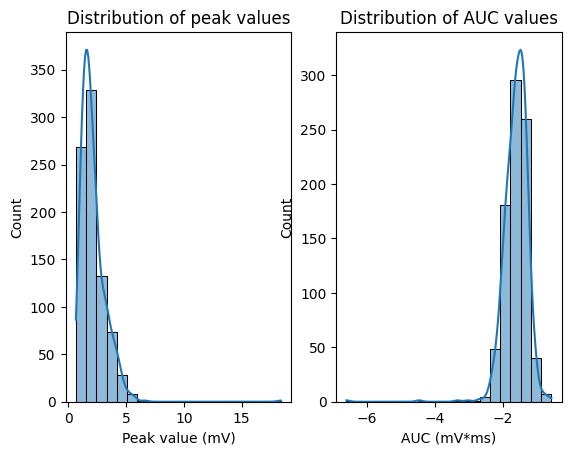

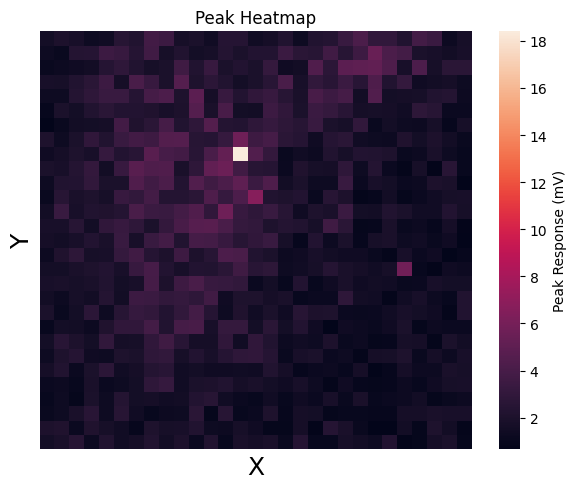

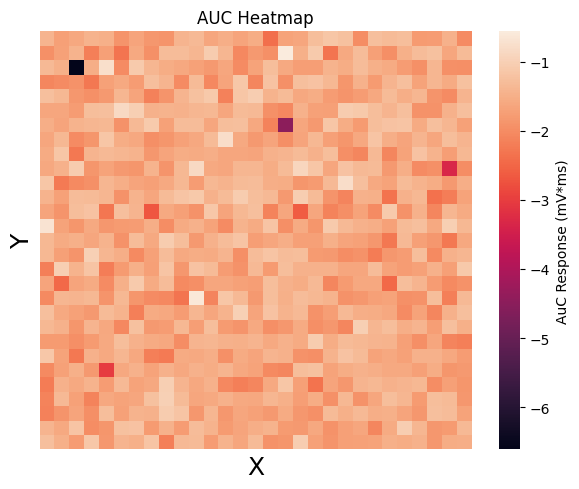

In [162]:
# cell8 is 17Apr2019, expt 04, 29x29 10ms 100% with blank flanks

data = abf_to_data.abf_to_data(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr19\17Apr19\19417004.abf", exclude_channels=[],
                baseline_criterion=0.1, sweep_baseline_epoch=[0, 0.2], baseline_subtraction=True,
                signal_scaling=1, sampling_freq=2e4, filter_type='bessel', filter_cutoff=1000,
                data_order="channelwise", plot_data=False )[0][0]

pattern_order = pd.read_csv(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr19\17Apr19\29xrand_20blankflank_10ms_100perc_unflanked_for_analysis.txt", sep=' ', header=None)
data = data[20:861,:]
Fs=2e4
df = pd.DataFrame({'sweep':range(841), 'peak':np.max(data,axis=1),'auc':np.trapz(data,axis=1)/Fs, 'loc':pattern_order[3].values - 1})
df['x'] = df['loc']%29
df['y'] = df['loc']//29

fig1, [ax1_1,ax1_2] = plt.subplots(1,2)
sns.histplot(df['peak'], bins=20, kde=True, ax=ax1_1)
sns.histplot(df['auc'], bins=20, kde=True, ax=ax1_2)
ax1_1.set_title('Distribution of peak values')
ax1_1.set_xlabel('Peak value (mV)')
ax1_2.set_title('Distribution of AUC values')
ax1_2.set_xlabel('AUC (mV*ms)')

# if clip spikes is true than any peak value above 30 should be clipped to 30
print("Clipping spikes above 30 mV")
df['peak'] = df['peak'].apply(lambda k: 30 if k > 30 else k)
df['auc'] = df['auc'].apply(lambda k: 3 if k > 3 else k)

df_pivot_peak = df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = df.pivot(index='x', columns='y', values='auc')

fig2_1, ax2_1 = plt.subplots(1,1, figsize=(6,5), layout='tight')
sns.heatmap(df_pivot_peak, ax=ax2_1, cmap='rocket', annot=False, vmin=np.min(df_pivot_peak.values), vmax=np.max(df_pivot_peak.values))
ax2_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax2_1.set_xticks([])
ax2_1.set_yticks([])
ax2_1.set_xticklabels([])
ax2_1.set_yticklabels([])
# axs labels
ax2_1.set_xlabel('X', fontsize=18)
ax2_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax2_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')
print("Peak Heatmap", np.min(df_pivot_peak.values), np.max(df_pivot_peak.values))

fig2_2, ax2_2 = plt.subplots(1,1, figsize=(6,5), layout='tight')
sns.heatmap(df_pivot_auc,  ax=ax2_2, cmap='rocket', annot=False, vmin=np.min(df_pivot_auc.values), vmax=np.max(df_pivot_auc.values))
ax2_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax2_2.set_xticks([])
ax2_2.set_yticks([])
ax2_2.set_xticklabels([])
ax2_2.set_yticklabels([])
# axs labels
ax2_2.set_xlabel('X', fontsize=18)
ax2_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax2_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')
print("AUC Heatmap", np.min(df_pivot_auc.values), np.max(df_pivot_auc.values))

cellid = 'cell8_04_29'
# savefig
fig1.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_hist.png")
fig2_1.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_peakmap.png")
fig2_2.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_aucmap.png")
fig1.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_hist.svg")
fig2_1.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_peakmap.svg")
fig2_2.savefig(rf"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Asymmetries-Analysis-Scripts\figures\{cellid}_aucmap.svg")

# stim_times, peak_df, df_pivot_peak, df_pivot_auc, fig1, [fig2_1, fig2_2], cell, stim


In [163]:
x = [0.2*np.array(841*[1]), df, df_pivot_peak, df_pivot_auc, fig1, [fig2_1, fig2_2], _,_]

In [164]:
parent_folder = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries")
data = {}
cell_datapaths = {
                    'cell3_04_29':      [r"Recording\3\17809004.abf",               r"Recording\3\Aug17-Polygon\02Aug17-29_random_100percent_10ms.txt", 'random',"",""],
                    'cell2_13_29':      [r"Recording\2\17503013.abf",               r"Recording\5\rand29x29_50perc20ms.txt",                            "",True,[0,841]], 
                    'cell2_09a_10':     [r"Recording\2\17503009.abf",               r"Protocols\Polygon\10x10_100perc_10ms.txt",                        "", True, [0,100]],
                    'cell2_02_10':      [r"Recording\2\17503002.abf",               r"Protocols\Polygon\10x10_100perc_10ms.txt",                            "","",""],
                    'cell1_13_10':      [r"Recording\1\17802013.abf",               r"Recording\5\maxSep10x10_20percent10ms.txt",                       'random',"",""], 
                    'cell1_15_10':      [r"Recording\1\17802015.abf",               r"Recording\5\maxSep10x10_20percent10ms.txt",                       'random',"",""], 
                    'cell4_04_59':      [r"Recording\4\17726004.abf",               r"Recording\4\17726004.txt", 'random',"",""],
                    'cell5_09_10':      [r"Recording\Apr18\27Apr18\18427009.abf",   r"Recording\5\maxSep10x10_20percent10ms.txt",                       'random',"",""],    # done
                    'cell5_10_29':      [r"Recording\Apr18\27Apr18\18427010.abf",   r"Recording\5\rand29x29_50perc20ms.txt",                            'random',"",""], # done
                    'cell5_11_59':      [r"Recording\Apr18\27Apr18\18427011.abf",   r"Recording\5\59xgrid29roi_100perc10ms.txt",                        'random',"",""], # done
}

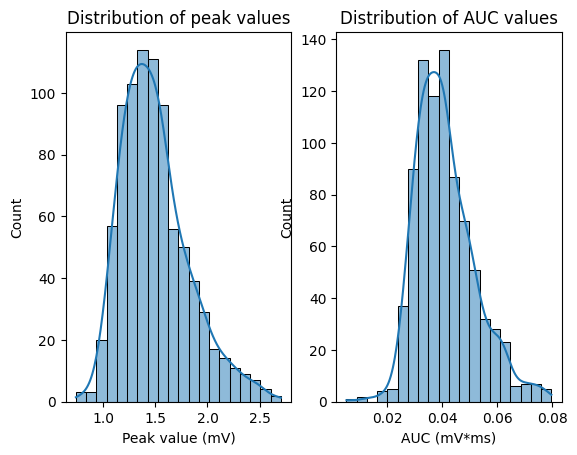

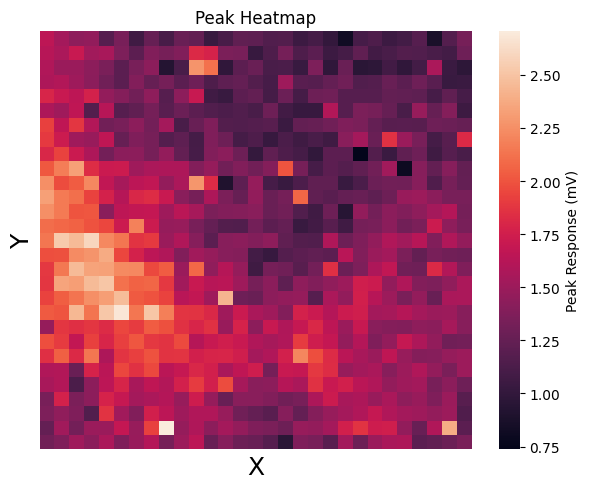

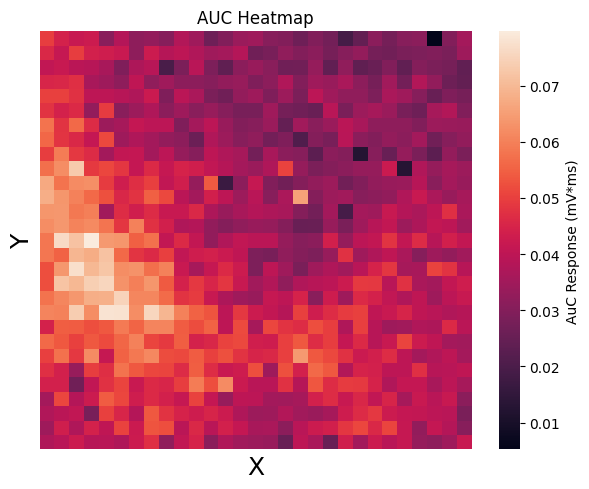

In [165]:
importlib.reload(ag)
for k,v in cell_datapaths.items():
    print(f'Processing file {k}') 
    expected_stim = 841 if k[-1]=='9' else 100
    try:
        data[k] = ag.plot_heatmap(parent_folder / v[0], parent_folder / v[1], stim_times=None, expected_stims=expected_stim,
                                  stim_threshold=2,protocol_order=v[2],cut_trace=v[3], pulse_slice=v[4], clip_spikes=True, clip_value=30)
        # save figs
        fighist, figpeakmap, figaucmap = data[k][4], data[k][5][0], data[k][5][1]
        cellid = k
        fighist.savefig(f'figures/{cellid}_hist.png')
        figpeakmap.savefig(f'figures/{cellid}_peakmap.png')
        figaucmap.savefig(f'figures/{cellid}_aucmap.png')
        fighist.savefig(f'figures/{cellid}_hist.svg')
        figpeakmap.savefig(f'figures/{cellid}_peakmap.svg')
        figaucmap.savefig(f'figures/{cellid}_aucmap.svg')

    except Exception as e:
        print(f"Error in {k}: {e}")
        data[k] = None


    clear_output()

## Mat files

In [ ]:
cell9_13_29 = [
                r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Sept18\26Sep17\Expt03\Expt03_Parsed_Tracelets_29.mat",
                r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Sept18\26Sep17\Expt07\Expt07_Parsed_Tracelets_29.mat",
                r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Sept18\26Sep17\Expt13\Expt13_Parsed_Tracelets_29.mat",
            ]

cell10_03_29= [
                r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Sept18\07Sept18\Expt03\Expt03_Parsed_Tracelets_29.mat",
                r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Sept18\07Sept18\Expt04\Expt04_Parsed_Tracelets_29.mat",
                ]

cell6_01_29=[
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\6\Expt1_300517.mat",
        ]

cell11_04_29 = [
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Oct18\26Oct18\Expt04_cell1_29x29_10ms_100perc\Expt04_cell1_29x29_10ms_100perc_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Oct18\26Oct18\Expt04_cell1_29x29_10ms_100perc.txt",
]

# cell 16
cell16 [
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\Expt15\Expt15_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\Expt10\Expt10_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\Expt07\Expt07_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\Expt04\Expt04_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\expt01\expt01_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\11Jan19\29x29_100perc_10ms_rand.txt",
        ]

cell17 = [
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\30Jan19\Expt02\Expt02_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\30Jan19\29x29_100perc_10ms_rand.txt",
        ]


cell18 = [
            r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\16Jan19\Expt18\Expt18_Parsed_Tracelets_29.mat",
            r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\16Jan19\Expt13\Expt13_Parsed_Tracelets_29.mat",
            r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\16Jan19\Expt10\Expt10_Parsed_Tracelets_29.mat",
            r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\16Jan19\Expt02\Expt02_Parsed_Tracelets_29.mat",
            r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Jan19\16Jan19\29x29_100perc_10ms_rand.txt",
            ]


cell19 = [
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\Expt015_grid29x_20ms_40xobj\Expt015_grid29x_20ms_40xobj_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\Expt013_grid29x_10ms_40xobj\Expt013_grid29x_10ms_40xobj_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\Expt009_grid29x_20ms_20xobj\Expt009_grid29x_20ms_20xobj_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\Expt003_grid29x_20ms\Expt003_grid29x_20ms_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\Expt002_grid29x_10ms\Expt002_grid29x_10ms_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\20Feb19\29x29_100perc_10ms_rand.txt",
    ]

cell20 = [
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\22Feb19\Expt02\Expt02_Parsed_Tracelets_29.mat",
        r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\22Feb19\29x29_100perc_10ms_rand.txt",
        ]

cell21 = [
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\15Feb19\29x29_100perc_10ms_rand.txt",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\15Feb19\Expt13_15Feb19\Expt13_15Feb19_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\15Feb19\Expt05_15Feb19\Expt05_15Feb19_Parsed_Tracelets_29.mat",
    r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Feb19\15Feb19\Expt04_15Feb19\Expt04_15Feb19_Parsed_Tracelets_29.mat",
]

In [174]:
from scipy.spatial import distance
def get_asymmetry(response_distribution, clip_soma=True, th=50, plot=False, plot_mask=False, sensitivity=1, ax=None, cell_name_suffix='cellXX'):
    gridsize = response_distribution.shape[0]
    if clip_soma:
        response_distribution = np.where(response_distribution < np.percentile(response_distribution,95), response_distribution, 0)
    
    x = np.where(response_distribution > np.percentile(response_distribution,th), 1, 0)
    y = np.where(response_distribution > np.percentile(response_distribution,th), response_distribution, 0)

    y = y**sensitivity

    gomy, gomx = ndimage.center_of_mass(x)
    comy, comx = ndimage.center_of_mass(y)
    dist = distance.euclidean((comx/ gridsize, comy/ gridsize), (gomx/ gridsize, gomy/ gridsize))
    if plot:
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(response_distribution, cmap='magma', origin='lower')
        ax.imshow(x, alpha=0.2, cmap='grey', origin='lower') if plot_mask else None
        hh,hw = response_distribution.shape[0]//2, response_distribution.shape[1]//2

        # draw a straight line with arrowhead connecting the two points
        ax.annotate('', xy=(comx, comy), xytext=(gomx, gomy),arrowprops=dict(facecolor='white', shrink=0.1, edgecolor='white'),)
        ax.scatter(hw, hh, c='b', s=200, marker='o', label='frame centre', )
        ax.scatter(comx, comy, c='g', s=200,marker='*', label='excitation centre',)
        ax.scatter(gomx, gomy, c='k', s=200,marker='+', label='anatomical centre',)

        # add distance as a measure of asymmetry as text annoation
        ax.text(0.95, 0.8, f'Asymmetry = {dist:.2f}', color='w', fontsize=20, ha='right', va='center', transform=ax.transAxes)

        ax.legend(fontsize=20)
        # remove axis
        ax.axis('off')
        # tight layout
        plt.tight_layout()

    return dist, [[np.round(gomx,2), np.round(gomy,2)],[np.round(comx,2), np.round(comy,2)]], fig, ax

In [175]:
fig_folder = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots")

Processing cell3_04_29
Processing cell2_13_29
Processing cell2_09a_10
Processing cell2_02_10
Processing cell1_13_10
Processing cell1_15_10
Processing cell4_04_59
Processing cell5_09_10
Processing cell5_10_29
Processing cell5_11_59
Processing cell8_04_29


C:\Users\adity\AppData\Local\Temp\ipykernel_39948\3526036858.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))


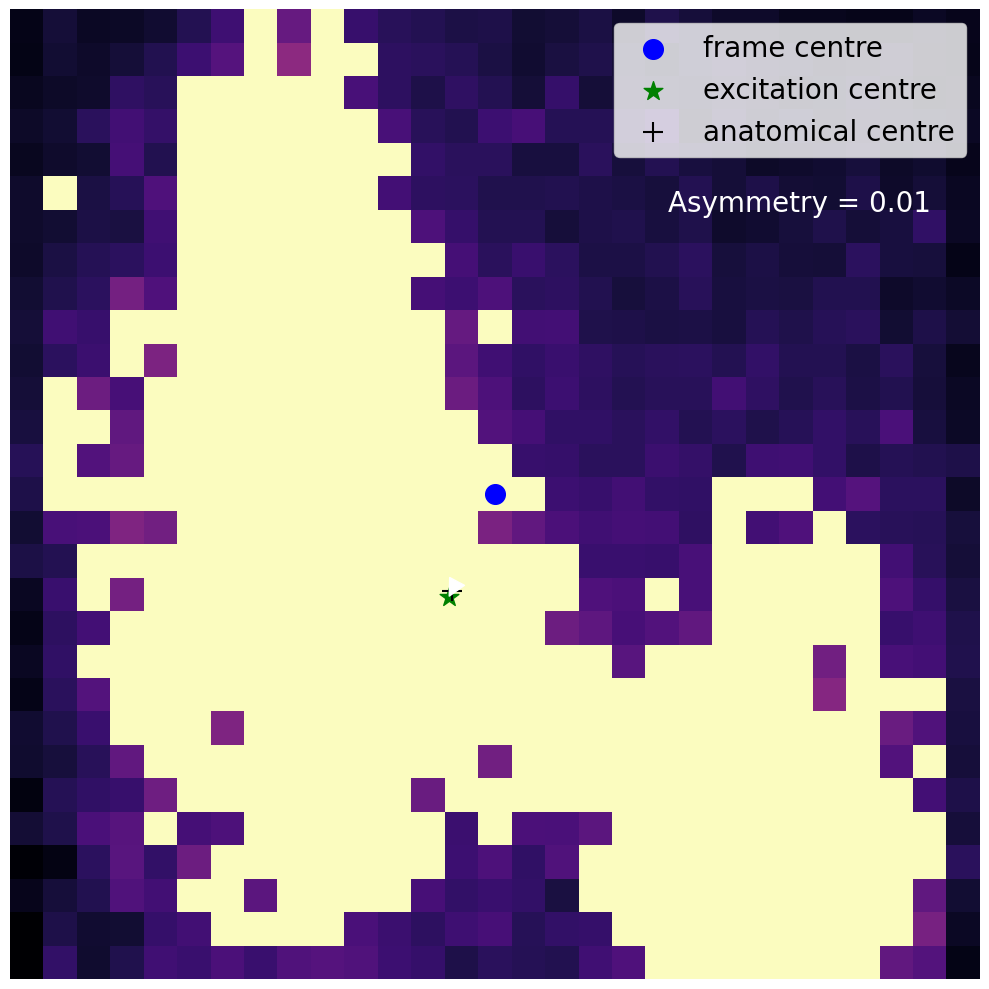

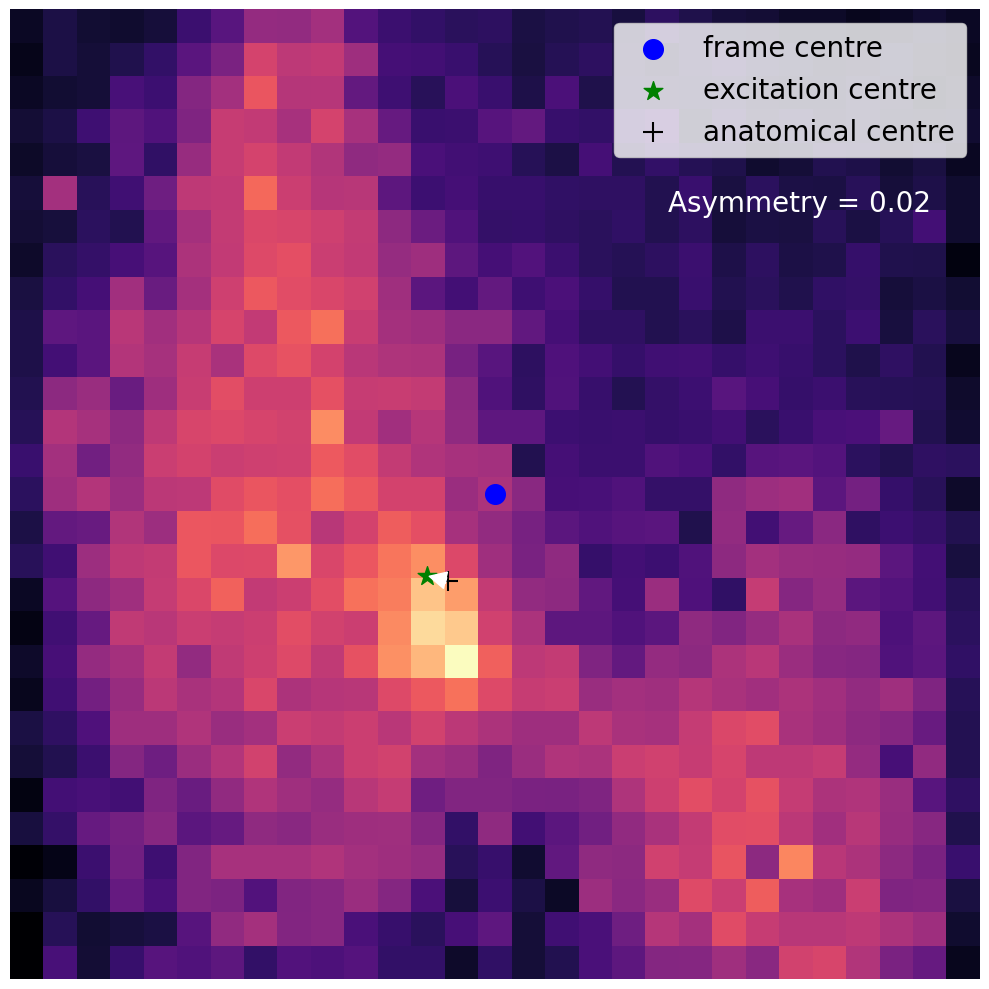

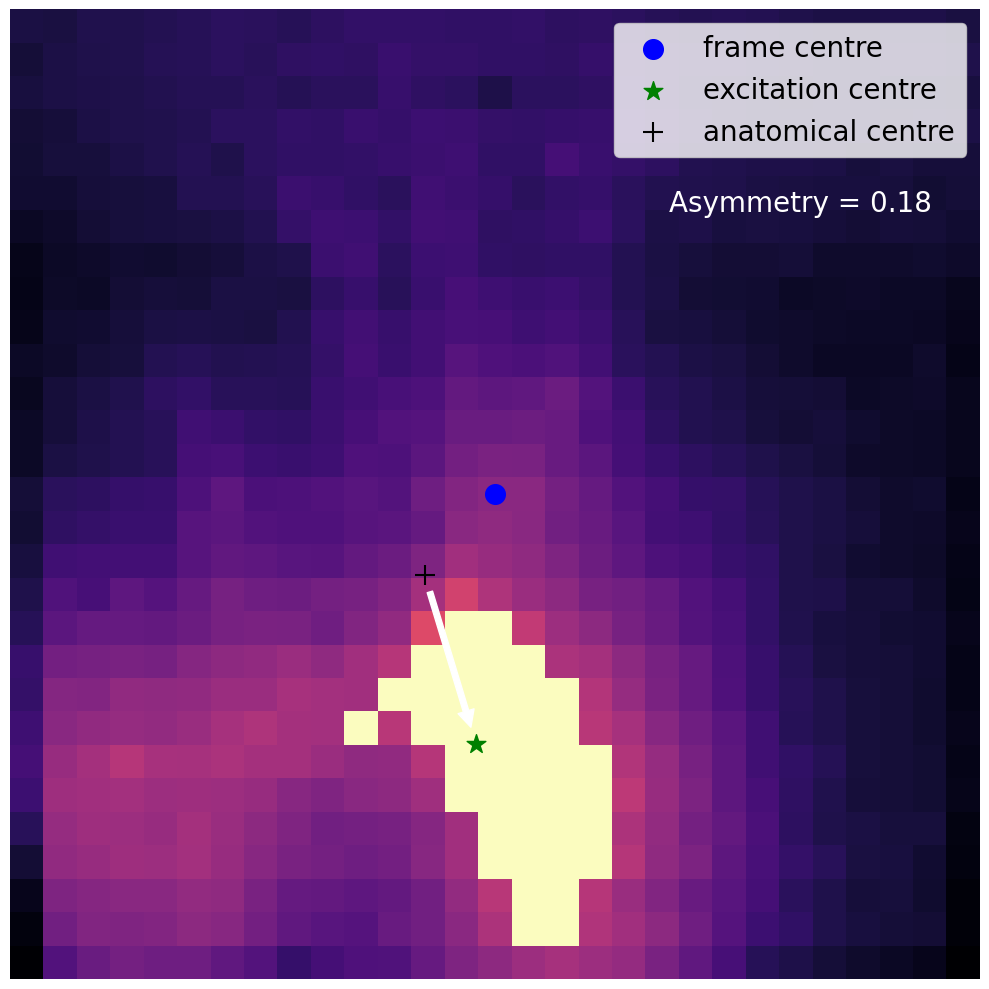

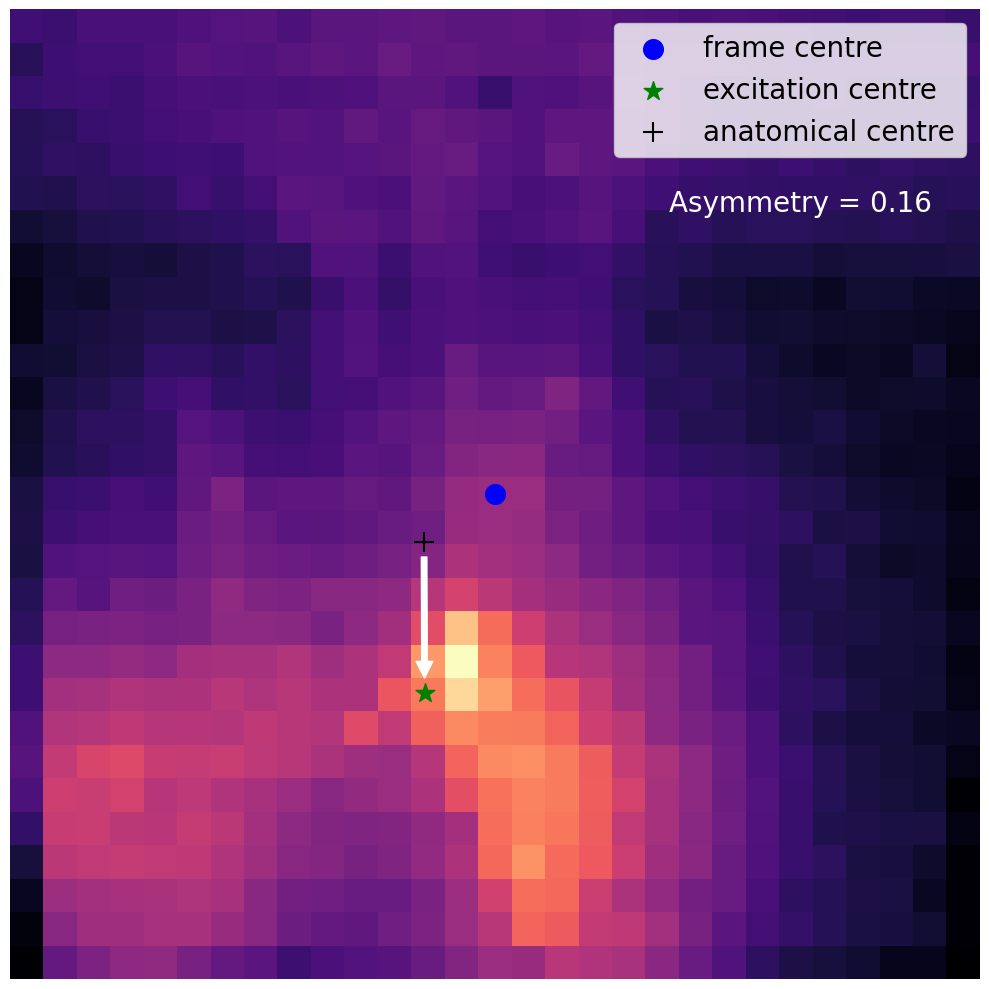

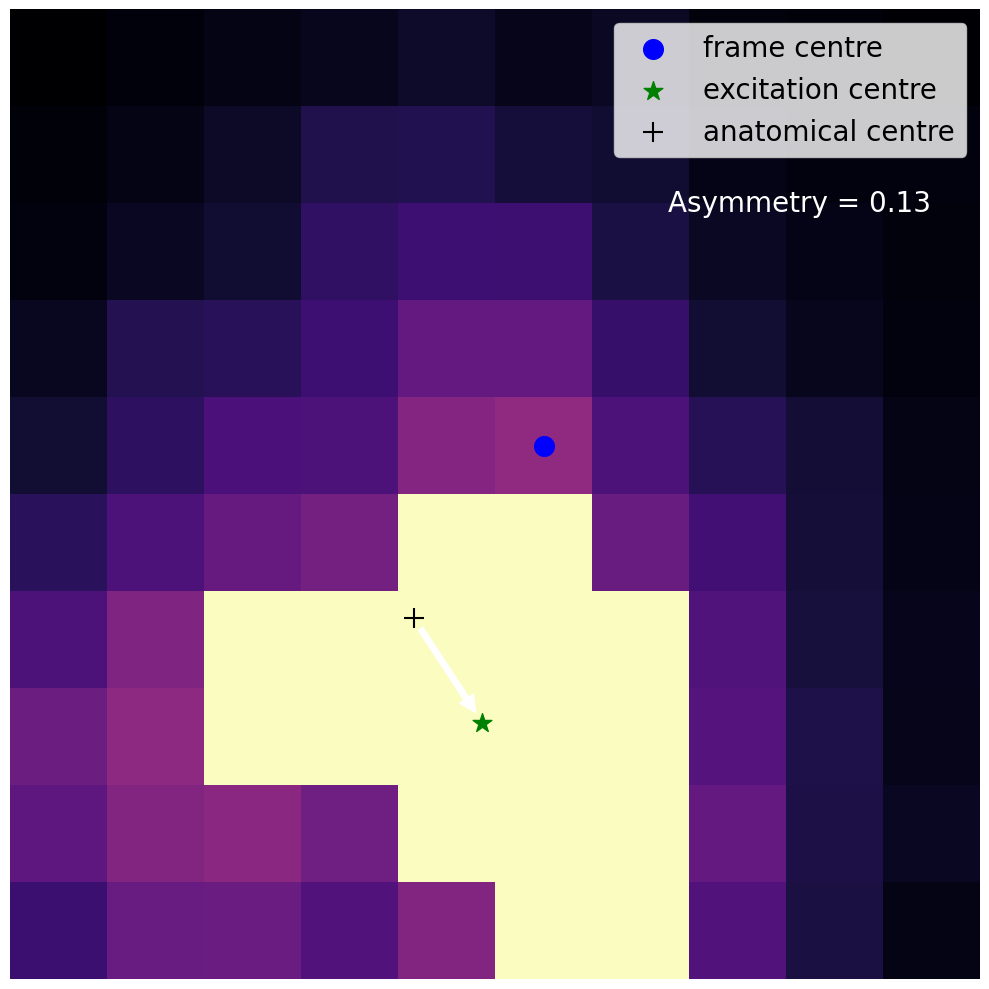

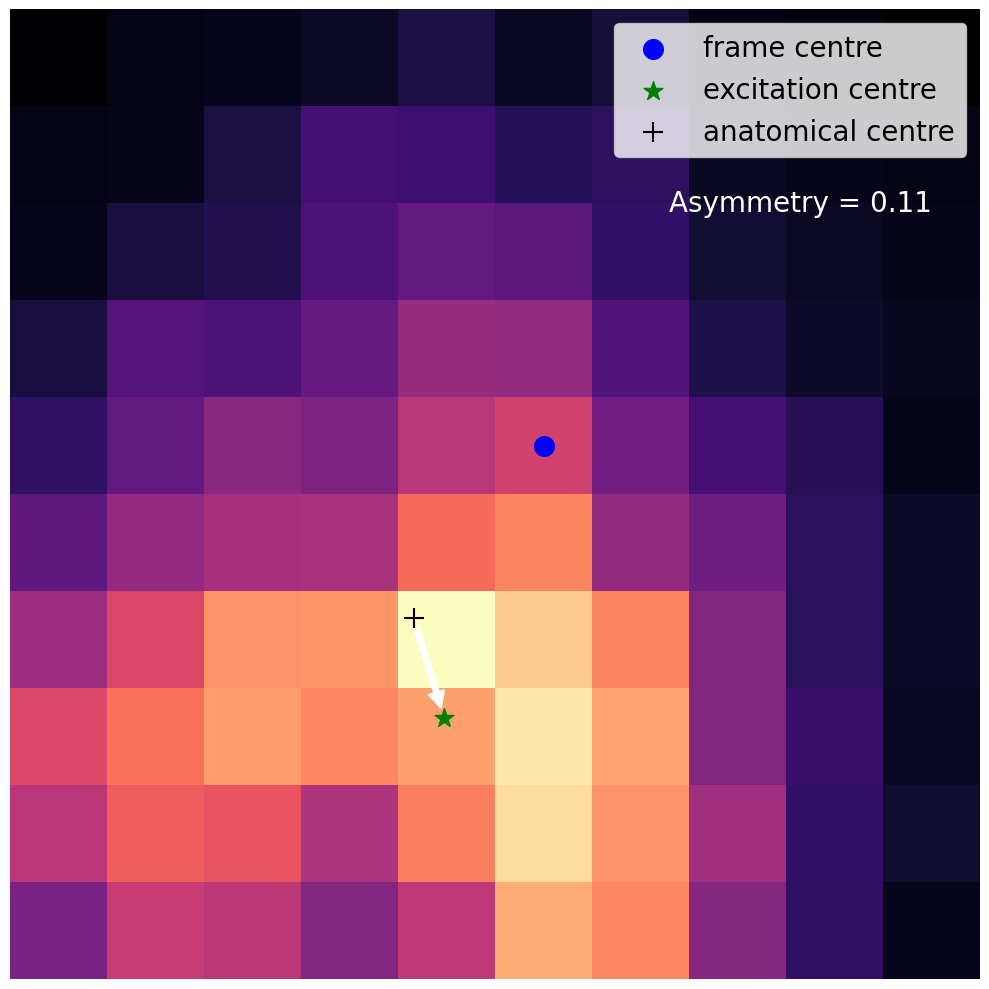

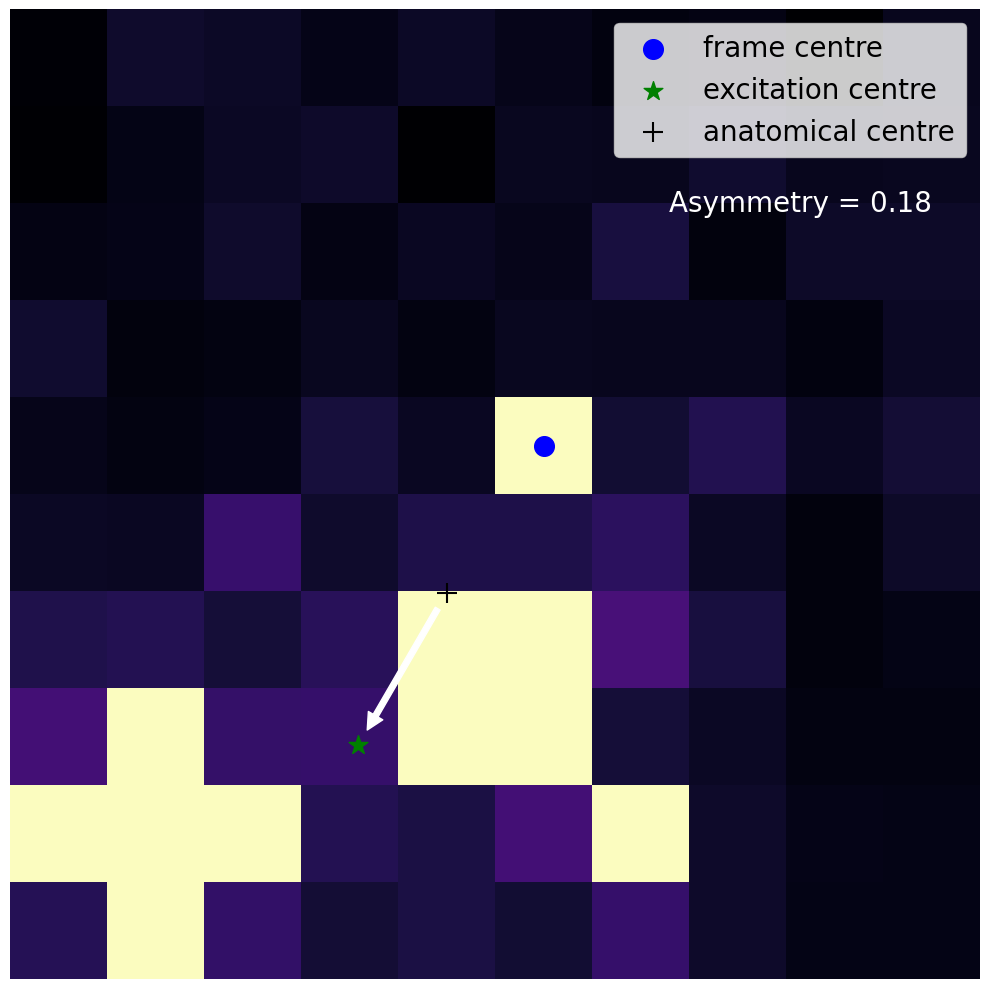

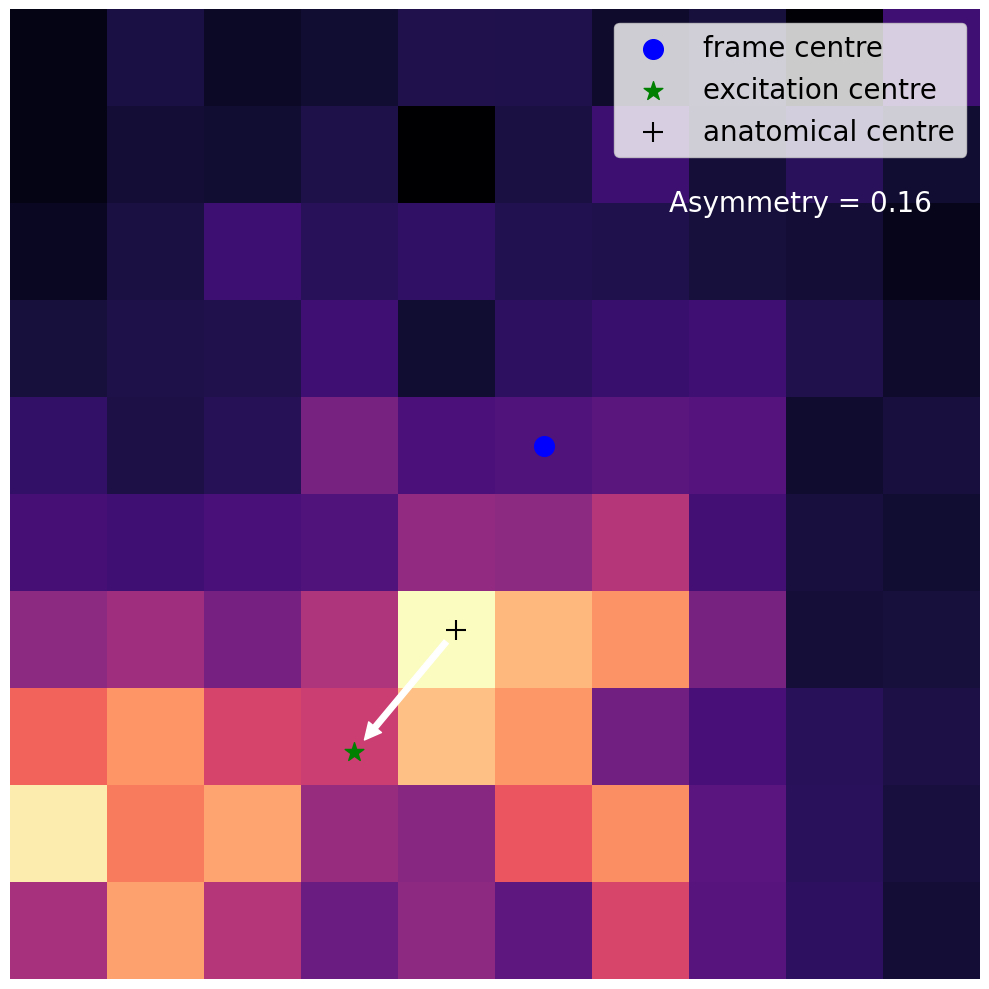

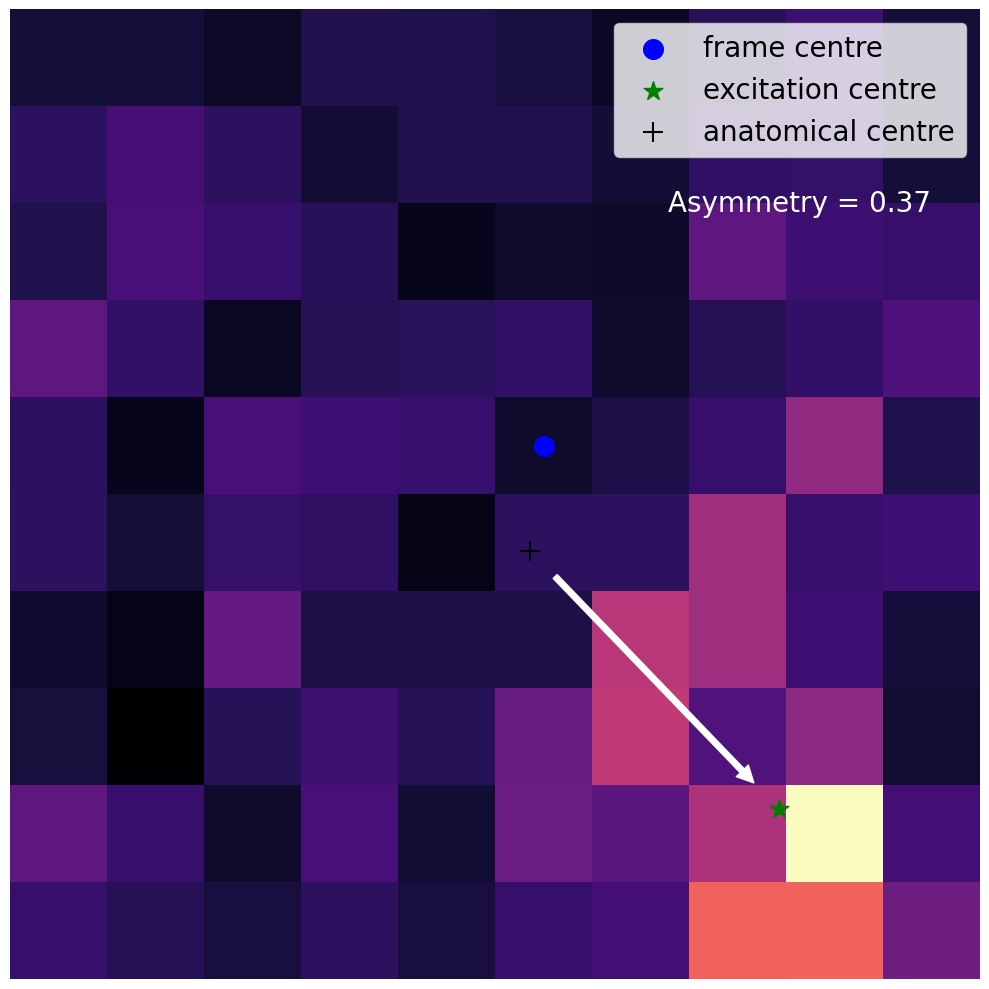

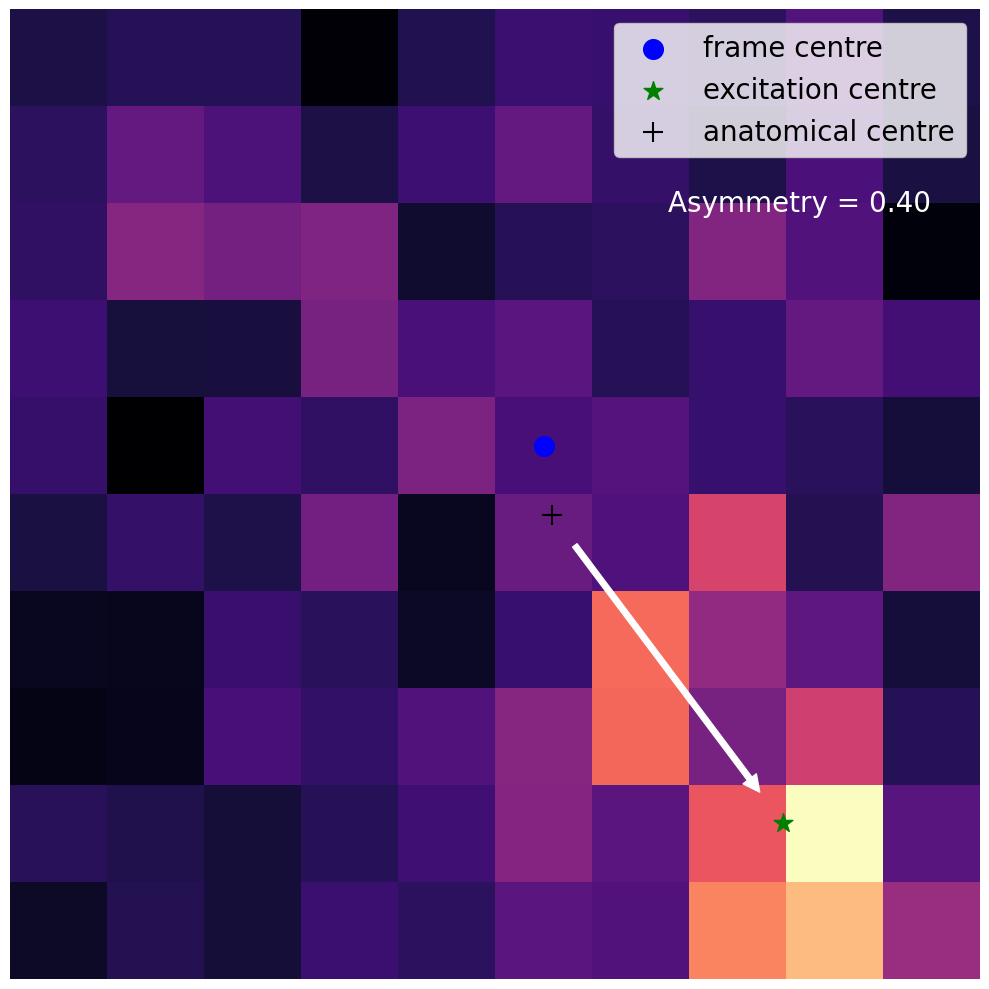

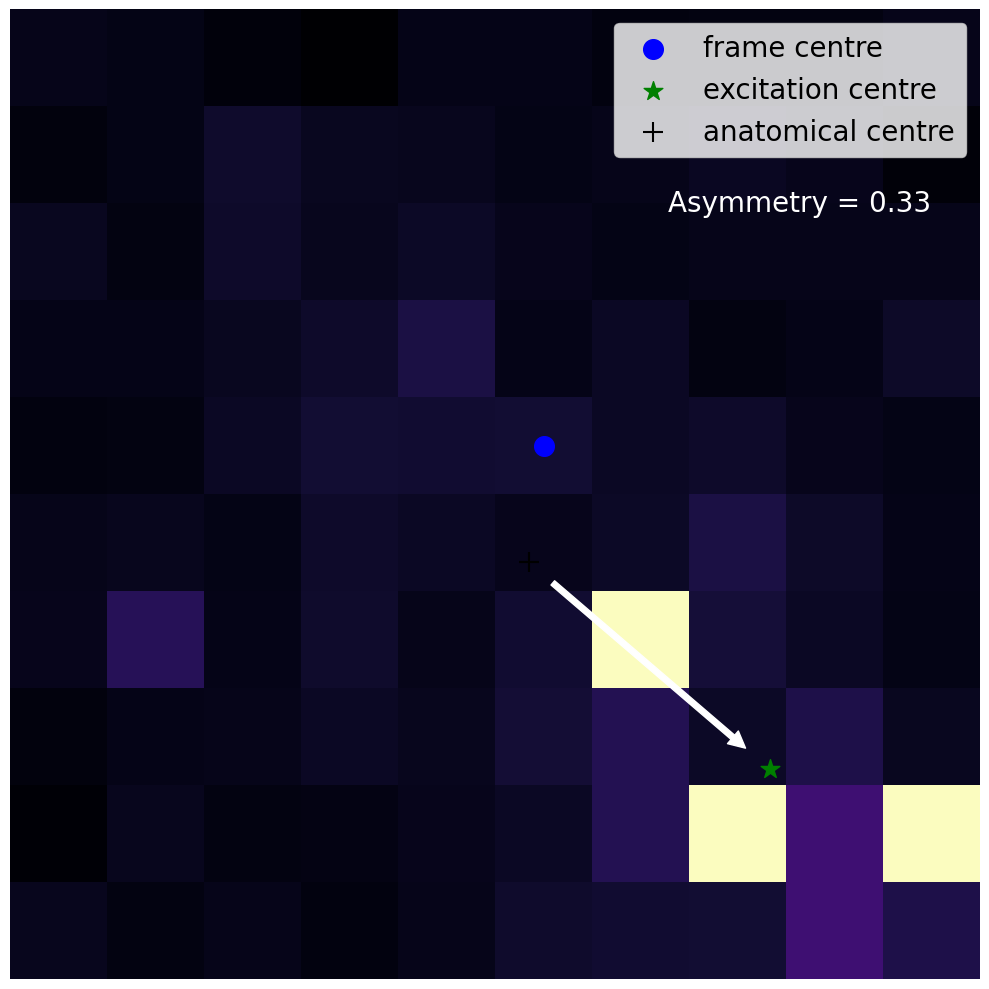

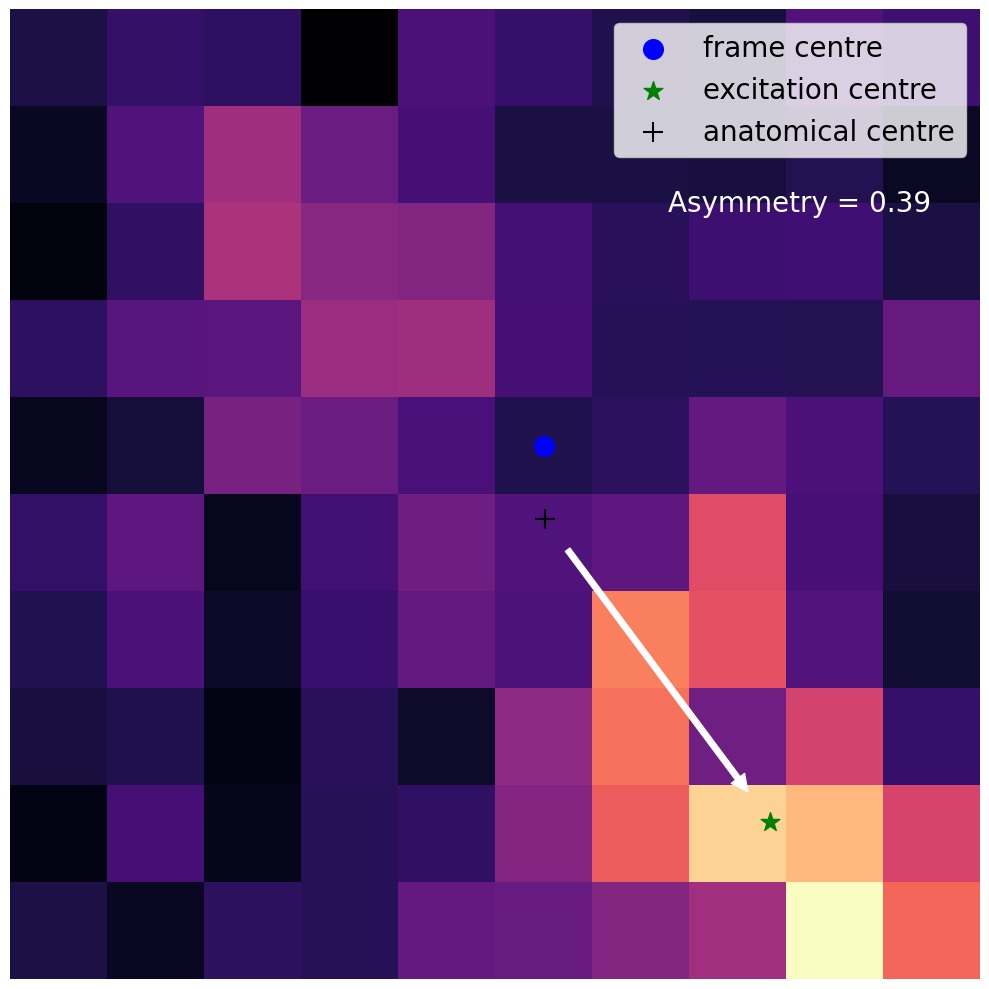

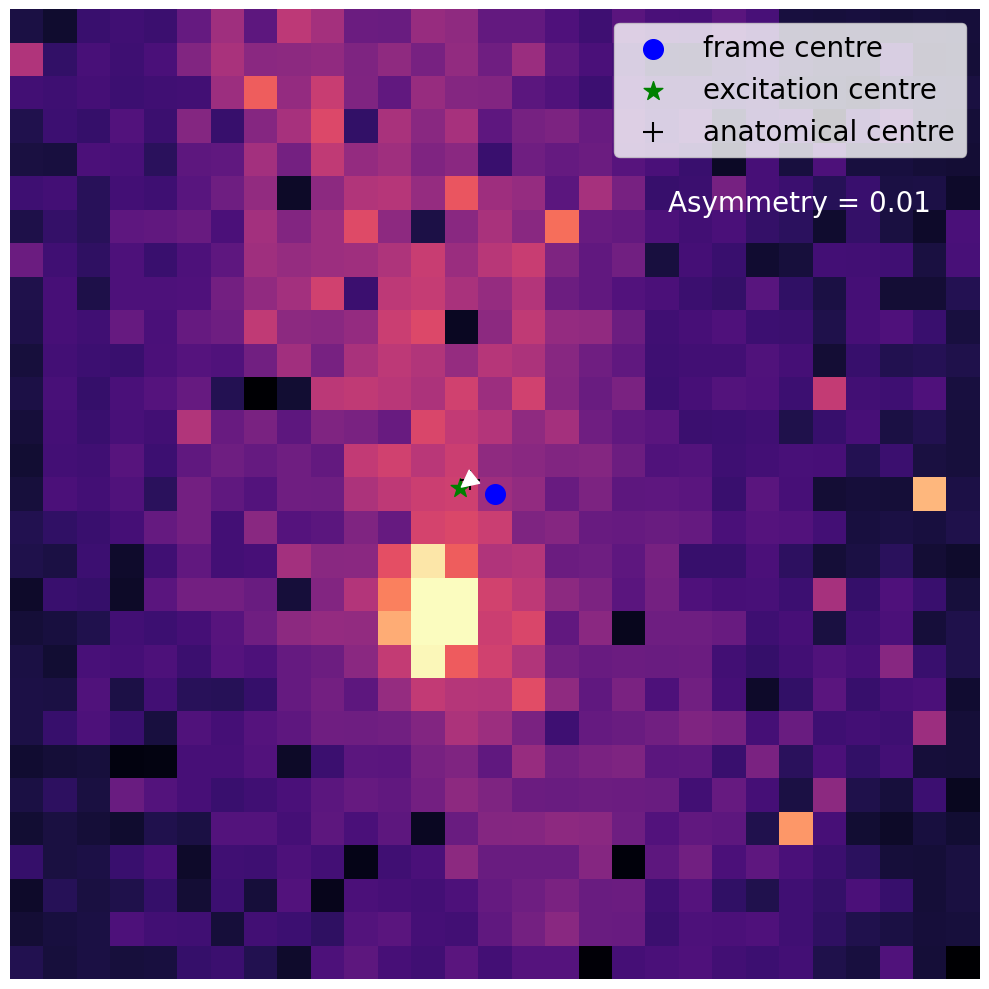

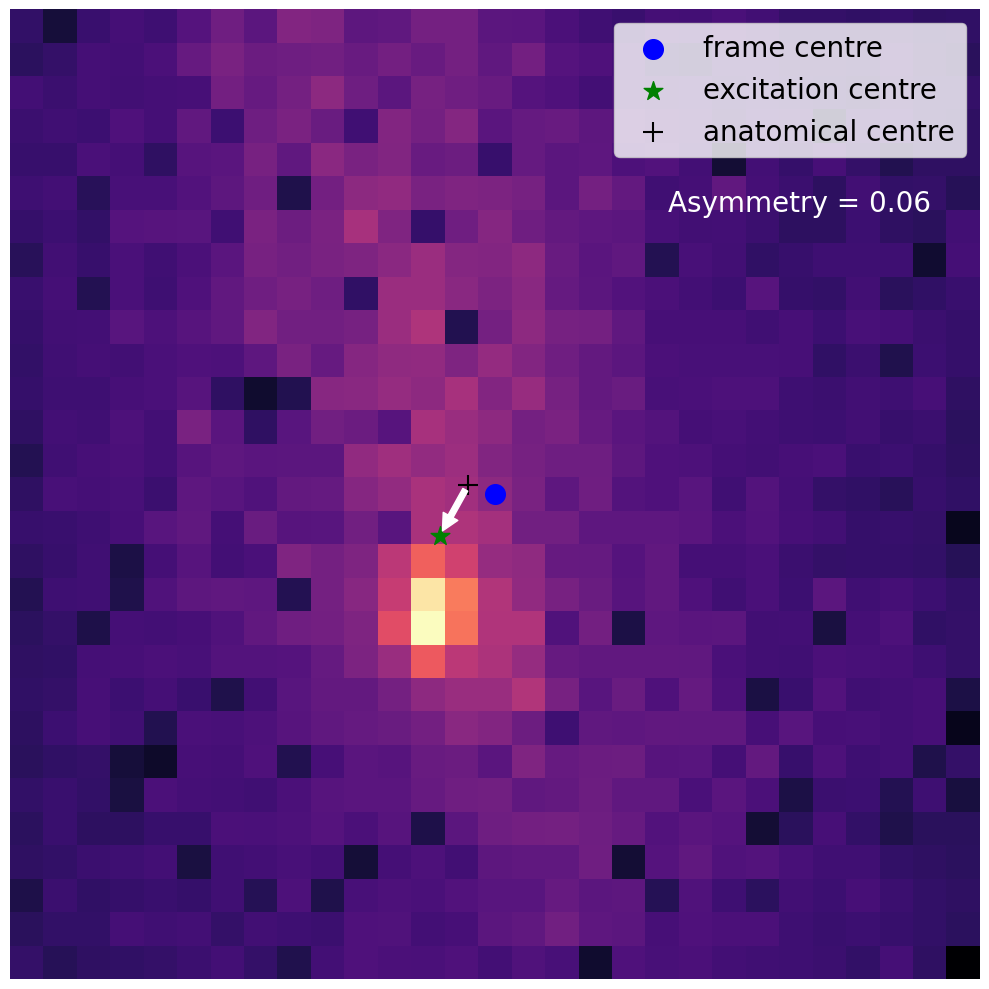

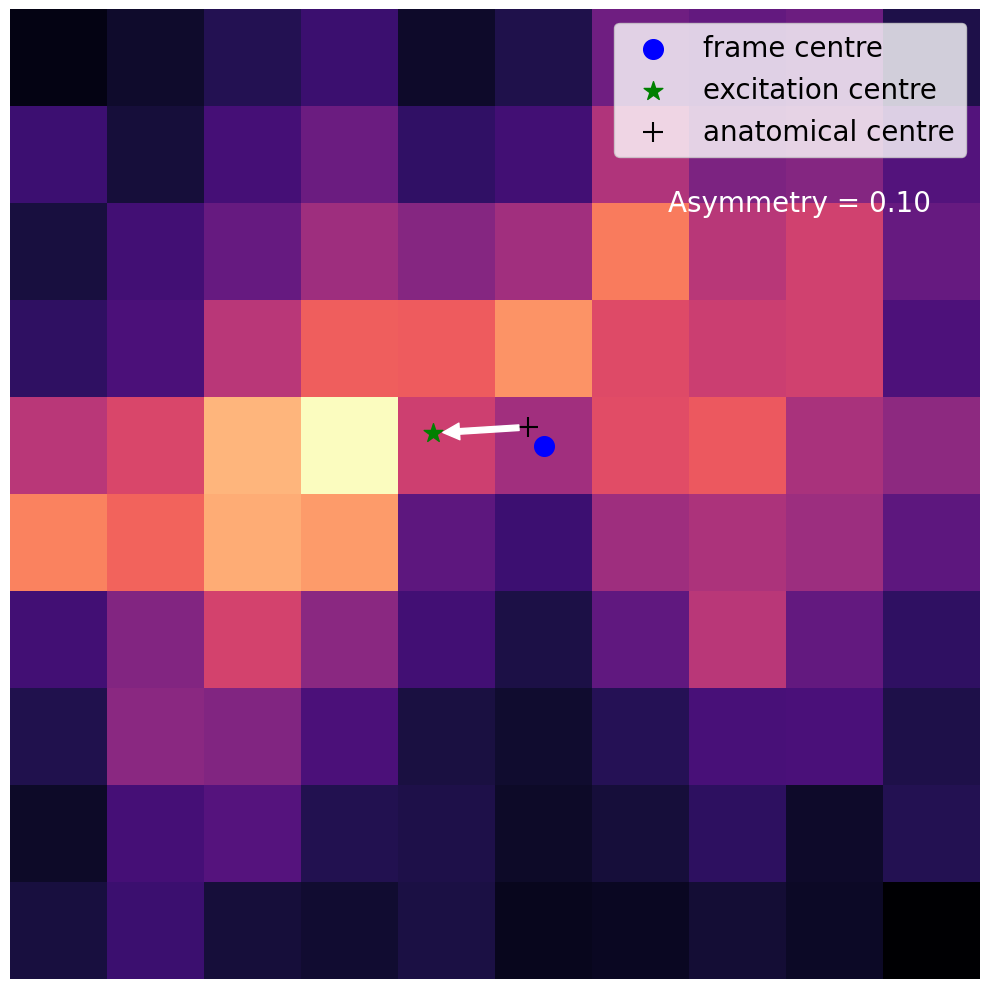

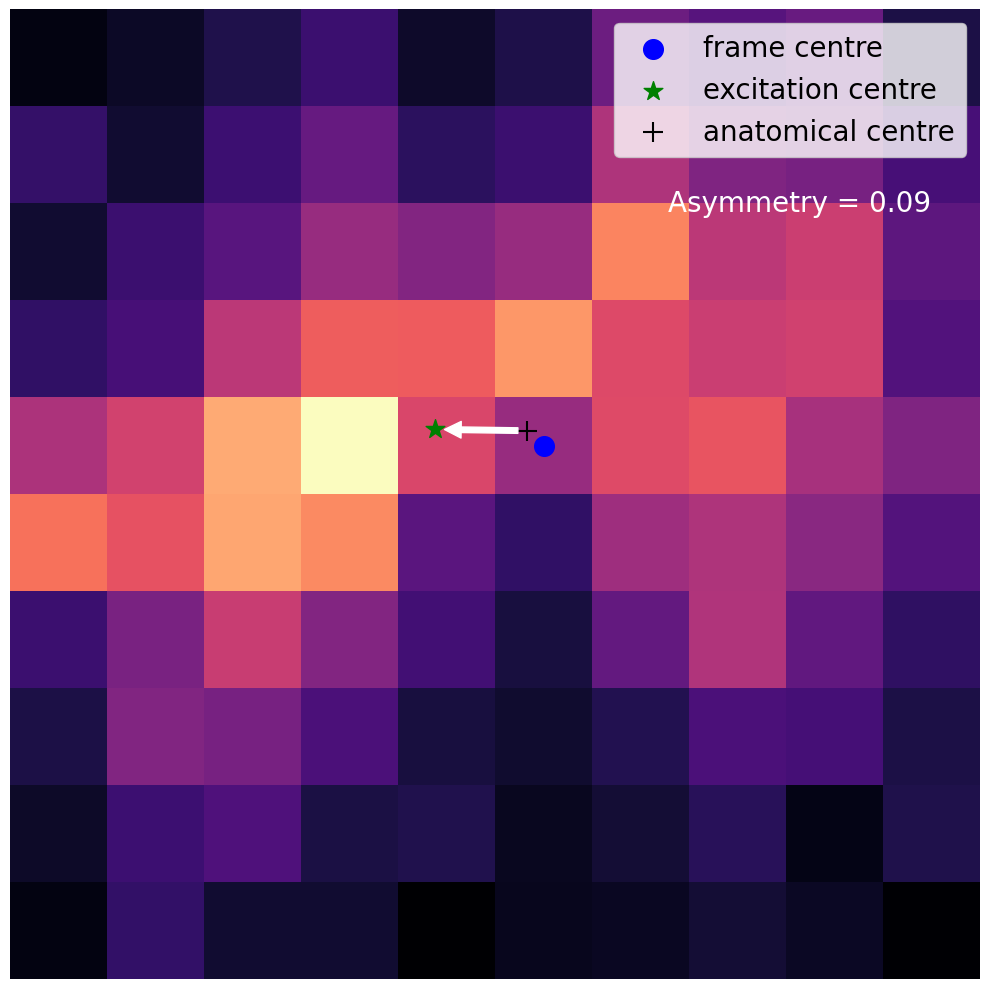

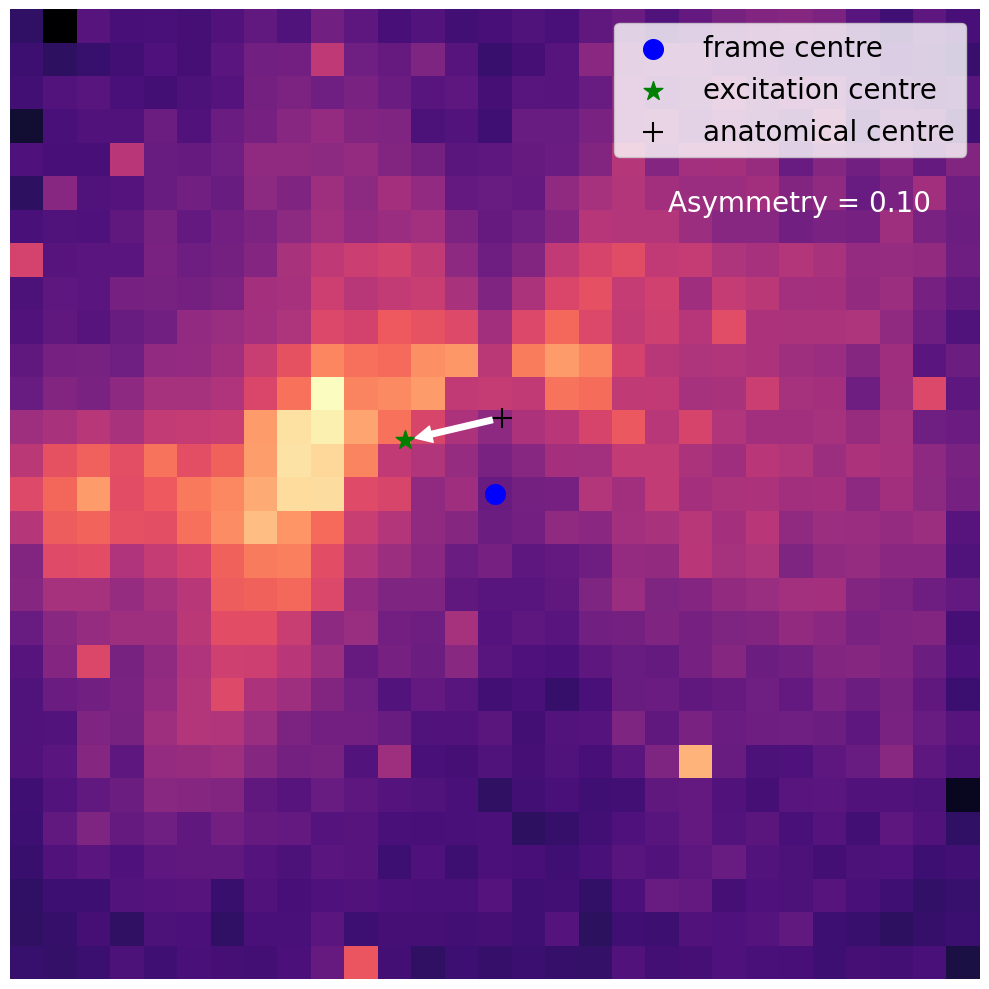

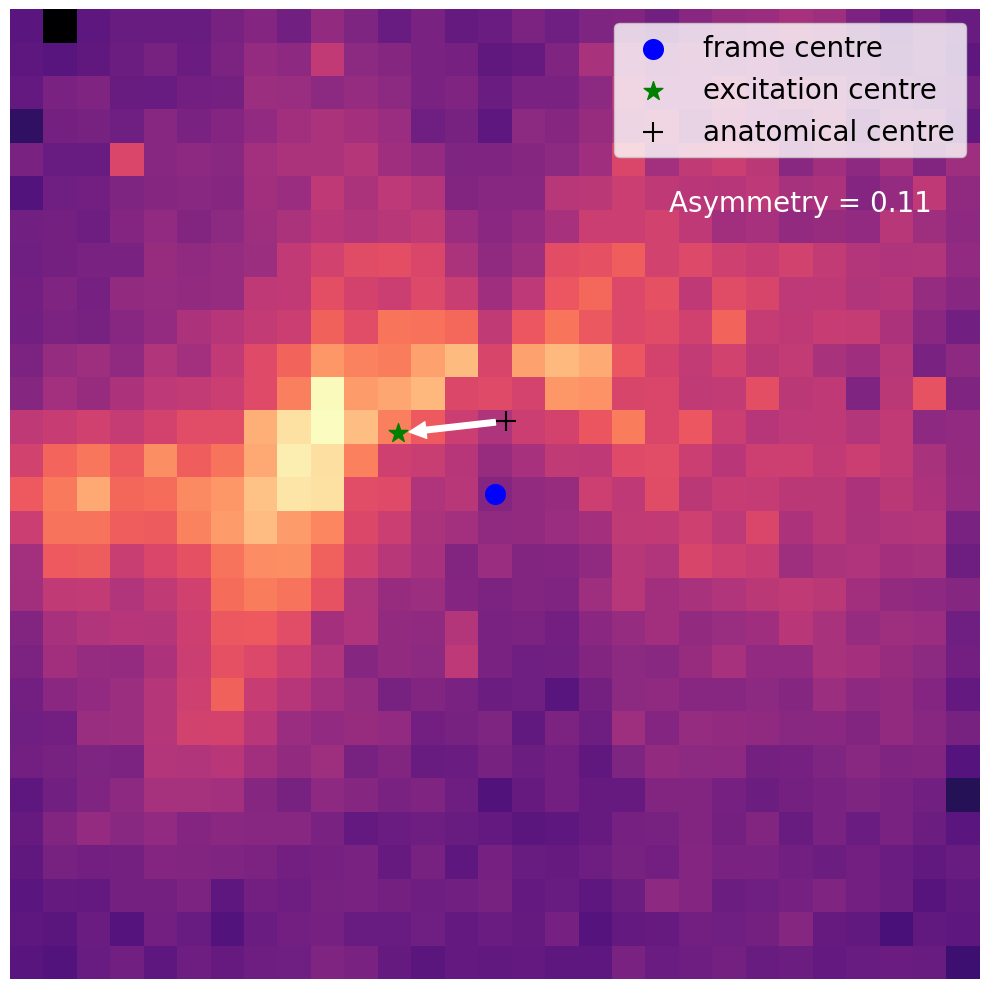

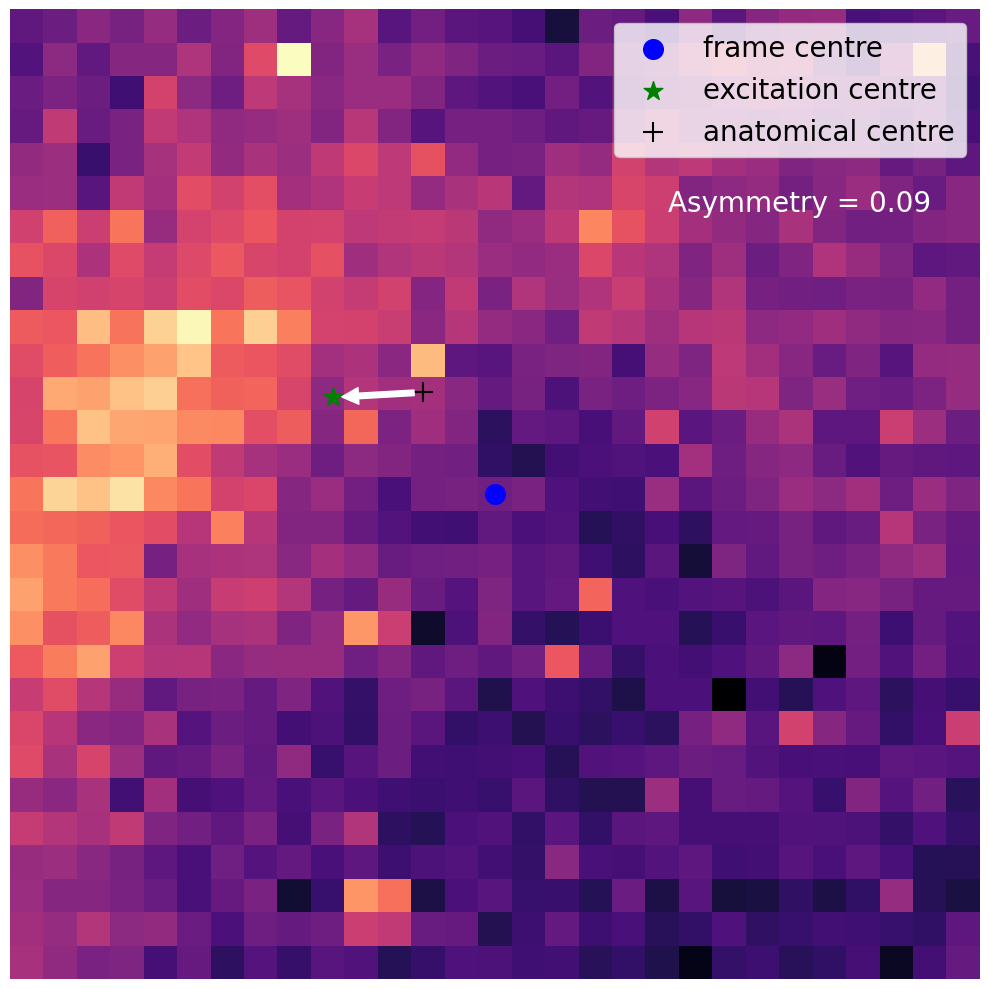

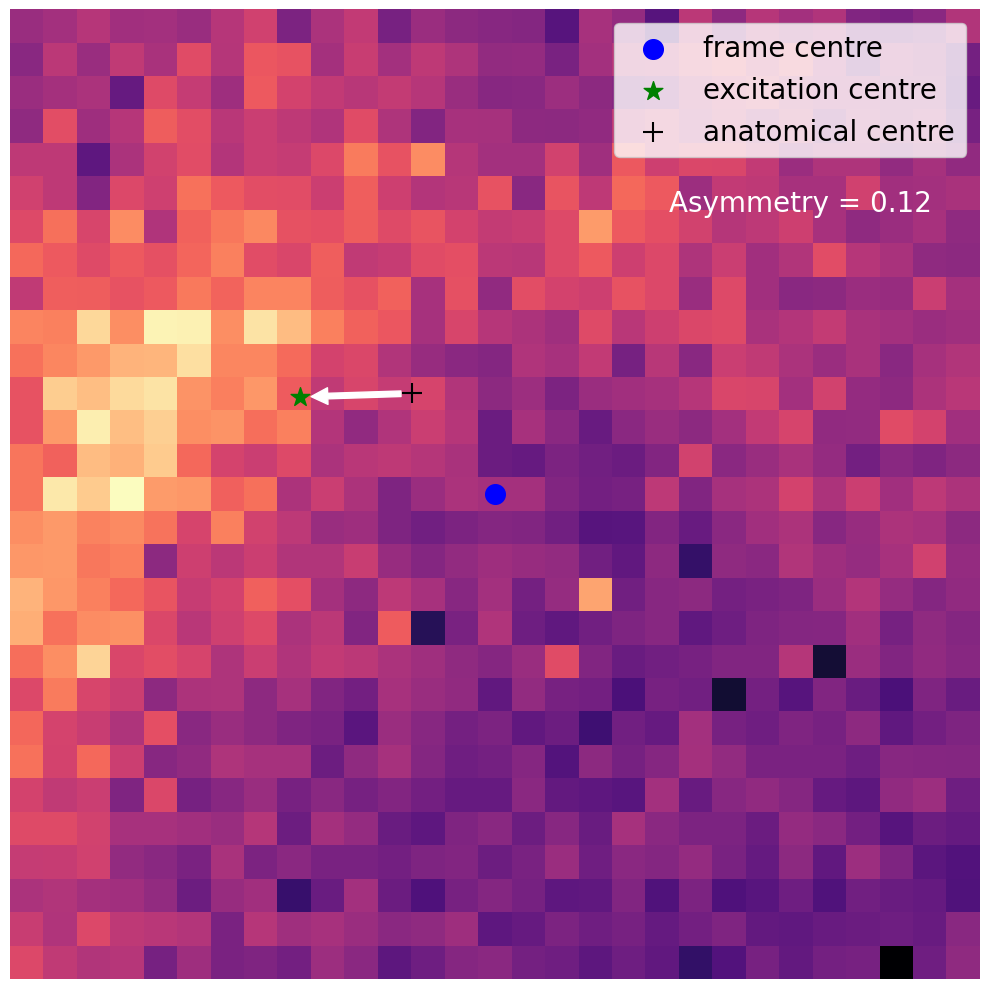

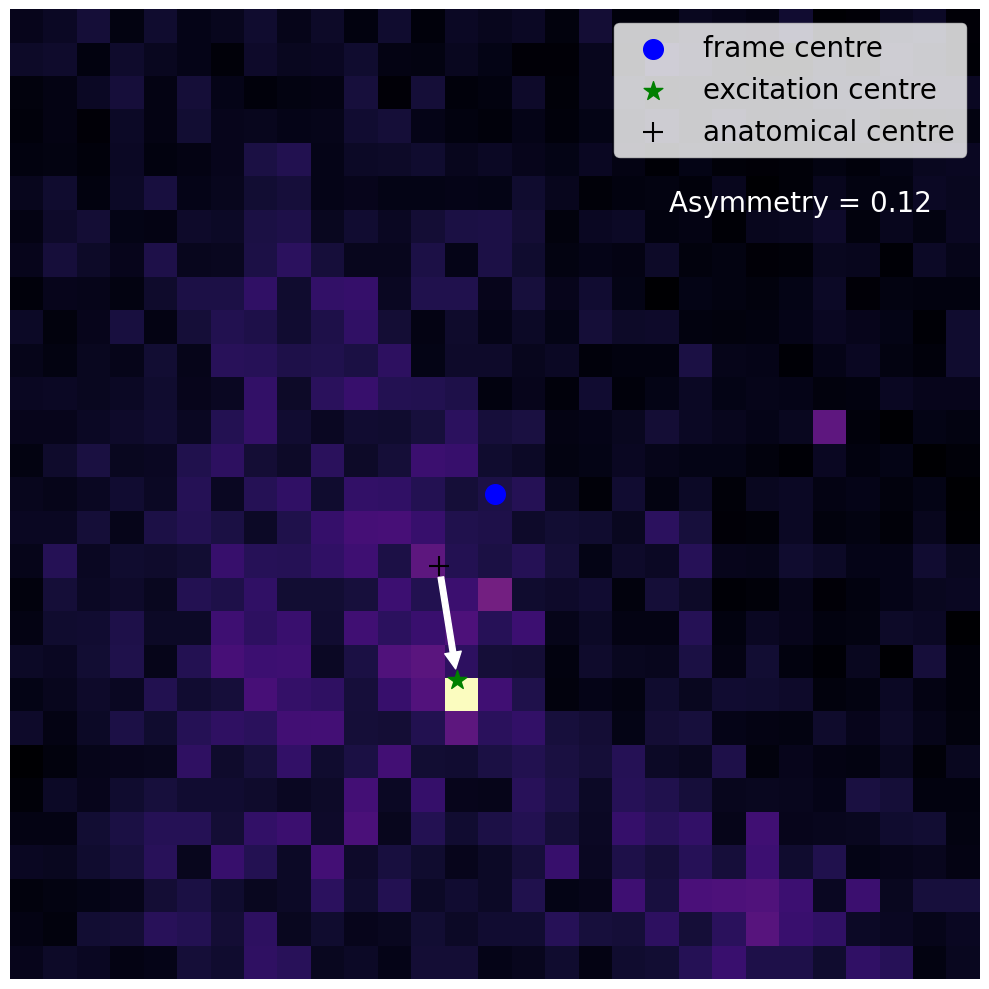

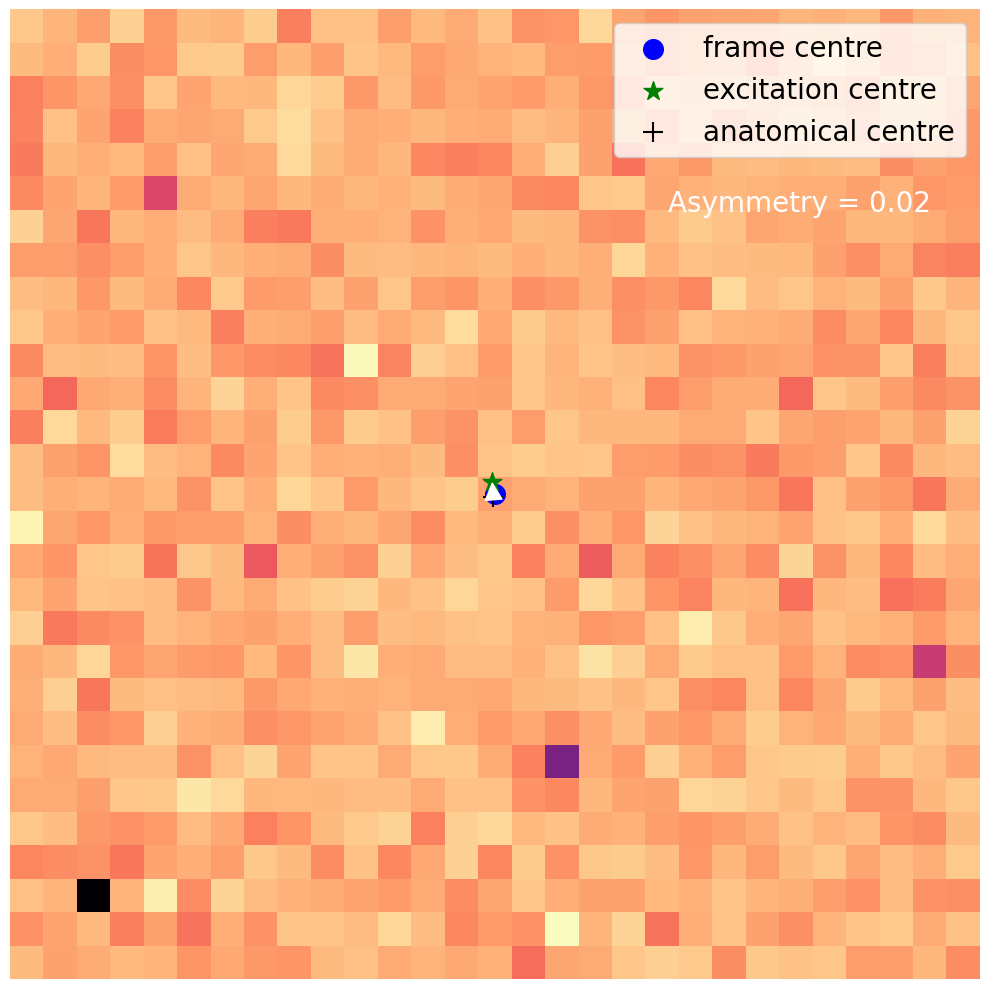

In [179]:
all_cells = []
for cell_name_suffix, cell_data in data.items():
    cell,expt,gridsize = cell_name_suffix.split('_')
    print(f'Processing {cell_name_suffix}')
    df = cell_data[2]
    d,coms,fig,ax = get_asymmetry(df, clip_soma=False, th=41, sensitivity=4, plot=True)
    fig.savefig(fig_folder / f'asymmetry_centreofmass_29x29_{cell_name_suffix}_peak.png')
    fig.savefig(fig_folder / f'asymmetry_centreofmass_29x29_{cell_name_suffix}_peak.svg')
    params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'peak', 'distance':d, 'coms':coms}
    all_cells.append(params)

    df = cell_data[3]
    d,coms,fig,ax = get_asymmetry(df, clip_soma=False, th=41, sensitivity=4, plot=True)
    fig.savefig(fig_folder / f'asymmetry_centreofmass_29x29_{cell_name_suffix}_auc.png')
    fig.savefig(fig_folder / f'asymmetry_centreofmass_29x29_{cell_name_suffix}_auc.svg')
    params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'auc', 'distance':d, 'coms':coms}
    all_cells.append(params)

asymmetry_by_distance = pd.DataFrame(all_cells)

In [187]:
asymmetry_by_distance

cell_name_suffix      cell expt grid  prop  distance  \
0       cell3_04_29     cell3   04   29  peak  0.006862   
1       cell3_04_29     cell3   04   29   auc  0.022288   
2       cell2_13_29     cell2   13   29  peak  0.182220   
3       cell2_13_29     cell2   13   29   auc  0.156051   
4      cell2_09a_10     cell2  09a   10  peak  0.129472   
5      cell2_09a_10     cell2  09a   10   auc  0.107854   
6       cell2_02_10     cell2   02   10  peak  0.180916   
7       cell2_02_10     cell2   02   10   auc  0.164542   
8       cell1_13_10     cell1   13   10  peak  0.369182   
9       cell1_13_10     cell1   13   10   auc  0.397348   
10      cell1_15_10     cell1   15   10  peak  0.327211   
11      cell1_15_10     cell1   15   10   auc  0.388844   
12      cell4_04_59     cell4   04   59  peak  0.012954   
13      cell4_04_59     cell4   04   59   auc  0.060696   
14      cell5_09_10     cell5   09   10  peak  0.098335   
15      cell5_09_10     cell5   09   10   auc  0.094612   
16      cell5_10_29     cell5   10   29  peak  0.102099   
17      cell5_10_29     cell5   10   29   auc  0.111617   
18      cell5_11_59     cell5   11   59  peak  0.093316   
19      cell5_11_59     cell5   11   59   auc  0.115890   
20      cell8_04_29     cell8   04   29  peak  0.119688   
21      cell8_04_29     cell8   04   29   auc  0.015585   
22         cell1222  cell1222        29   auc  0.050000   

                                coms  
0    [[12.72, 11.1], [12.62, 10.93]]  
1     [[12.6, 11.4], [11.97, 11.56]]  
2     [[11.9, 11.58], [13.43, 6.52]]  
3    [[11.88, 12.57], [11.89, 8.04]]  
4       [[3.66, 3.22], [4.37, 2.14]]  
5       [[3.66, 3.22], [3.98, 2.19]]  
6        [[4.0, 3.47], [3.09, 1.91]]  
7         [[4.1, 3.1], [3.05, 1.84]]  
8       [[4.86, 3.92], [7.42, 1.26]]  
9       [[5.08, 4.29], [7.47, 1.11]]  
10       [[4.85, 3.8], [7.33, 1.67]]  
11      [[5.02, 4.24], [7.34, 1.12]]  
12  [[13.26, 14.42], [12.96, 14.18]]  
13   [[13.2, 14.28], [12.34, 12.74]]  
14      [[4.84, 5.19], [3.86, 5.13]]  
15      [[4.83, 5.15], [3.88, 5.17]]  
16  [[14.21, 16.28], [11.32, 15.61]]  
17  [[14.33, 16.18], [11.11, 15.82]]  
18   [[11.85, 17.04], [9.15, 16.89]]  
19    [[11.52, 17.01], [8.17, 16.9]]  
20   [[12.33, 11.85], [12.88, 8.43]]  
21  [[13.95, 13.92], [13.91, 14.37]]  
22                                []

### Plot distribution of the distance observed across cells

<Axes: xlabel='prop', ylabel='distance'>

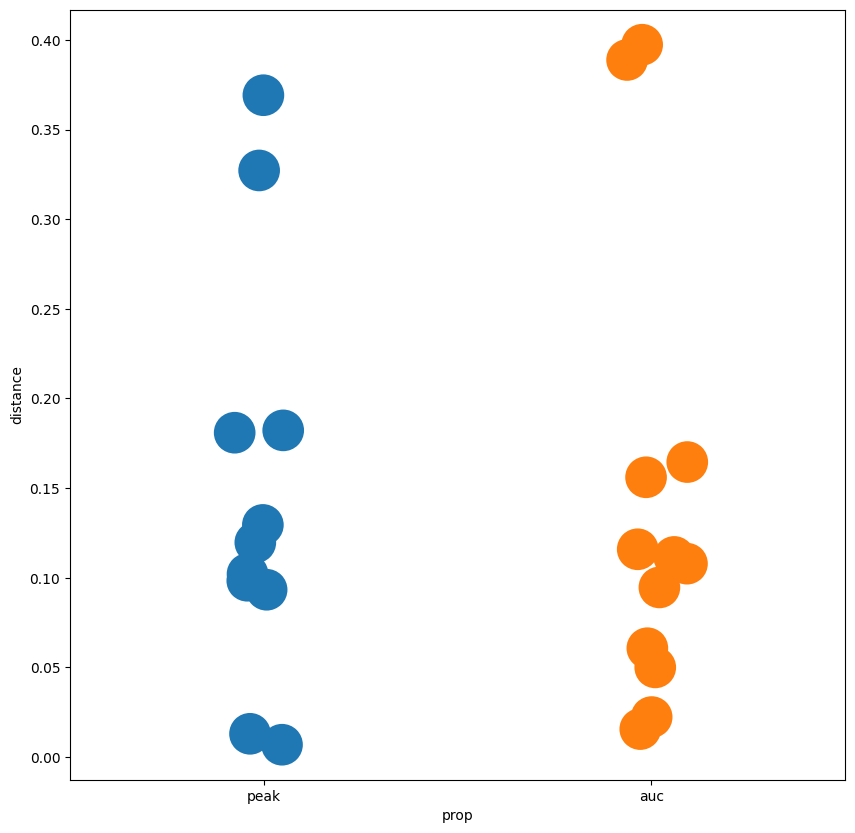

In [194]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
sns.stripplot(x='prop', y='distance', hue='prop', data=asymmetry_by_distance, ax=ax, s=30)

## Using polyfit to measure asymmetry

In [204]:
# skewness
import numpy as np
import matplotlib.pyplot as plt

def polyfit_asymmetry(pivotdf, cell_name_suffix, prop='peak', plot=False):
    # heatmap is the df obtained above
    heatmap = np.where(pivotdf > np.percentile(pivotdf,41), pivotdf, 0)
    # load from image
    # imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
    # image = Image.open(imagepath)
    # heatmap = np.array(image)
    # convert to grayscale if necessary
    if heatmap.ndim == 3:
        heatmap = heatmap.mean(axis=2)


    # -------------------------------------------
    # Step 2: Recentered PCA (Principal Component Analysis)
    # -------------------------------------------
    # Get the coordinates of non-zero intensity pixels (to focus on relevant data)
    coords = np.argwhere(heatmap > 0)

    # Get the corresponding intensities for those coordinates
    intensities = heatmap[coords[:, 0], coords[:, 1]]

    # Calculate the centroid (center of mass) of the heatmap, weighted by intensity
    centroid = np.average(coords, axis=0, weights=intensities)

    print(f"Centroid of the heat distribution (center of mass): {centroid}")

    # Recenter the coordinates by subtracting the centroid
    recentered_coords = coords - centroid

    # Prepare the data by weighting the recentered coordinates with the intensity
    # This ensures that higher intensity pixels contribute more to the PCA
    weighted_coords = recentered_coords * intensities[:, np.newaxis]

    # Perform PCA on the recentered and weighted coordinates
    pca = PCA(n_components=2)
    pca.fit(weighted_coords)

    # Extract the principal axes (directions of maximum variance)
    principal_axes = pca.components_

    # Explained variance: tells us how much of the variance is explained by each component
    explained_variance = pca.explained_variance_ratio_

    print("Principal Components (Directions of Heat Distribution):")
    print(principal_axes)

    print(f"\nExplained Variance by each component: {explained_variance}")
    # The first component explains most of the variance (~84%), showing the dominant orientation of the heat distribution

    # -------------------------------------------
    # Optional: Visualize the principal components on the heatmap
    # -------------------------------------------
    plt.figure(figsize=(8, 8))
    # Plot the heatmap
    plt.imshow(heatmap, cmap='magma')
    # Draw the centroid
    plt.scatter(centroid[1], centroid[0], color='red', label='Centroid', zorder=5)

    # Calculate the center of the image
    image_center = np.array(heatmap.shape) // 2

    # Scale the principal axes for visualization
    axis_length = 100  # Length of the axes to display

    # Draw the first principal axis (dominant direction of heat)
    plt.plot([centroid[1]-axis_length * principal_axes[0, 1], centroid[1] + axis_length * principal_axes[0, 1]],
            [centroid[0]-axis_length * principal_axes[0, 0], centroid[0] + axis_length * principal_axes[0, 0]],
            color='blue', label='1st Principal Component', linewidth=2)

    # Draw the second principal axis (secondary direction of heat)
    plt.plot([centroid[1]-axis_length * principal_axes[1, 1], centroid[1] + axis_length * principal_axes[1, 1]],
            [centroid[0]-axis_length * principal_axes[1, 0], centroid[0] + axis_length * principal_axes[1, 0]],
            color='green', label='2nd Principal Component', linewidth=2)

    # add annotation of explained variance
    plt.text(0.95, 0.05, f'Explained Variance: {explained_variance[1]/explained_variance[0]:.2f}', color='w', fontsize=20, ha='right', va='center', transform=plt.gca().transAxes)

    # Add legend and titles
    # plt.title("Heatmap with Principal Components (Recentered)")
    plt.legend(loc="upper right", fontsize=20)
    # limits
    plt.xlim(0, heatmap.shape[1])
    plt.ylim(heatmap.shape[0], 0)

    plt.axis('off')
    # title
    plt.title(f'Heatmap with Principal Components ({cell_name_suffix})')
    plt.tight_layout()

    # -------------------------------------------
    # Summary of Results:
    # - We now calculate the centroid (center of mass) of the heat distribution to account for off-center heat streaks.
    # - PCA is applied to recentered coordinates to detect the true orientation of the heat distribution.
    # - The principal components (blue and green lines) represent the dominant and secondary axes of heat spread.
    # -------------------------------------------
    # save fig
    plt.savefig(fig_folder / f'pca_heatmap_{cell_name_suffix}_{prop}.png')
    plt.savefig(fig_folder / f'pca_heatmap_{cell_name_suffix}_{prop}.svg')

    return explained_variance[1]/explained_variance[0]

Processing cell3_04_29
Centroid of the heat distribution (center of mass): [10.9959 12.6545]
Principal Components (Directions of Heat Distribution):
[[-0.6987  0.7154]
 [ 0.7154  0.6987]]

Explained Variance by each component: [0.7379 0.2621]
Centroid of the heat distribution (center of mass): [11.4289 12.4267]
Principal Components (Directions of Heat Distribution):
[[-0.7063  0.7079]
 [ 0.7079  0.7063]]

Explained Variance by each component: [0.7324 0.2676]
Processing cell2_13_29
Centroid of the heat distribution (center of mass): [10.0009 11.9707]
Principal Components (Directions of Heat Distribution):
[[ 0.9999  0.0151]
 [-0.0151  0.9999]]

Explained Variance by each component: [0.6132 0.3868]
Centroid of the heat distribution (center of mass): [11.2929 11.7591]
Principal Components (Directions of Heat Distribution):
[[ 0.9844  0.1761]
 [-0.1761  0.9844]]

Explained Variance by each component: [0.6729 0.3271]
Processing cell2_09a_10
Centroid of the heat distribution (center of mass)

C:\Users\adity\AppData\Local\Temp\ipykernel_39948\1671619696.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


Error in cell8_04_29: Weights sum to zero, can't be normalized


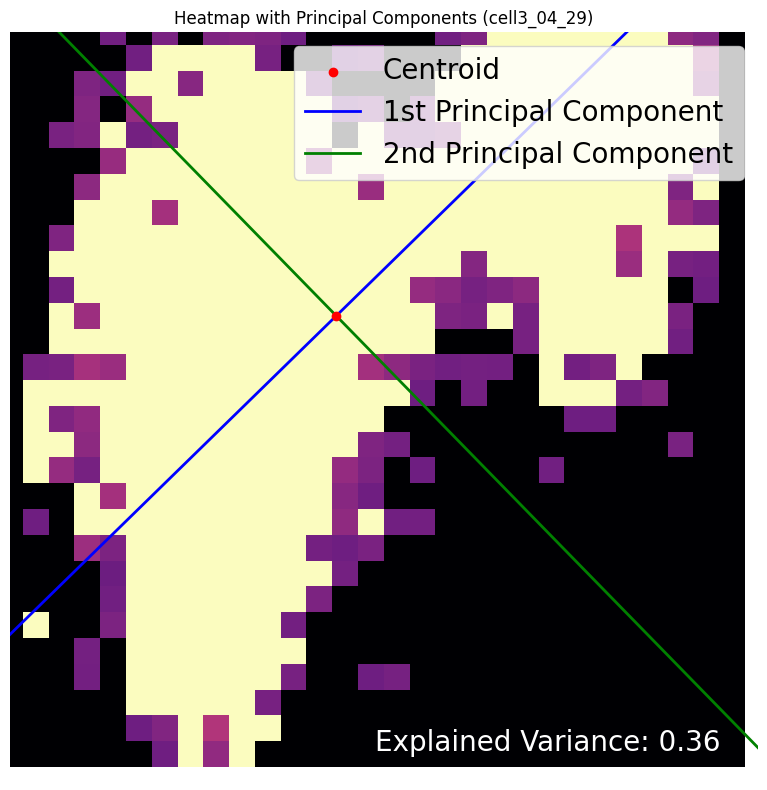

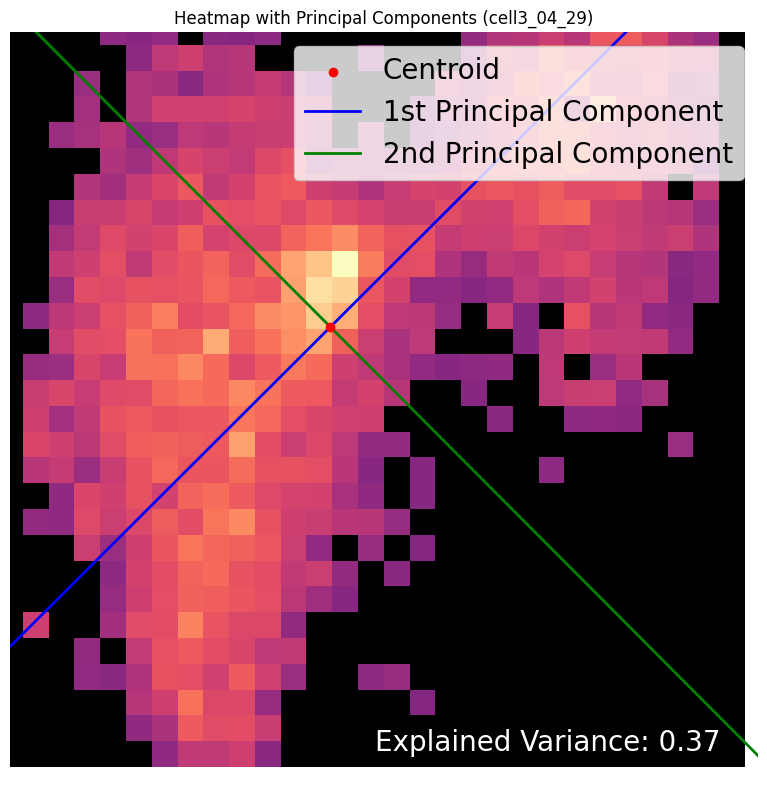

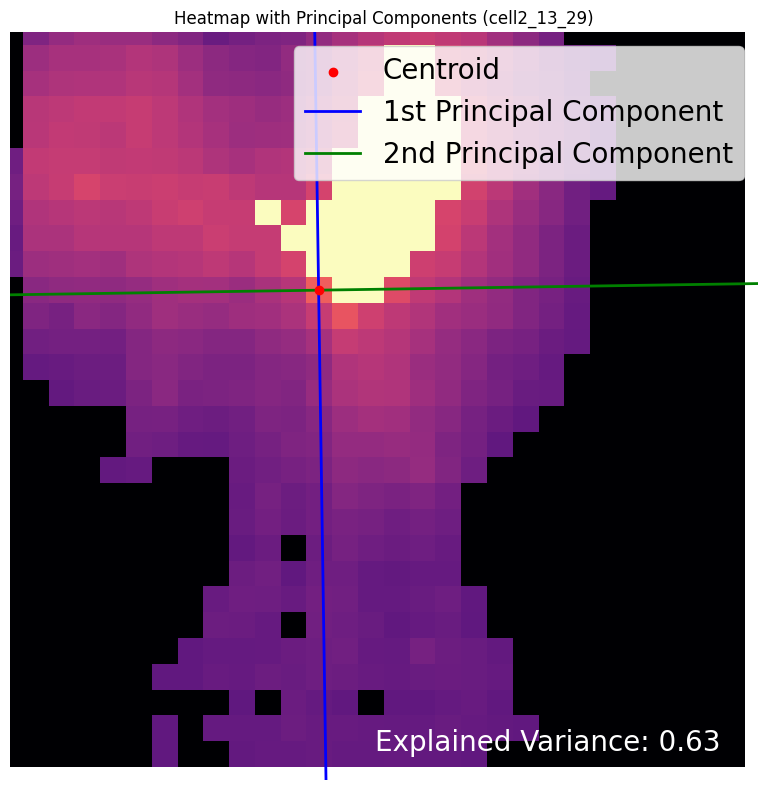

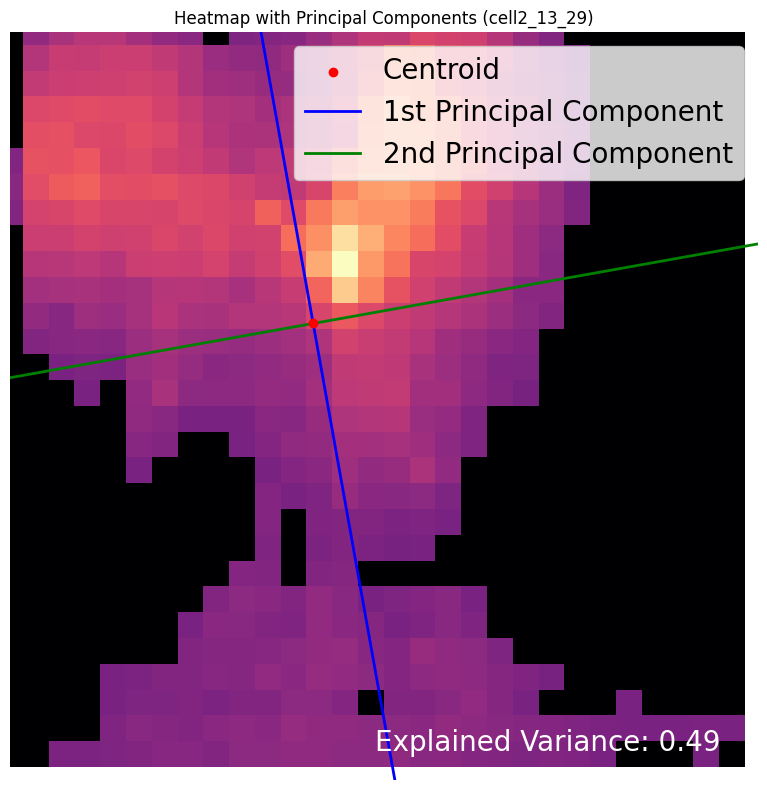

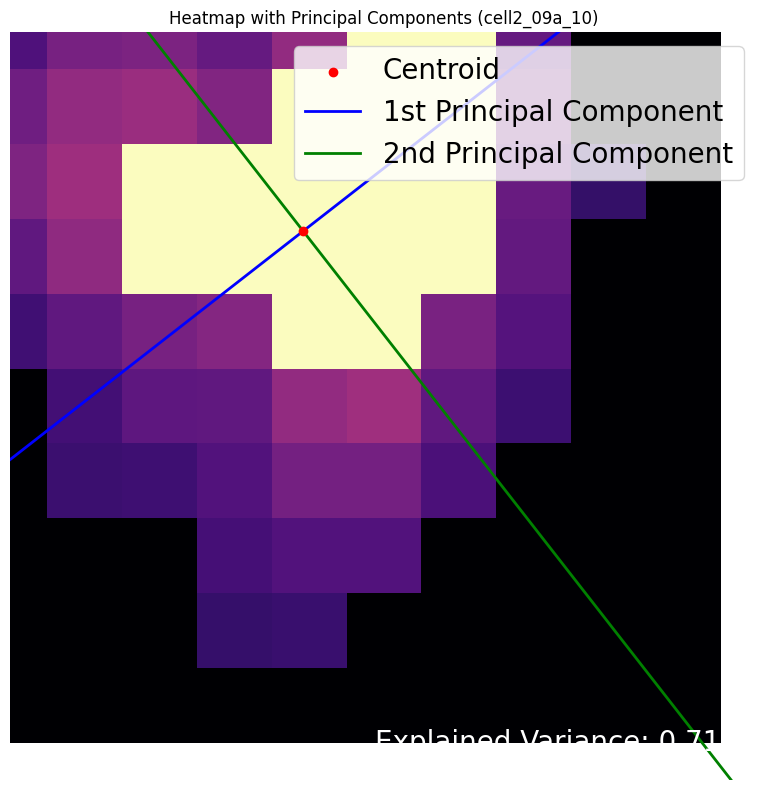

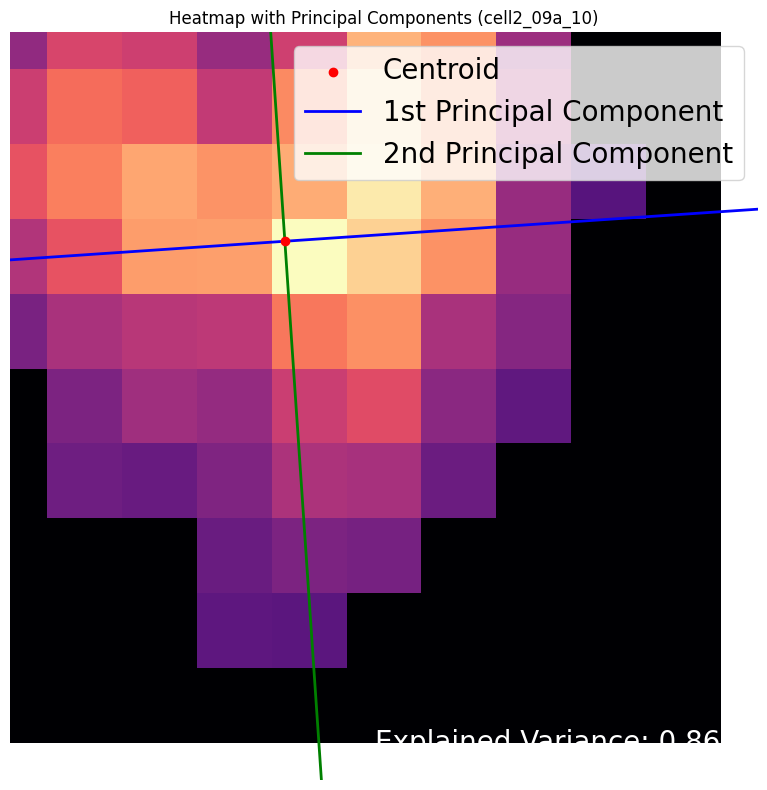

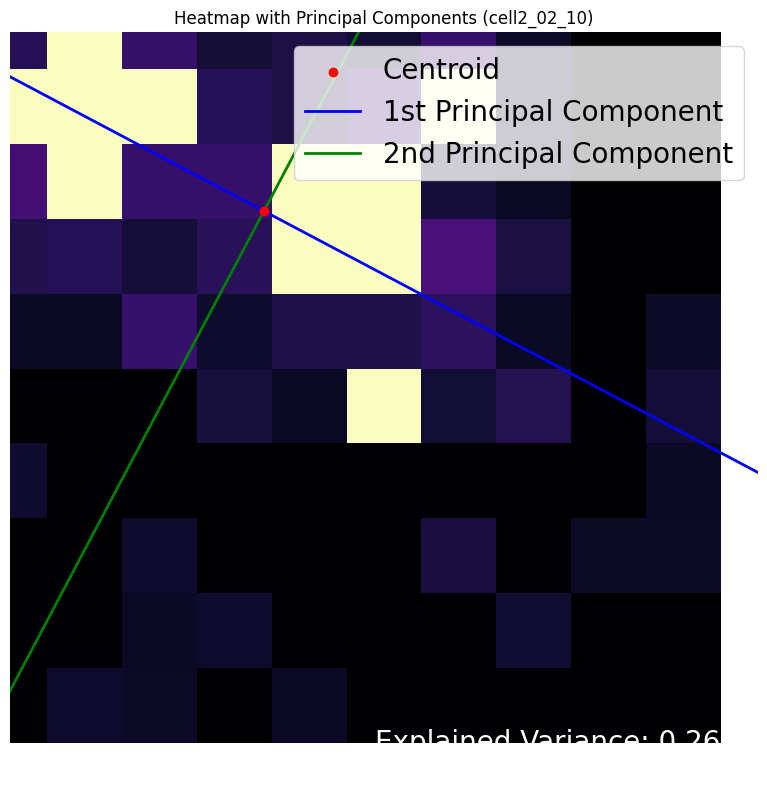

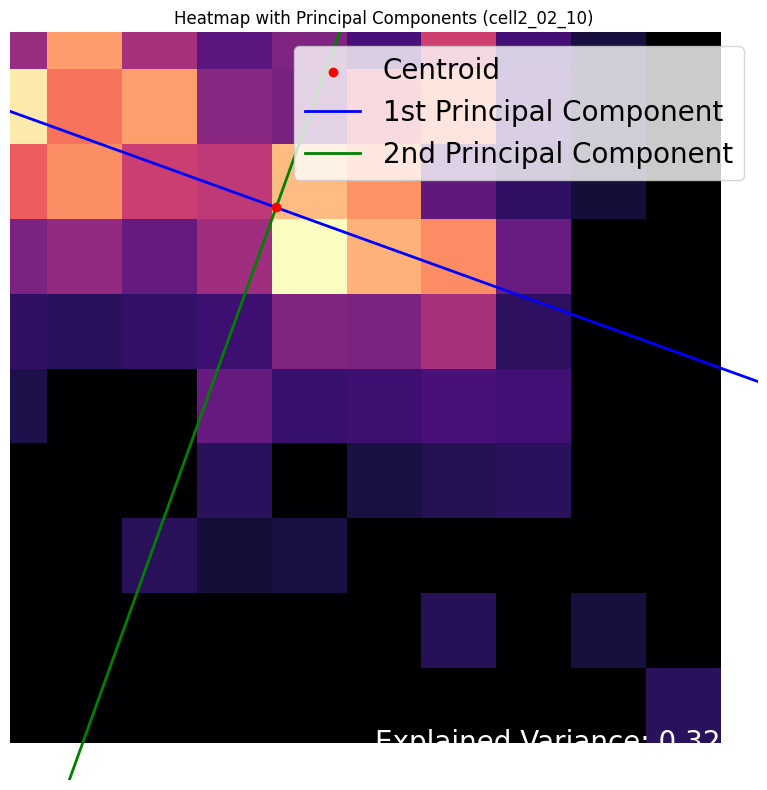

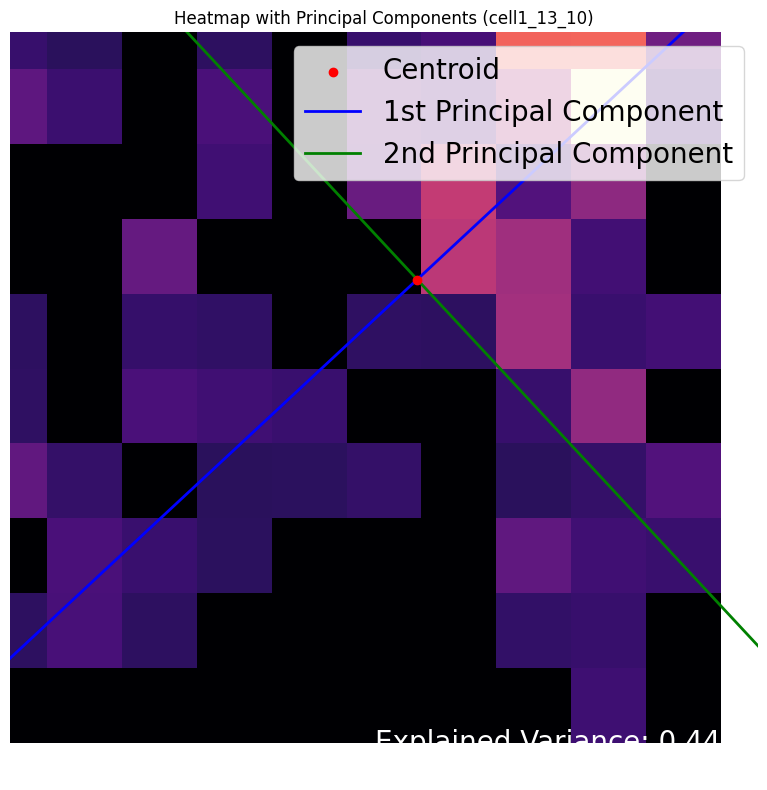

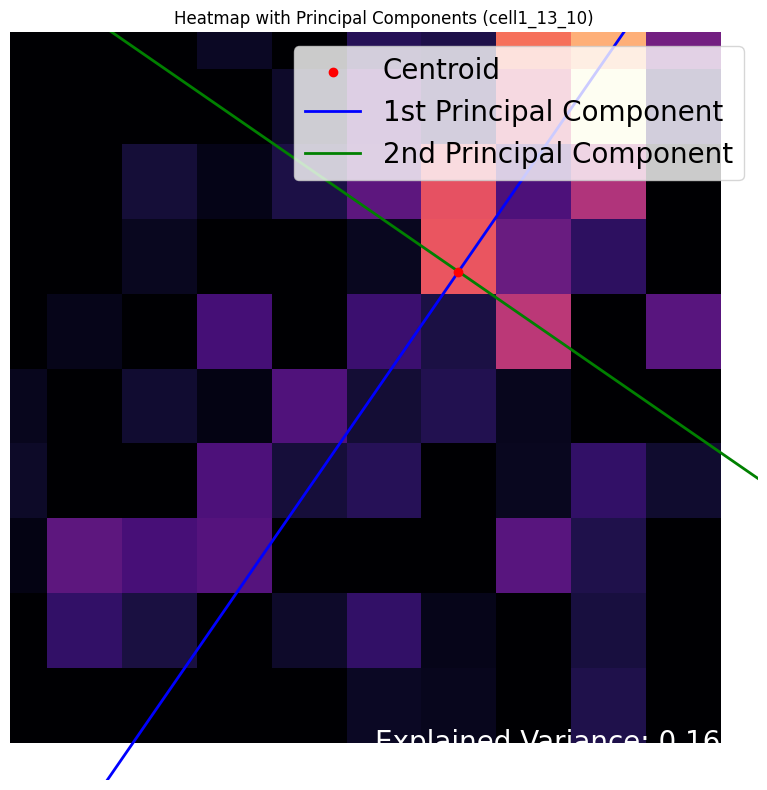

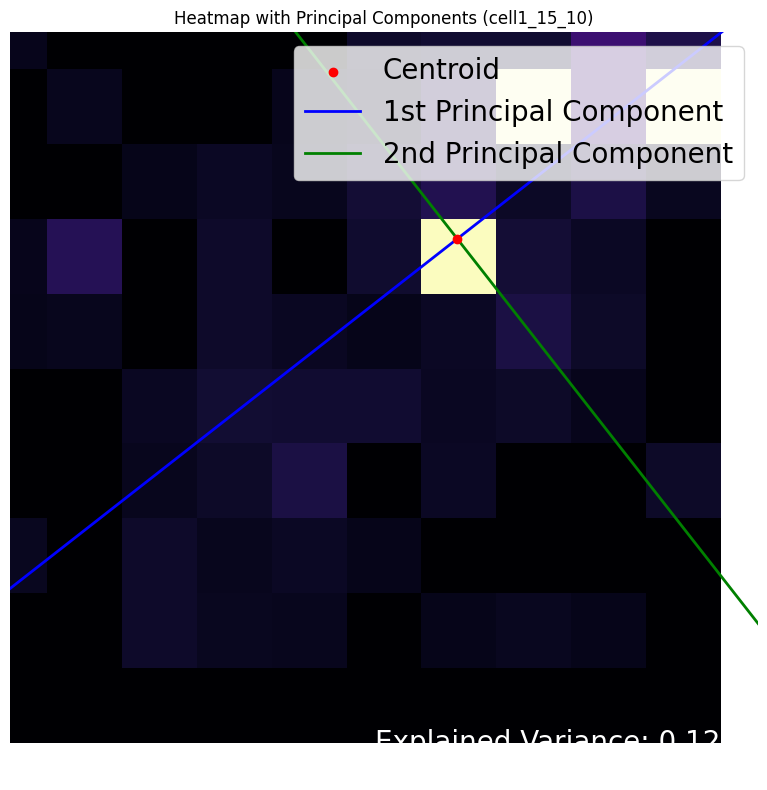

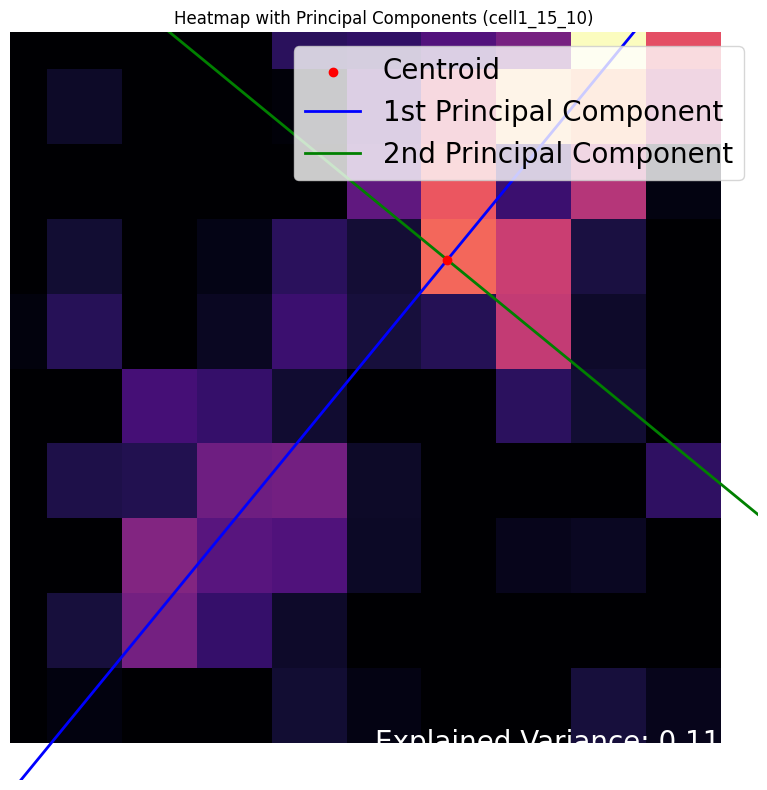

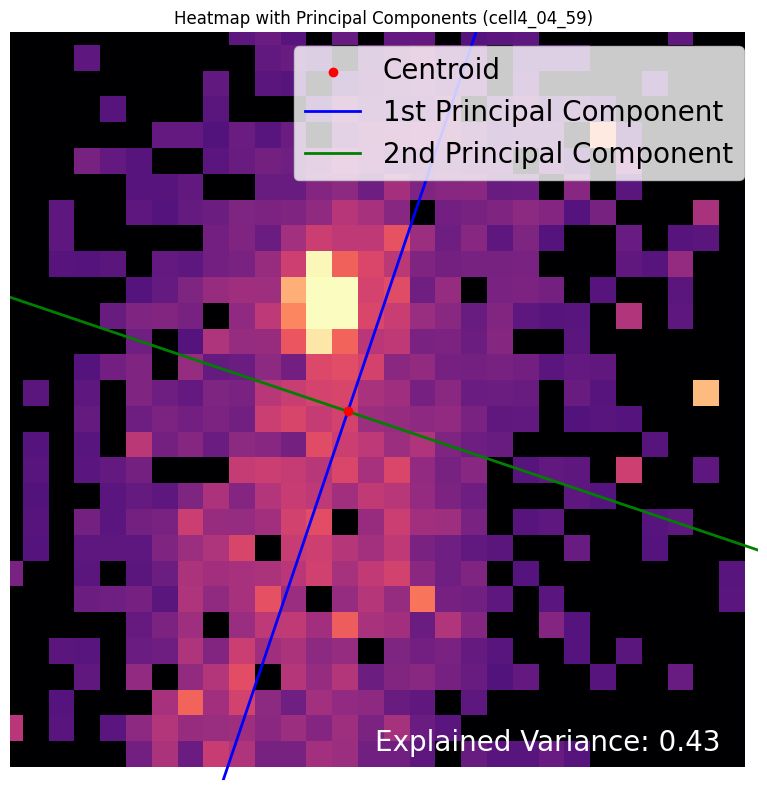

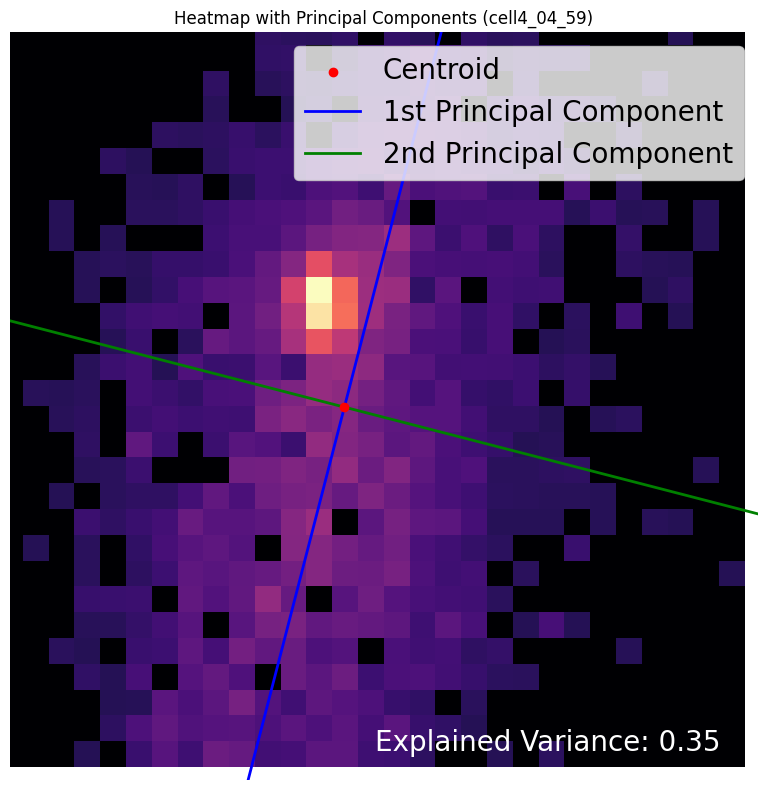

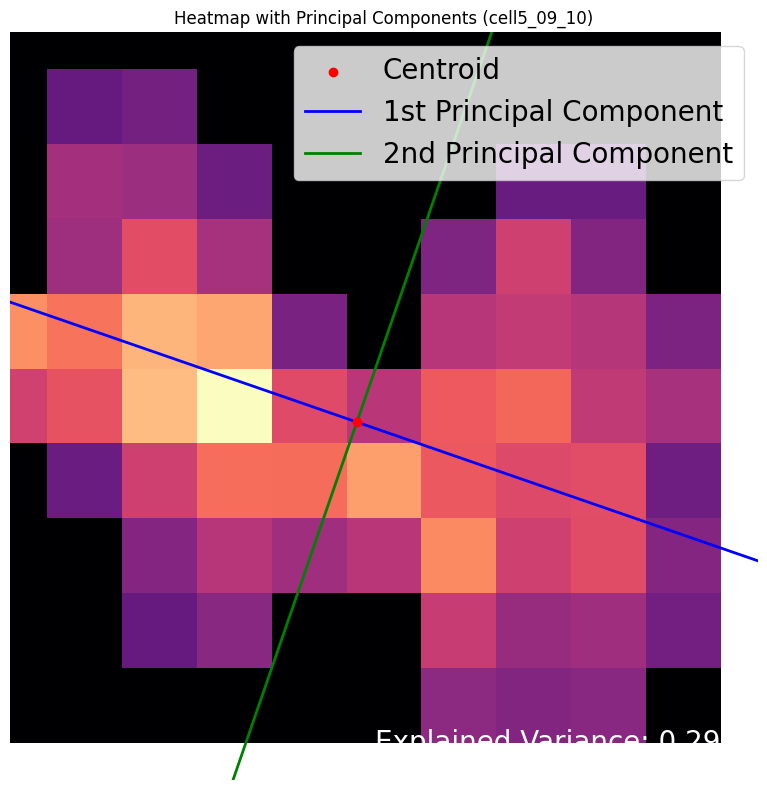

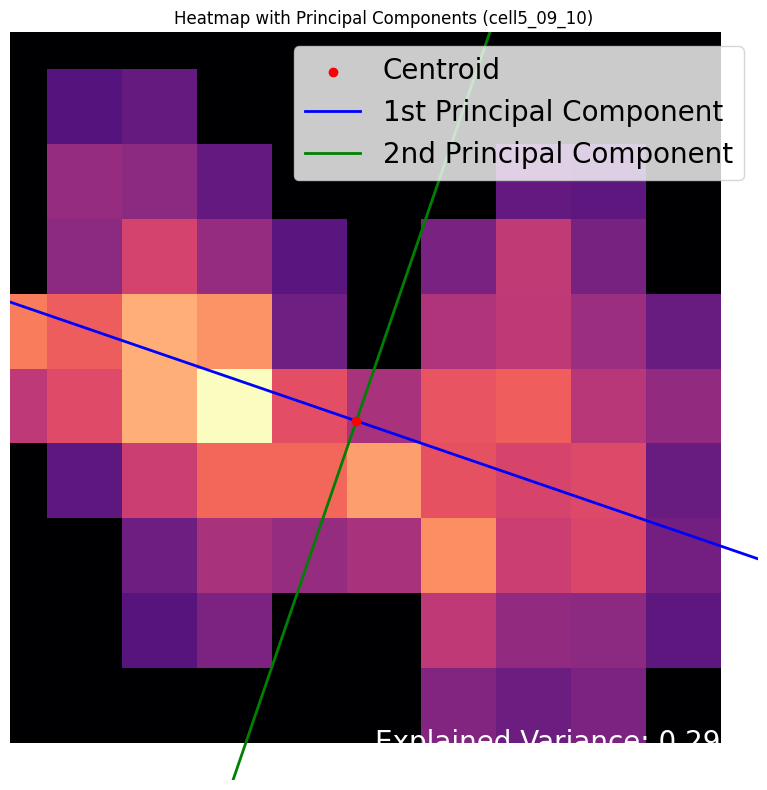

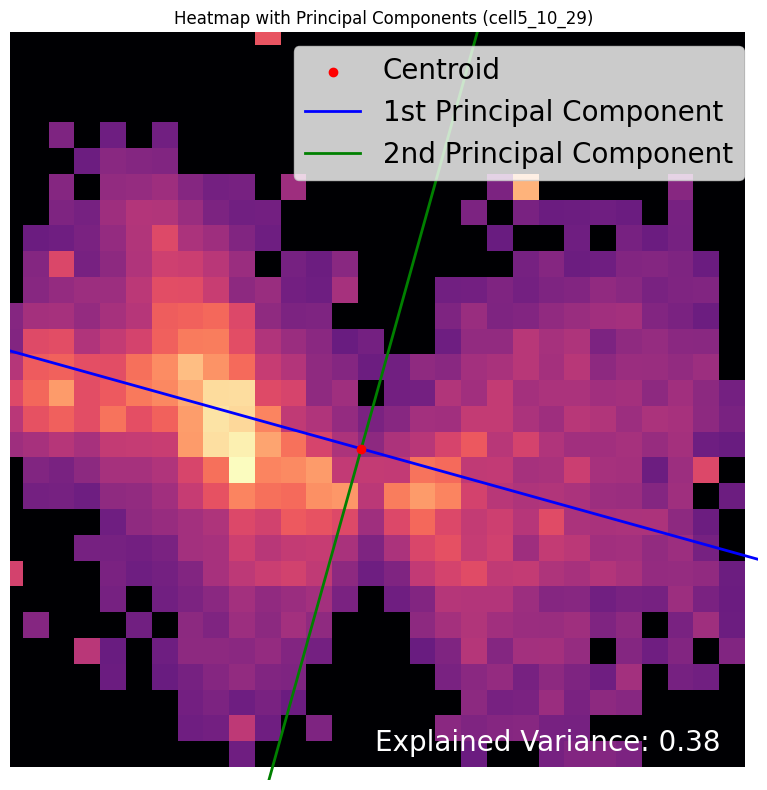

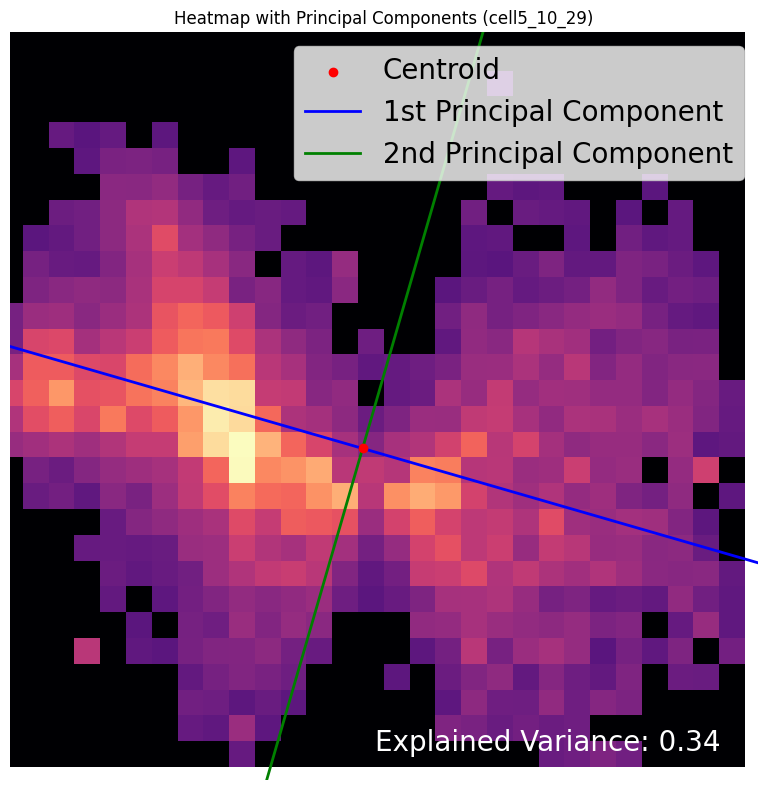

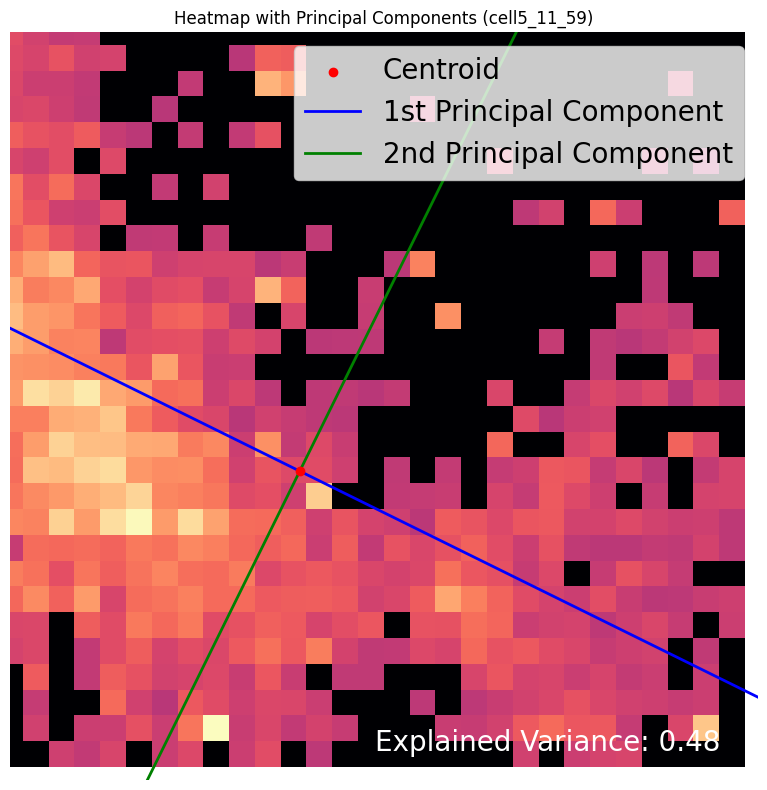

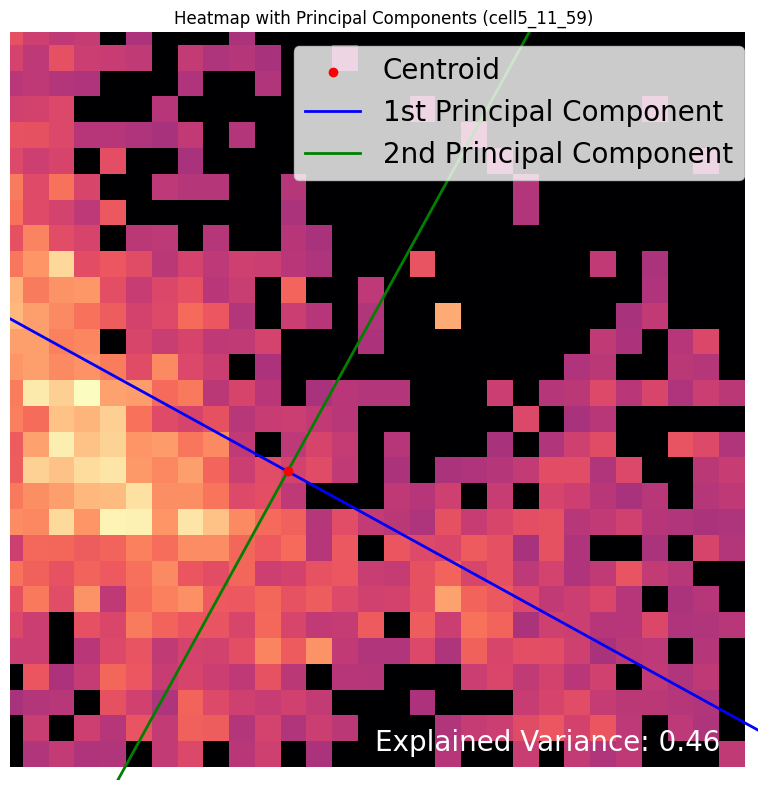

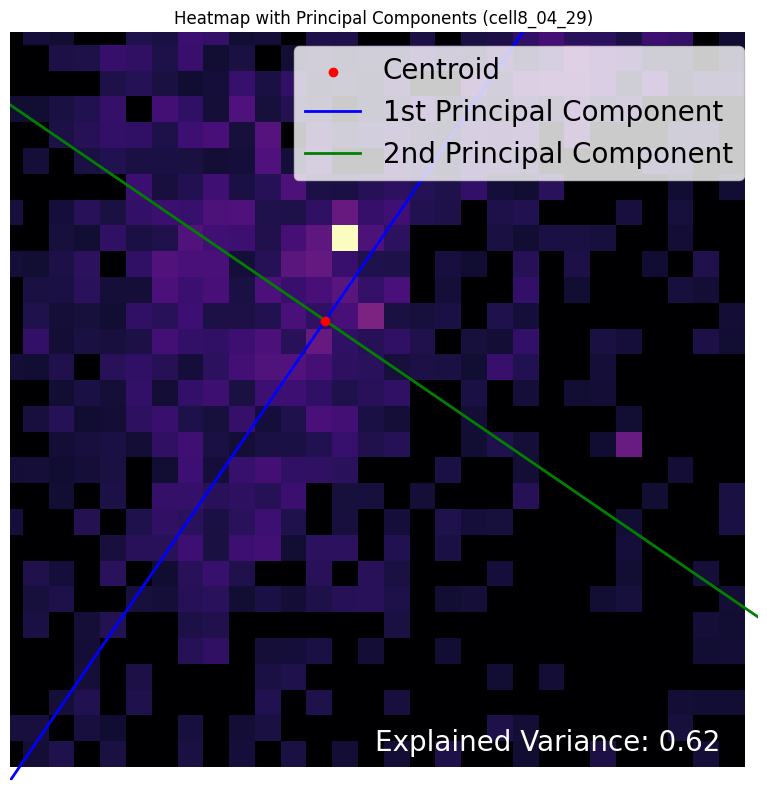

In [205]:
all_cells = []
for cell_name_suffix, cell_data in data.items():
    cell,expt,gridsize = cell_name_suffix.split('_')
    try:
        print(f'Processing {cell_name_suffix}')
        df = cell_data[2]
        exvar = polyfit_asymmetry(df, cell_name_suffix, prop='peak', plot=True)
        params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'peak', 'explained_variance_ratio':exvar}
        all_cells.append(params)
    except Exception as e:
        print(f"Error in {cell_name_suffix}: {e}")

    try:   
        df = cell_data[3]
        exvar = polyfit_asymmetry(df, cell_name_suffix, prop='auc', plot=True)
        params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'auc', 'explained_variance_ratio':exvar}
        all_cells.append(params)
    except Exception as e:
        print(f"Error in {cell_name_suffix}: {e}")

asymmetry_by_pca = pd.DataFrame(all_cells)

## Fit an ellipse

Use the covariance matrix of the coordinates (weighted by their intensity) to determine the major and minor axes of the ellipse.

'''
Great questions! Let’s dive into the details of how the covariance matrix, eigenvalues, and eigenvectors are used to fit the ellipse.

### 1. **Why use the covariance matrix of the coordinates (weighted by their intensity) to determine the major and minor axes of the ellipse?**

The covariance matrix provides key information about the **spread** (or variance) of data in different directions. In your case, we are working with spatial coordinates of the heatmap's intensity values. Here's why the covariance matrix is helpful:

- **Covariance** measures how much two variables (in this case, x and y coordinates of pixels) change together. In a two-dimensional dataset like an image, the covariance matrix summarizes how the data is distributed across the x and y axes.
  
- **Weighted by intensity**: Since pixel intensities represent the "heat" distribution, we weight the coordinates by their intensity. This ensures that areas with higher heat values contribute more to the spread of data, which is critical for fitting the ellipse around the "hot" regions.

- The **eigenvalues** of the covariance matrix correspond to the amount of variance along specific directions (these directions are the eigenvectors). The **larger the eigenvalue**, the more spread there is along that direction, which helps us define the major and minor axes of the ellipse.

- **In summary**: The covariance matrix tells us how the heat distribution is spread spatially. By using it, we can derive the orientation and elongation of the ellipse that best fits the spatial arrangement of the heat, based on its variance along different directions.

### 2. **Where and how is the actual fitting happening?**

There’s no explicit "curve fitting" function in the code like those used for fitting parametric curves. Instead, the ellipse fitting here is implicit and happens through **eigen decomposition** of the covariance matrix.

#### Here’s how this works:

- The **eigenvectors** of the covariance matrix give the **principal directions** (or axes) along which the data (the spatial distribution of the heat) is most spread out. These directions are essentially the orientation of the ellipse.

- The **eigenvalues** represent the amount of variance along each eigenvector direction. The square root of the eigenvalue gives the **length of the axis** corresponding to that eigenvector. In an ellipse, these are the lengths of the **major and minor axes**.

Thus, the **fitting** happens by:
1. Calculating the **covariance matrix** of the data points (weighted by their intensity).
2. Performing **eigen decomposition** on this matrix to get the **eigenvalues** and **eigenvectors**.
3. The **eigenvalues** give the lengths of the major and minor axes, while the **eigenvectors** give the direction (orientation) of these axes.

There’s no need for an explicit curve-fitting function because we’re not trying to fit a parametric curve to a dataset. Instead, we’re deriving the best-fitting ellipse directly from the spread of the data using the covariance matrix and eigen decomposition.

### Ellipse Fitting Intuition:
- Imagine you have a cloud of points (the heatmap's hot regions). If you wanted to fit an ellipse around this cloud:
  1. You'd find the two directions in which the points are most spread out (these are the eigenvectors).
  2. The amount of spread along each direction determines the size of the ellipse along those axes (eigenvalues).

This process effectively fits an ellipse by capturing the **spatial distribution** of the data, rather than relying on an explicit curve-fitting algorithm.

### Summary:
- **Covariance matrix**: Provides information on how the data (heatmap coordinates) is spread in 2D space.
- **Eigen decomposition**: Transforms the spread information into the axes and orientation of the best-fitting ellipse, using the eigenvalues (for axis lengths) and eigenvectors (for directions).
  
By leveraging the statistical properties of the data (via the covariance matrix and eigen decomposition), we're able to fit an ellipse around the heat distribution without needing to explicitly define a parametric ellipse and fit it.

'''

In [211]:
def asymmetry_by_ellipse(pivotdf, cell_name_suffix, prop='peak', plot=False):    
    # heatmap is the df obtained above
    heatmap = np.where(pivotdf > np.percentile(pivotdf,41), pivotdf, 0)
    # load from image
    # imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
    # image = Image.open(imagepath)
    # heatmap = np.array(image)
    # convert to grayscale if necessary
    if heatmap.ndim == 3:
        heatmap = heatmap.mean(axis=2)

    # -------------------------------------------
    # Step 1: Calculate the centroid (center of mass) of the heatmap
    # -------------------------------------------
    coords = np.argwhere(heatmap > 0)  # Get non-zero pixel coordinates
    intensities = heatmap[coords[:, 0], coords[:, 1]]  # Get corresponding intensities

    # Calculate the centroid (center of mass), weighted by intensity
    centroid = np.average(coords, axis=0, weights=intensities)

    # Recenter the coordinates by subtracting the centroid
    recentered_coords = coords - centroid

    # -------------------------------------------
    # Step 2: Covariance Matrix and Eigenvalues (Ellipse Fitting)
    # -------------------------------------------
    # Calculate the weighted covariance matrix of the recentered coordinates
    cov_matrix = np.cov(recentered_coords.T, aweights=intensities)

    # Eigen decomposition to get the axes of the ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and eigenvectors by the magnitude of the eigenvalues (to get major and minor axes)
    order = np.argsort(eigenvalues)[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Eigenvalues correspond to the squared lengths of the axes
    axis_lengths = 2 * np.sqrt(eigenvalues)  # Factor of 2 to get full lengths of the axes

    # Angle of the ellipse (from the first eigenvector)
    angle = np.degrees(np.arctan2(eigenvectors[0, 0], eigenvectors[1, 0]))

    # -------------------------------------------
    # Step 3: Plotting the ellipse over the heatmap
    # -------------------------------------------
    plt.figure(figsize=(8,8))
    # Plot the heatmap
    plt.imshow(heatmap, cmap='magma')

    # Plot the centroid
    plt.scatter(centroid[1], centroid[0], color='red', label='Centroid', zorder=5)

    # Plot the fitted ellipse
    ellipse = Ellipse(
        xy=(centroid[1], centroid[0]),  # Center of the ellipse (centroid)
        width=axis_lengths[0],  # Major axis length
        height=axis_lengths[1],  # Minor axis length
        angle=angle,  # Rotation of the ellipse
        edgecolor='cyan',
        fc='none',  # No fill
        lw=2,
        label='Fitted Ellipse'
    )
    # draw major and minor axes of the ellipse
    plt.plot([centroid[1]-axis_lengths[0] * eigenvectors[1, 0], centroid[1] + axis_lengths[0] * eigenvectors[1, 0]],
            [centroid[0]-axis_lengths[0] * eigenvectors[0, 0], centroid[0] + axis_lengths[0] * eigenvectors[0, 0]],
            color='blue', label='Major Axis', linewidth=2)

    plt.plot([centroid[1]-axis_lengths[1] * eigenvectors[1, 1], centroid[1] + axis_lengths[1] * eigenvectors[1, 1]],
            [centroid[0]-axis_lengths[1] * eigenvectors[0, 1], centroid[0] + axis_lengths[1] * eigenvectors[0, 1]],
            color='green', label='Minor Axis', linewidth=2)
    plt.gca().add_patch(ellipse)

    # Add legend and titles
    # plt.title("Fitted Ellipse on Heatmap")
    plt.legend(loc="upper right", fontsize=20)
    # xlim
    plt.xlim(0, heatmap.shape[1])
    plt.ylim(heatmap.shape[0], 0)

    plt.axis('off')
    plt.tight_layout()


    # Output the results (axis lengths and orientation)
    print(f"Major Axis Length: {axis_lengths[0]:.2f}")
    print(f"Minor Axis Length: {axis_lengths[1]:.2f}")
    print(f"Orientation (angle): {angle:.2f} degrees")
    print(f"Major / Minor Axis Ratio: {axis_lengths[0] / axis_lengths[1]:.2f}")

    # save fig
    plt.savefig(fig_folder / f'ellipse_fit_29x29_{cell_name_suffix}_{prop}.png')
    plt.savefig(fig_folder / f'ellipse_fit_29x29_{cell_name_suffix}_{prop}.svg')

    eccentricity = np.sqrt(1 - (axis_lengths[1] / axis_lengths[0]) ** 2)

    return angle, eccentricity

In [212]:
def asymmetry_by_distribution(pivotdf, cell_name_suffix, prop='peak', plot=False):
        # heatmap is the df obtained above
        heatmap = np.where(pivotdf > np.percentile(pivotdf,50), pivotdf, 0)
        # load from image
        # imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
        # image = Image.open(imagepath)
        # heatmap = np.array(image)
        # convert to grayscale if necessary
        if heatmap.ndim == 3:
                heatmap = heatmap.mean(axis=2)

        # -------------------------------------------
        # Step 1: Calculate the centroid (center of mass) of the heatmap
        # -------------------------------------------
        coords = np.argwhere(heatmap > 0)  # Get non-zero pixel coordinates
        intensities = heatmap[coords[:, 0], coords[:, 1]]  # Get corresponding intensities

        # Calculate the centroid (center of mass), weighted by intensity
        centroid = np.average(coords, axis=0, weights=intensities)

        # Recenter the coordinates by subtracting the centroid
        recentered_coords = coords - centroid

        # -------------------------------------------
        # Step 2: Apply PCA to find the major and minor axes
        # -------------------------------------------
        # Prepare the data by weighting the coordinates with the intensity
        weighted_coords = recentered_coords * intensities[:, np.newaxis]

        # Perform PCA on the recentered and weighted coordinates
        pca = PCA(n_components=2)
        pca.fit(weighted_coords)

        # Get the major (first component) and minor (second component) axes
        major_axis = pca.components_[0]  # Major axis (east-west)
        minor_axis = pca.components_[1]  # Minor axis (north-south)

        # -------------------------------------------
        # Step 3: Project points onto the major and minor axes and calculate asymmetry
        # -------------------------------------------

        # Normalize the axes
        major_axis = major_axis / np.linalg.norm(major_axis)
        minor_axis = minor_axis / np.linalg.norm(minor_axis)

        # 1. Project each point onto the major axis (for north-south asymmetry)
        major_projections = np.dot(recentered_coords, major_axis)

        # 2. Project each point onto the minor axis (for east-west asymmetry)
        minor_projections = np.dot(recentered_coords, minor_axis)

        # -------------------------------------------
        # Major Axis (North-South) Asymmetry
        # -------------------------------------------
        # Split the data into two halves (north vs. south)
        north_side_indices = major_projections > 0  # Points above the major axis (north)
        south_side_indices = major_projections < 0  # Points below the major axis (south)

        # Calculate the total heat (intensity) on each side of the major axis
        north_side_heat_major = np.sum(intensities[north_side_indices])
        south_side_heat_major = np.sum(intensities[south_side_indices])

        # Calculate percentage asymmetry for major axis (north vs. south)
        total_heat_major = north_side_heat_major + south_side_heat_major
        asymmetry_major = abs(north_side_heat_major - south_side_heat_major) / total_heat_major * 100

        # -------------------------------------------
        # Minor Axis (East-West) Asymmetry
        # -------------------------------------------
        # Split the data into two halves (east vs. west)
        east_side_indices = minor_projections > 0  # Points on the east side
        west_side_indices = minor_projections < 0  # Points on the west side

        # Calculate the total heat (intensity) on each side of the minor axis
        east_side_heat_minor = np.sum(intensities[east_side_indices])
        west_side_heat_minor = np.sum(intensities[west_side_indices])

        # Calculate percentage asymmetry for minor axis (east vs. west)
        total_heat_minor = east_side_heat_minor + west_side_heat_minor
        asymmetry_minor = abs(east_side_heat_minor - west_side_heat_minor) / total_heat_minor * 100

        # -------------------------------------------
        # Output the asymmetry results
        # -------------------------------------------
        print(f"Major Axis (North-South) Asymmetry: {asymmetry_major:.2f}%")
        print([north_side_heat_major , south_side_heat_major])
        print(f"Minor Axis (East-West) Asymmetry: {asymmetry_minor:.2f}%")
        print([east_side_heat_minor , west_side_heat_minor])

        # -------------------------------------------
        # Optional: Plot the results
        # -------------------------------------------
        fig, ax = plt.subplots(figsize=(8,8))

        # Plot the heatmap in the background
        ax.imshow(heatmap, cmap='magma')

        # Plot the major axis (cyan) and minor axis (red dashed)
        axis_length = 100  # Length of the axis for display purposes
        ax.plot([centroid[1]-axis_length * major_axis[1], centroid[1] + axis_length * major_axis[1]],
                [centroid[0]-axis_length * major_axis[0], centroid[0] + axis_length * major_axis[0]],
                color='cyan', label='Major Axis', linewidth=2)

        ax.plot([centroid[1]-axis_length * minor_axis[1], centroid[1] + axis_length * minor_axis[1]],
                [centroid[0]-axis_length * minor_axis[0], centroid[0] + axis_length * minor_axis[0]],
                color='red', linestyle='dashed', label='Minor Axis', linewidth=2)

        # Add legend and show the plot
        ax.legend(loc='upper right', fontsize=20)
        plt.title("Major and Minor Axes on Heatmap")
        plt.xlim(0, heatmap.shape[1])
        plt.ylim(heatmap.shape[0], 0)
        plt.legend(fontsize=12)

        ax.axis('off')
        plt.tight_layout()


        # save fig
        fig.savefig(fig_folder / f'asymmetry_major_minor_axes_thresholded_{cell_name_suffix}_{prop}.png')
        fig.savefig(fig_folder / f'asymmetry_major_minor_axes_thresholded_{cell_name_suffix}_{prop}.svg')

        east = pd.Series( np.abs(intensities[east_side_indices]) )
        west = pd.Series( np.abs(intensities[west_side_indices]) )
        north = pd.Series( np.abs(intensities[north_side_indices]) )
        south = pd.Series( np.abs(intensities[south_side_indices]) )
        print('shapes: ', east.shape, west.shape, north.shape, south.shape)
        # make a dataframe
        distdf = pd.DataFrame({'east':east, 'west':west, 'north':north, 'south':south}, )
        # pivot
        distdf = distdf.melt(var_name='direction', value_name='intensity')
        # add a column for the axis
        distdf['axis'] = distdf['direction'].apply(lambda x: 'major' if x in ['north', 'south'] else 'minor')

        fig, ax= plt.subplots(1,1, figsize=(8,8))
        # sns.violinplot(x='axis', y='intensity', data=distdf, hue='direction', split=True, inner='quart', palette='tab20', dodge=True, ax=ax)

        # calculate skewness for the four distributions
        print('Skewness of the distributions: ')
        print('East: ', skew(east))
        print('West: ', skew(west))
        print('North: ', skew(north))
        print('South: ', skew(south))

        # stat across the two sides
        import stat_annotate
        from scipy.stats import kruskal
        importlib.reload(stat_annotate)
        vp = stat_annotate.pairwise_draw_and_annotate_line_plot(ax, distdf, x='axis', y='intensity', hue='direction', draw=True, kind='violin', palette='viridis', split_violins=True, dodge=False,
                                                        stat_across='hue', stat=kruskal, skip_first_xvalue=False, annotate_wrt_data=False, offset_btw_star_n_line=0.1,
                                                        color='grey', coord_system='data', fontsize=12, zorder=10, add_n=False, gap=0.1 ,native_scale=True)
                                                        
        # change tick positions on x-axis
        vp.set_xticks([-0.2,1.2])
        vp.set_xticklabels(['Minor Axis', 'Major Axis'])

        # despine
        sns.despine(ax=ax, offset=10, trim=True, top=True, right=True)

        # 3 save fig
        fig.savefig(fig_folder / f'asymmetry_across_PCAaxes_violinplot_29x29_{cell_name_suffix}_{prop}.png')
        fig.savefig(fig_folder / f'asymmetry_across_PCAaxes_violinplot_29x29_{cell_name_suffix}_{prop}.svg')                                               

        return asymmetry_major, asymmetry_minor

Processing cell3_04_29
Major Axis Length: 16.93
Minor Axis Length: 10.43
Orientation (angle): -44.29 degrees
Major / Minor Axis Ratio: 1.62
Major Axis (North-South) Asymmetry: 0.78%
[np.float64(5865.21875), np.float64(5957.3304443359375)]
Minor Axis (East-West) Asymmetry: 5.76%
[np.float64(6251.87255859375), np.float64(5570.6766357421875)]
shapes:  (222,) (198,) (208,) (212,)
Skewness of the distributions: 
East:  -2.618692018998286
West:  -2.573107319386998
North:  -2.6608734199122526
South:  -2.536658112214249
xvalues = ['minor' 'major'], hue_values = ['east' 'west' 'north' 'south']
0.0008727992305262416 0.9764313847254739
Comparison # 0, x = minor, statistic=0.0008727992305262416, pval=0.9764313847254739
0.033776656429173366 0.8541826998011011
Comparison # 1, x = major, statistic=0.033776656429173366, pval=0.8541826998011011
Major Axis Length: 16.95
Minor Axis Length: 10.72
Orientation (angle): -44.53 degrees
Major / Minor Axis Ratio: 1.58
Major Axis (North-South) Asymmetry: 6.61%
[

C:\Users\adity\AppData\Local\Temp\ipykernel_39948\910555253.py:135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax= plt.subplots(1,1, figsize=(8,8))


Major Axis Length: 4.90
Minor Axis Length: 3.44
Orientation (angle): 25.84 degrees
Major / Minor Axis Ratio: 1.42
Major Axis (North-South) Asymmetry: 8.34%
[np.float64(4.434529663085938), np.float64(3.751868621826172)]
Minor Axis (East-West) Asymmetry: 11.57%
[np.float64(3.619639953613281), np.float64(4.566758331298827)]
shapes:  (27,) (23,) (30,) (20,)
Skewness of the distributions: 
East:  1.3774847786057474
West:  0.2409983312824006
North:  1.0431912524667735
South:  0.3990017549300995
xvalues = ['minor' 'major'], hue_values = ['east' 'west' 'north' 'south']
7.8023112626693205 0.005217944915776077
Comparison # 0, x = minor, statistic=7.8023112626693205, pval=0.005217944915776077
3.614117647058805 0.05729110493013656
Comparison # 1, x = major, statistic=3.614117647058805, pval=0.05729110493013656
Processing cell1_13_10
Major Axis Length: 6.05
Minor Axis Length: 4.89
Orientation (angle): -34.20 degrees
Major / Minor Axis Ratio: 1.24
Major Axis (North-South) Asymmetry: 18.31%
[np.float

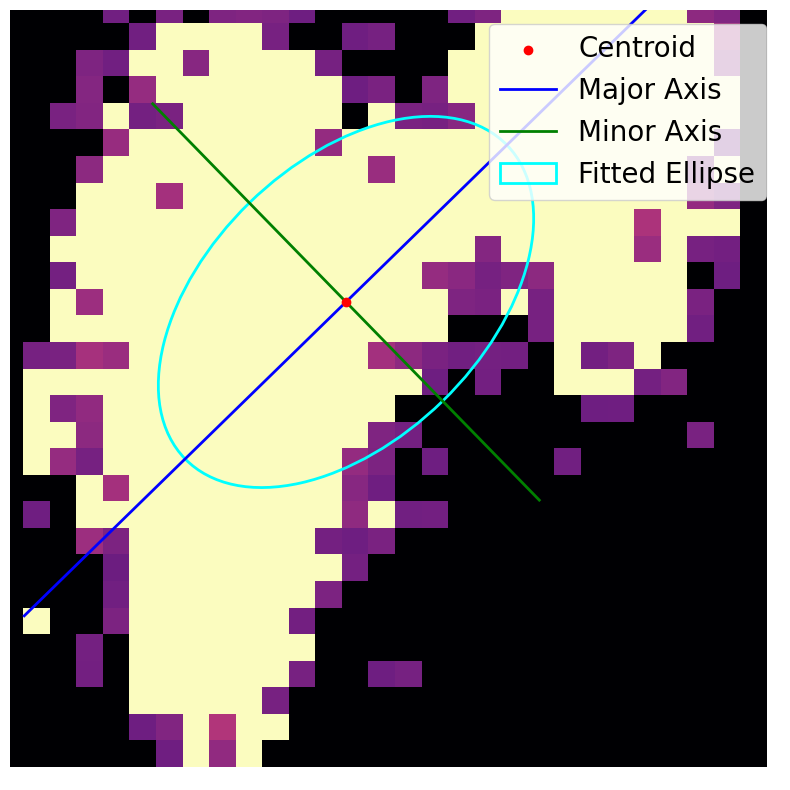

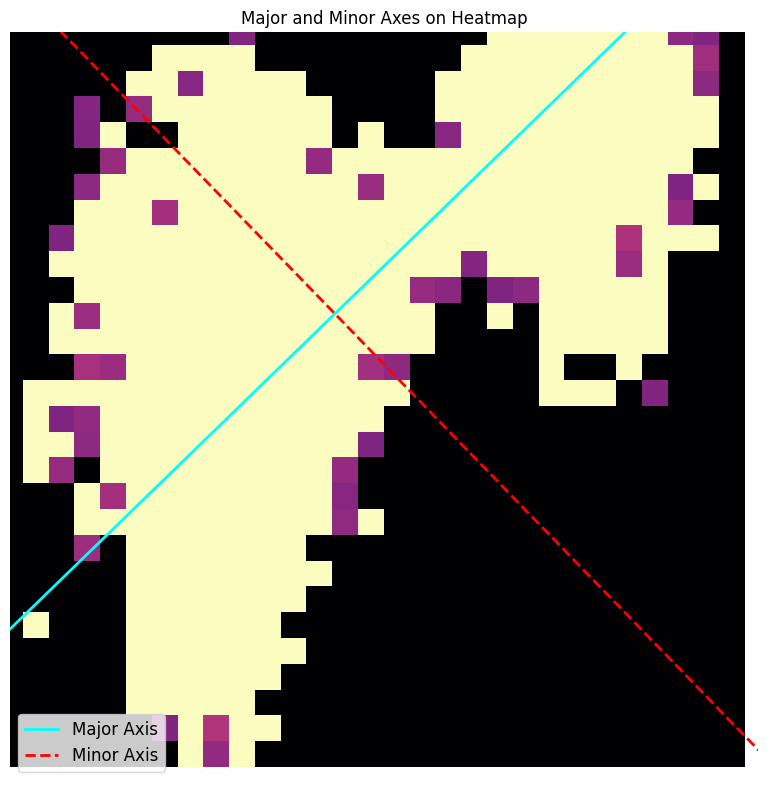

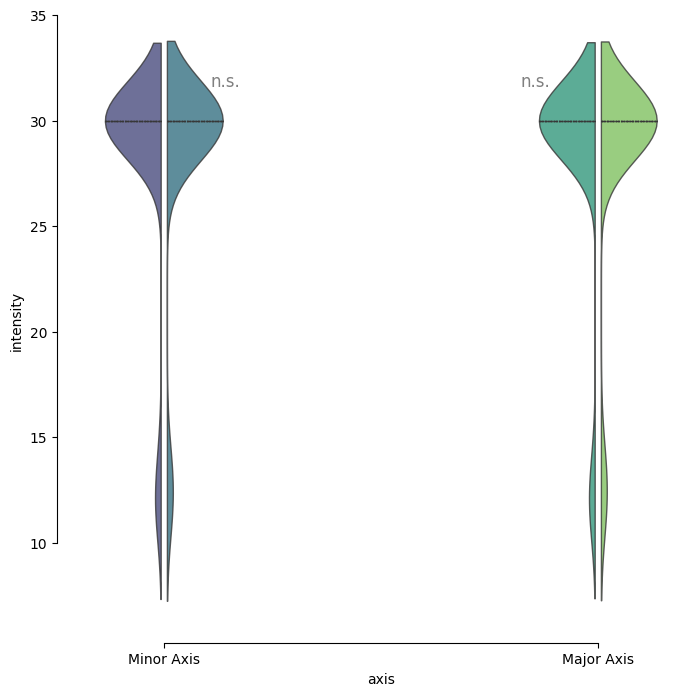

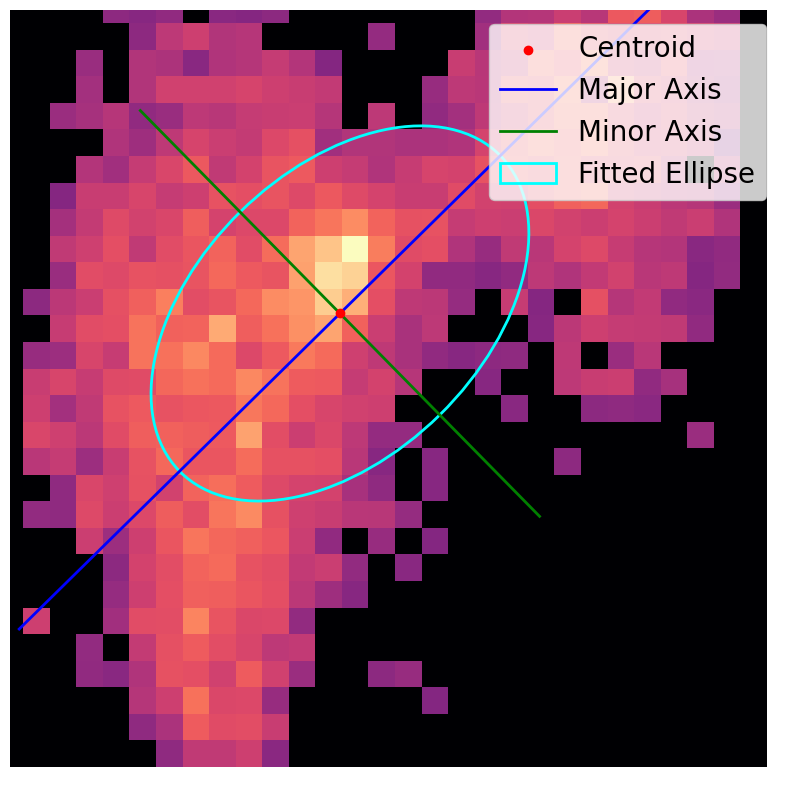

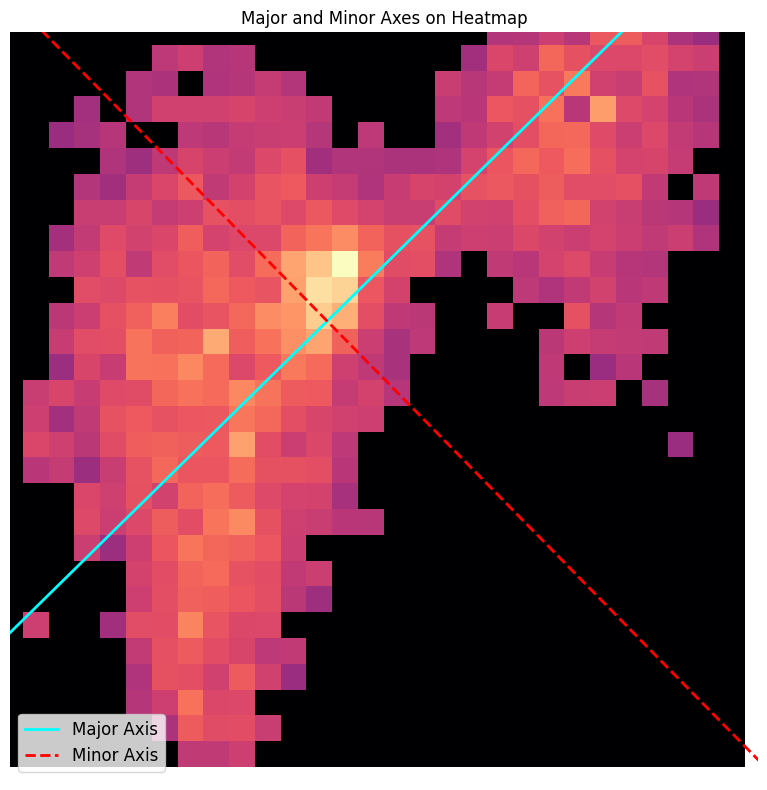

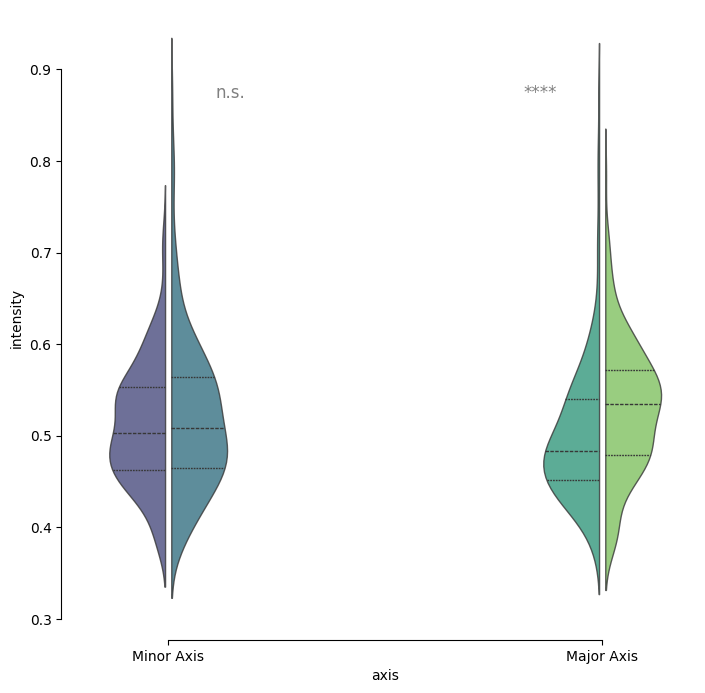

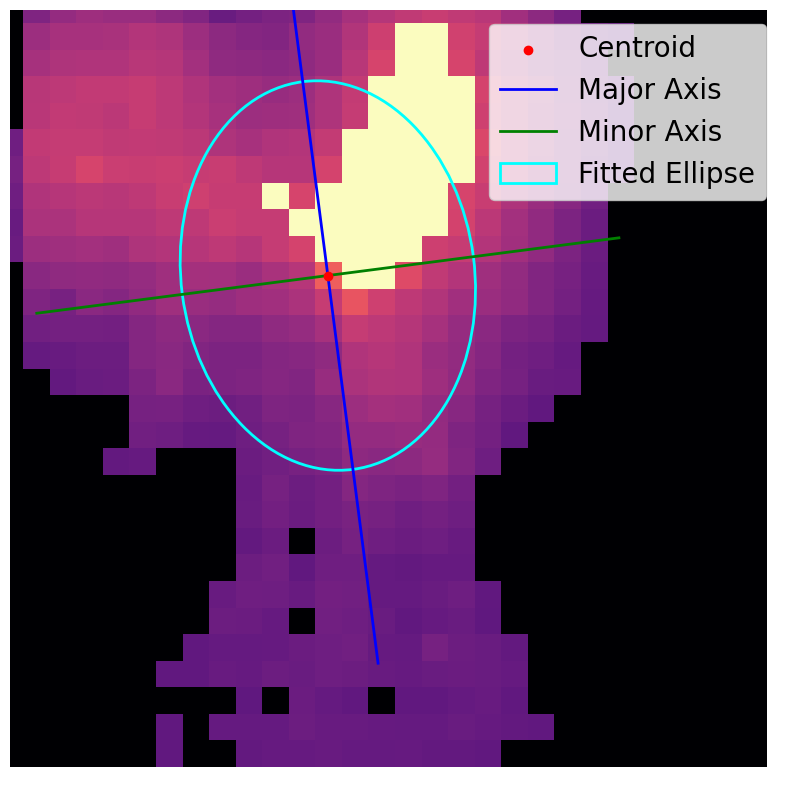

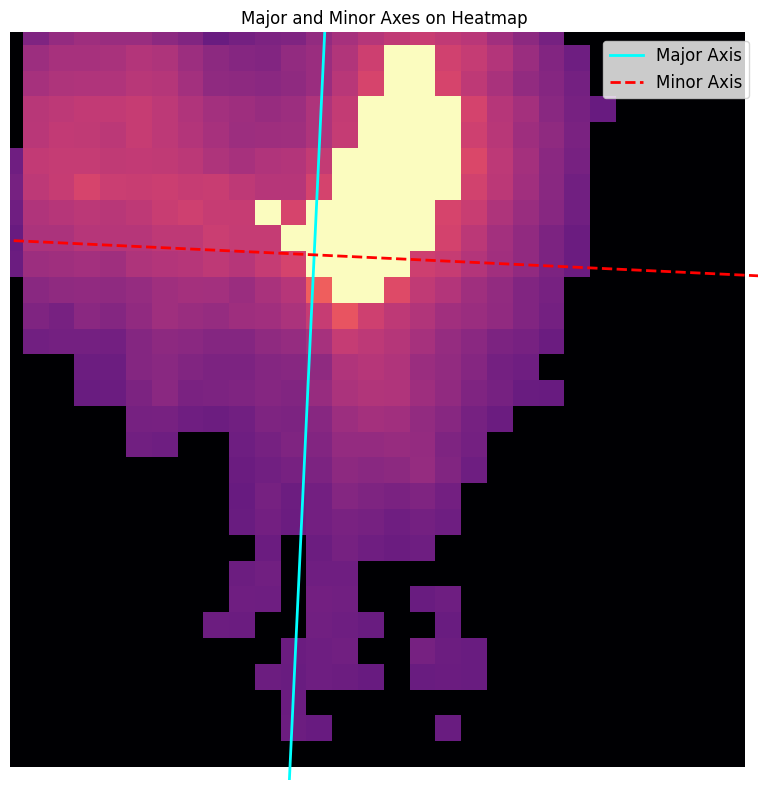

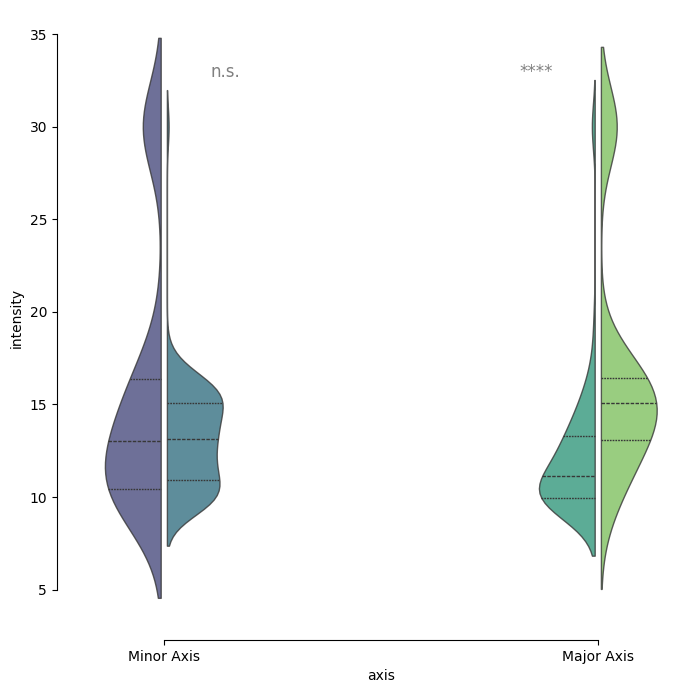

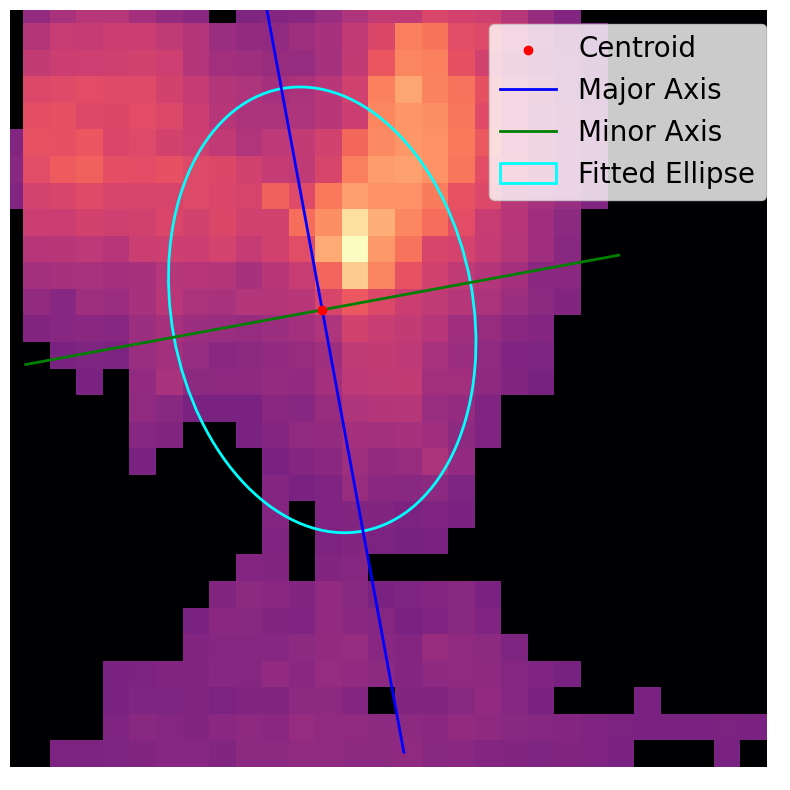

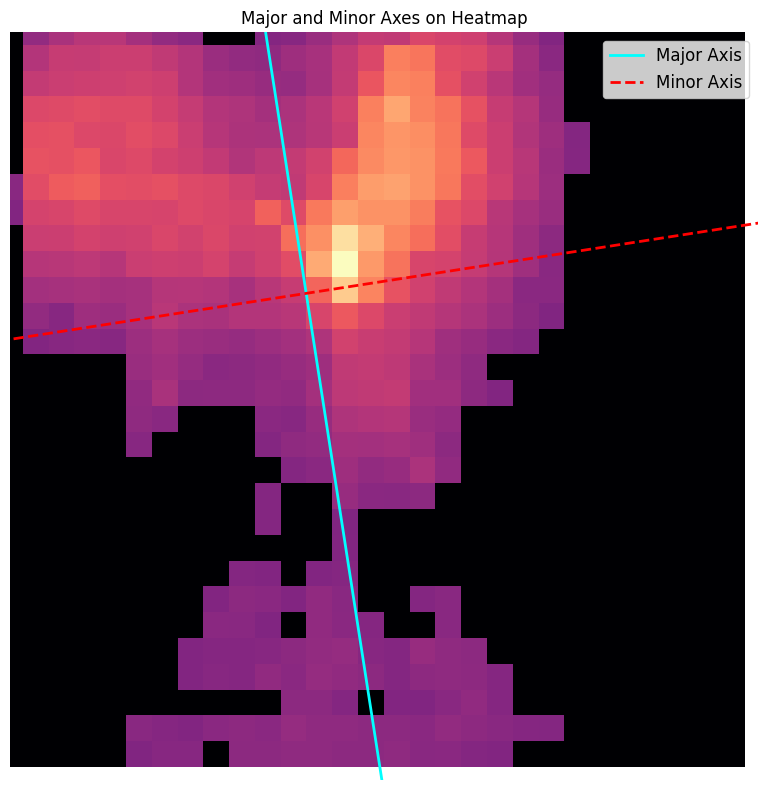

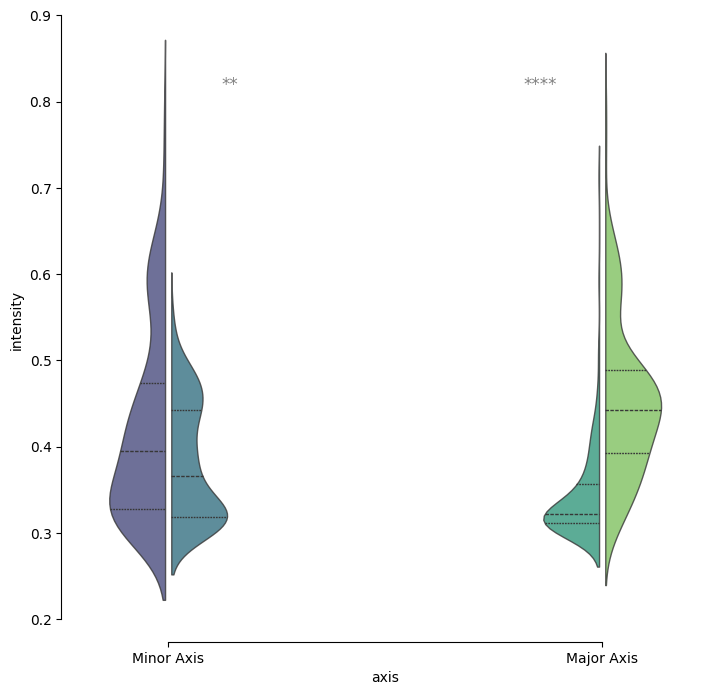

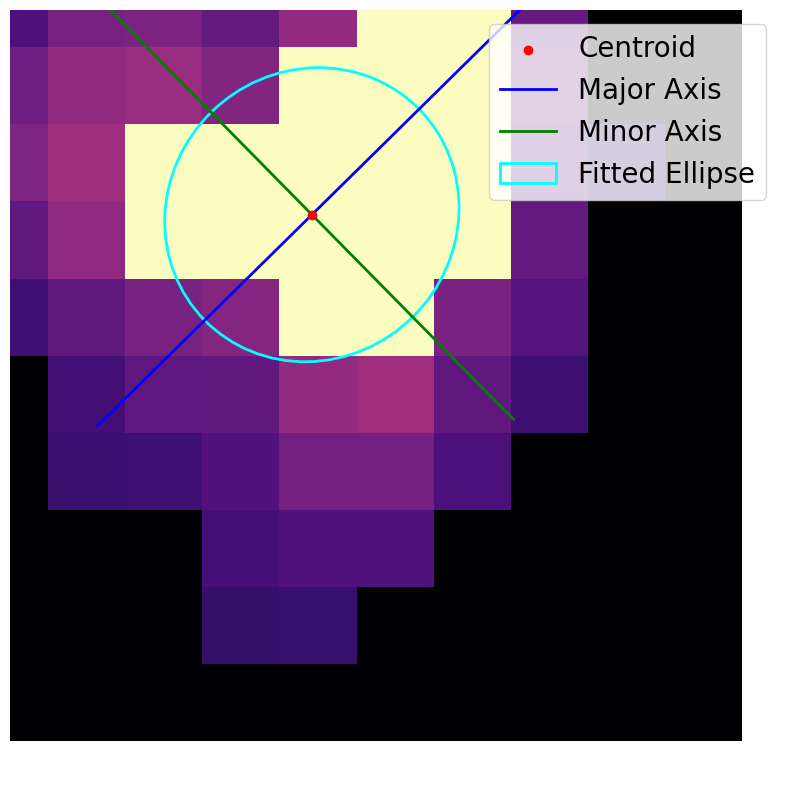

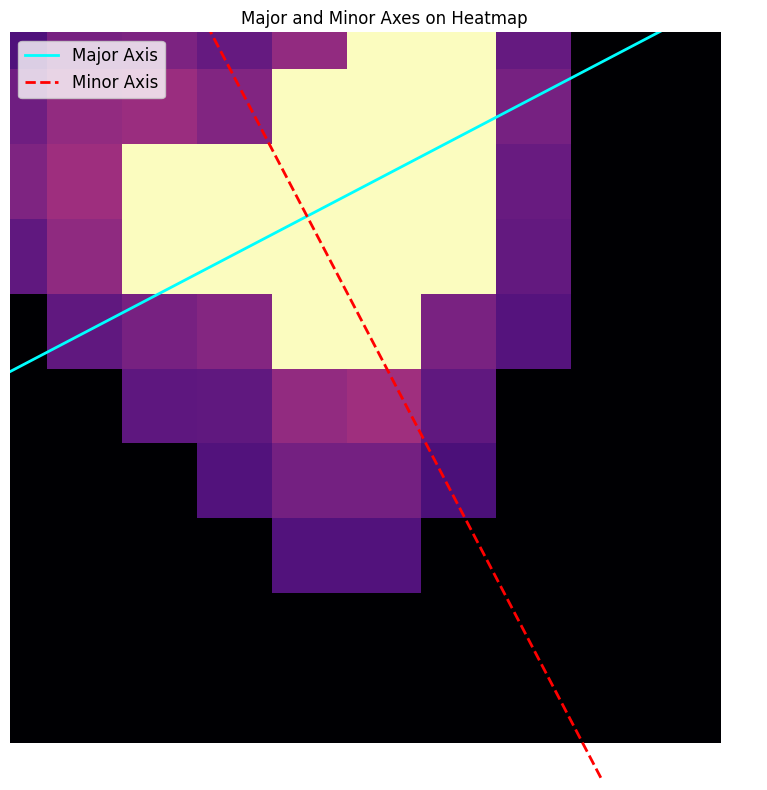

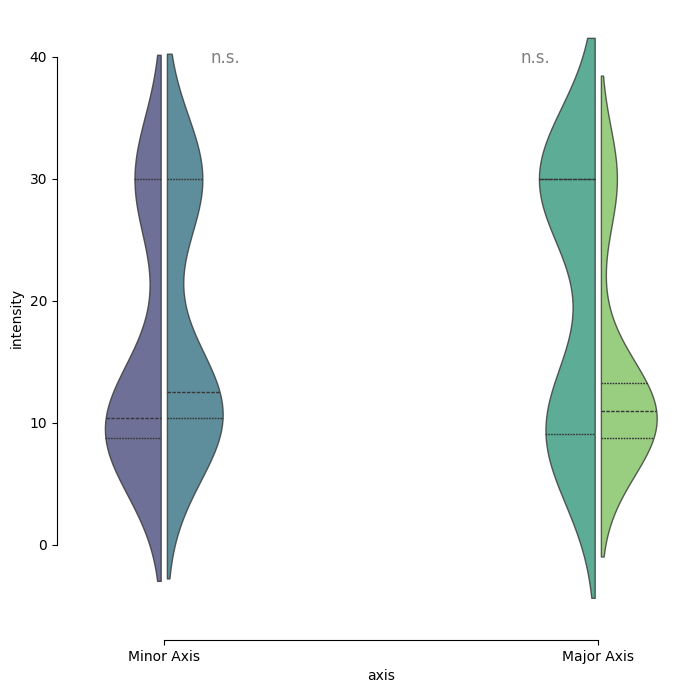

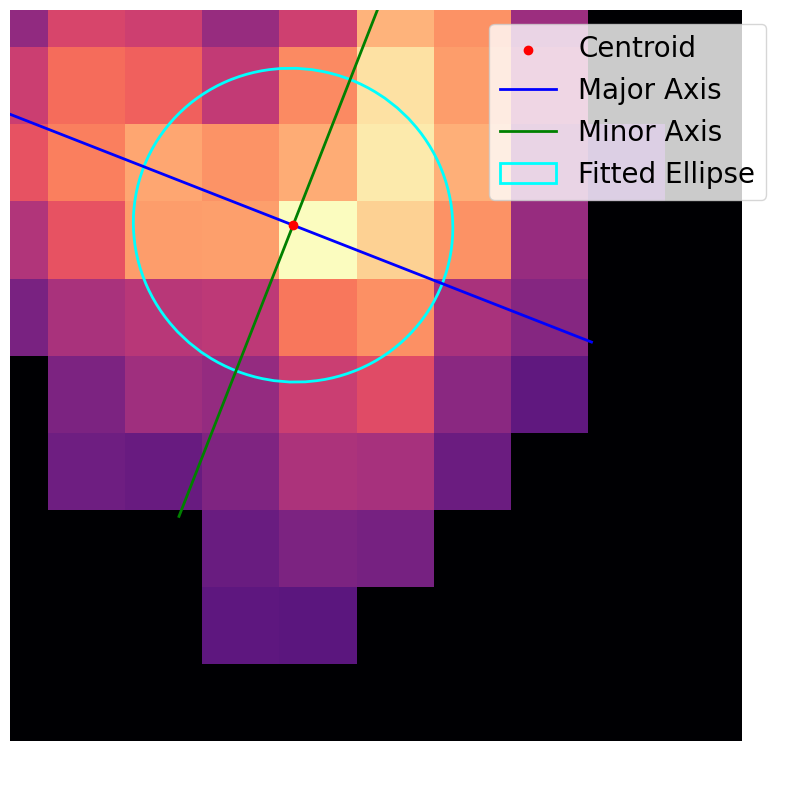

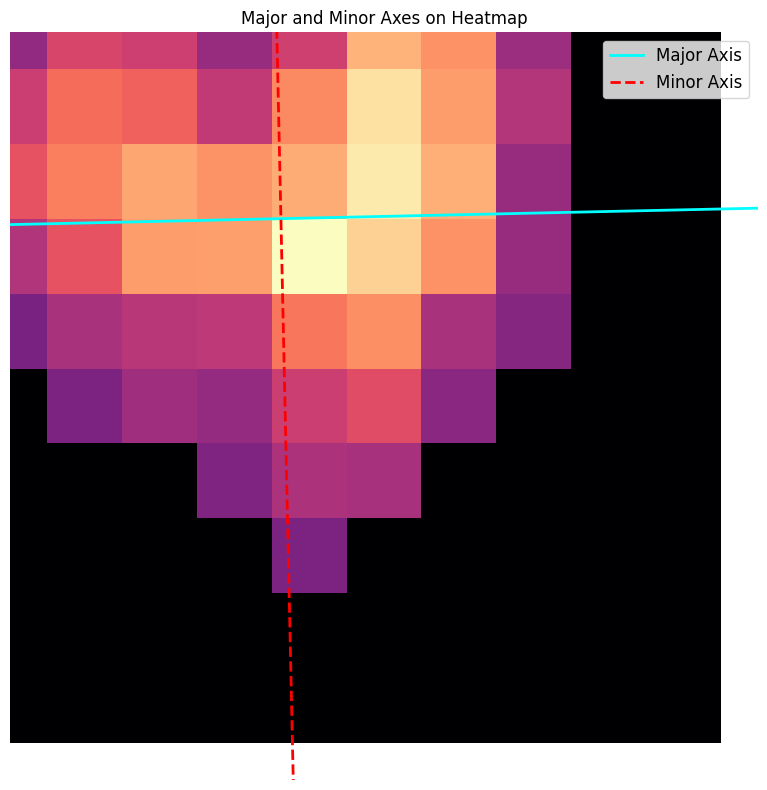

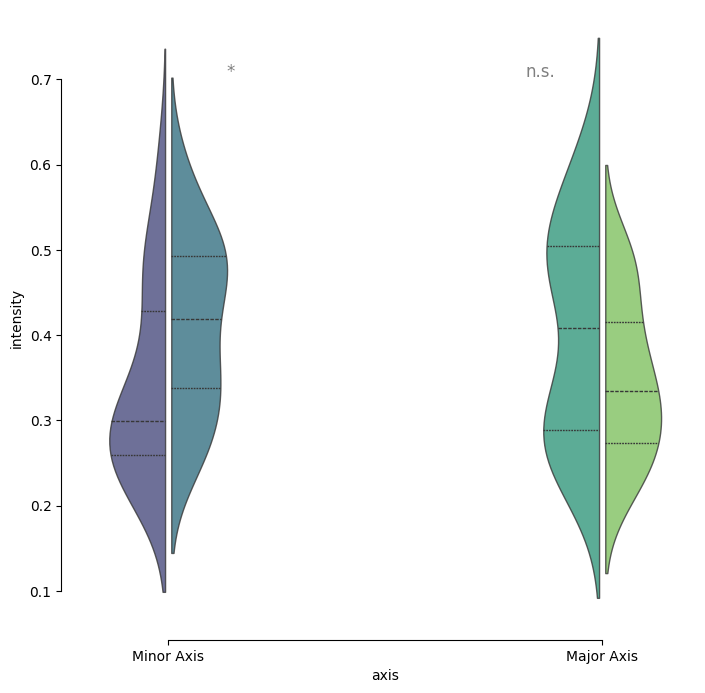

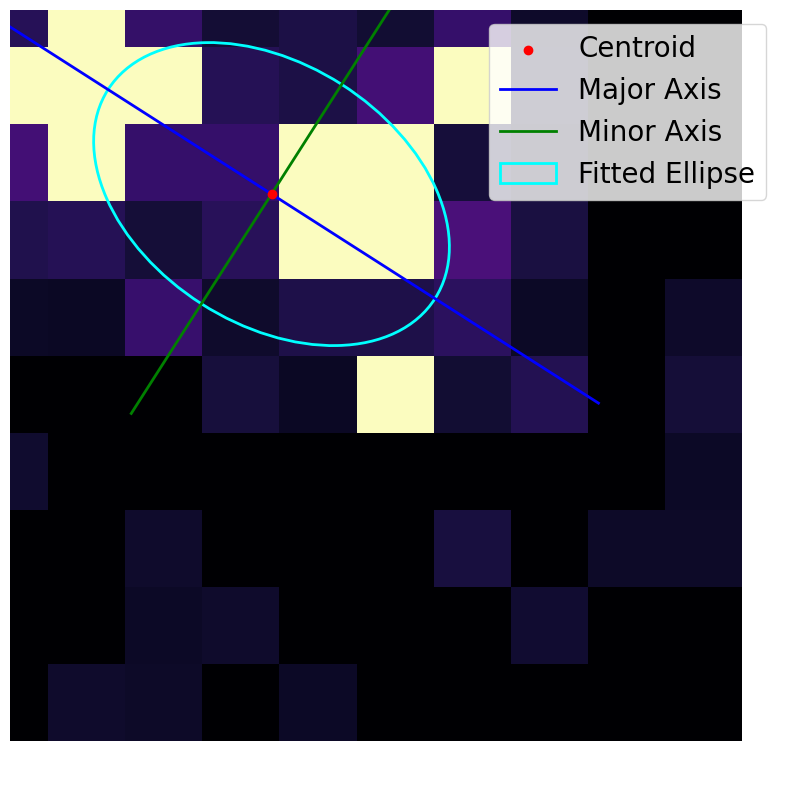

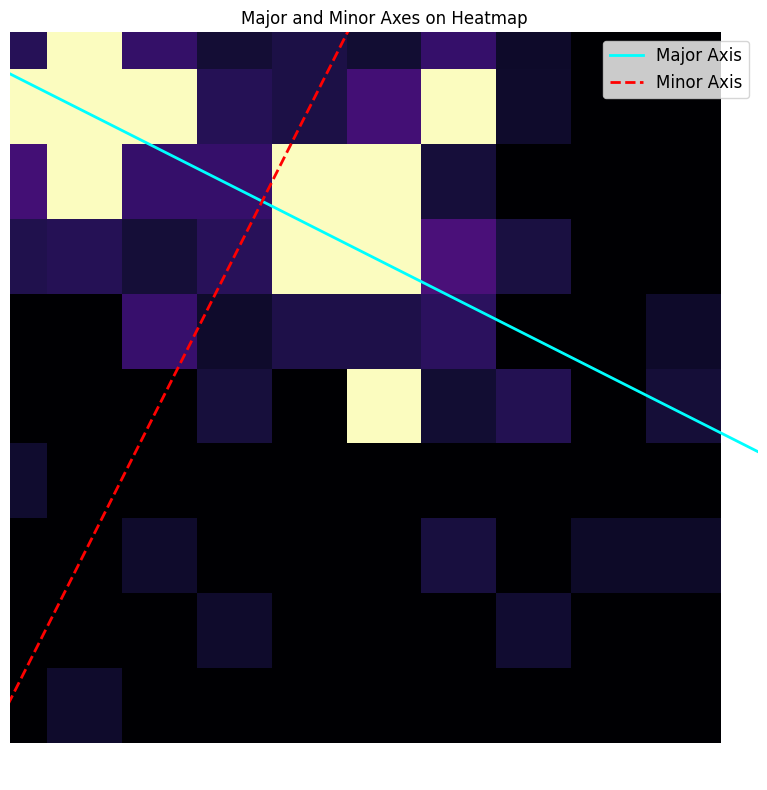

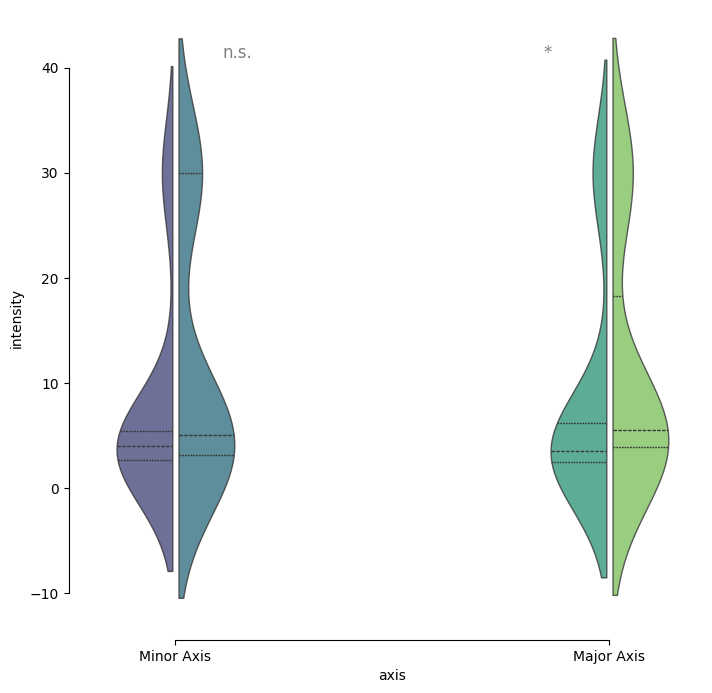

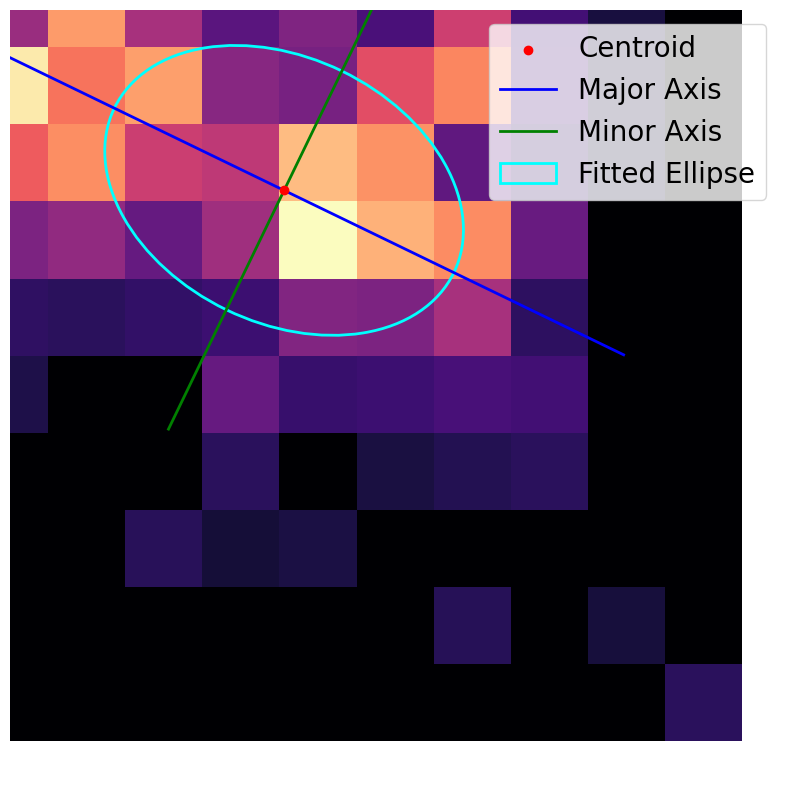

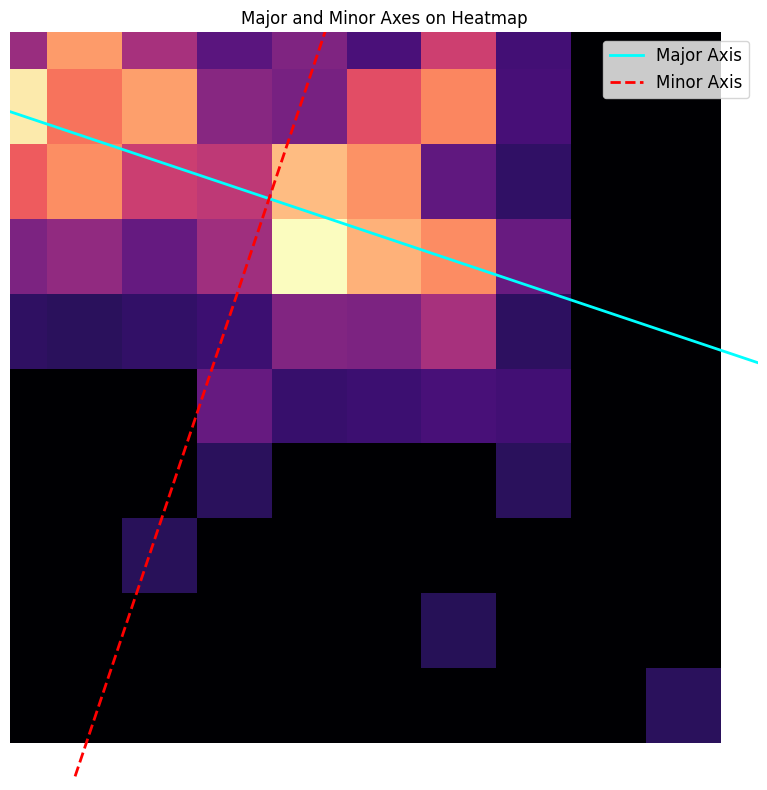

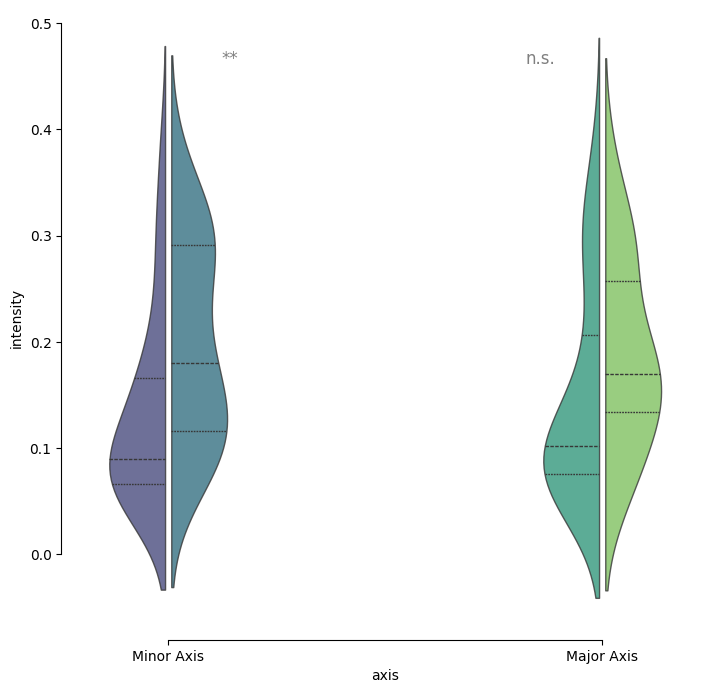

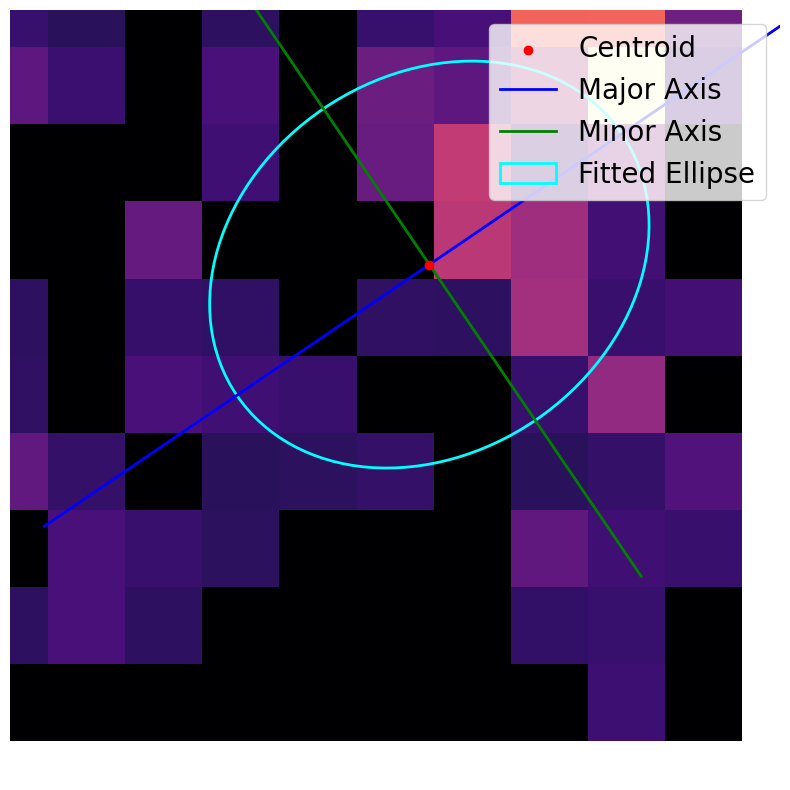

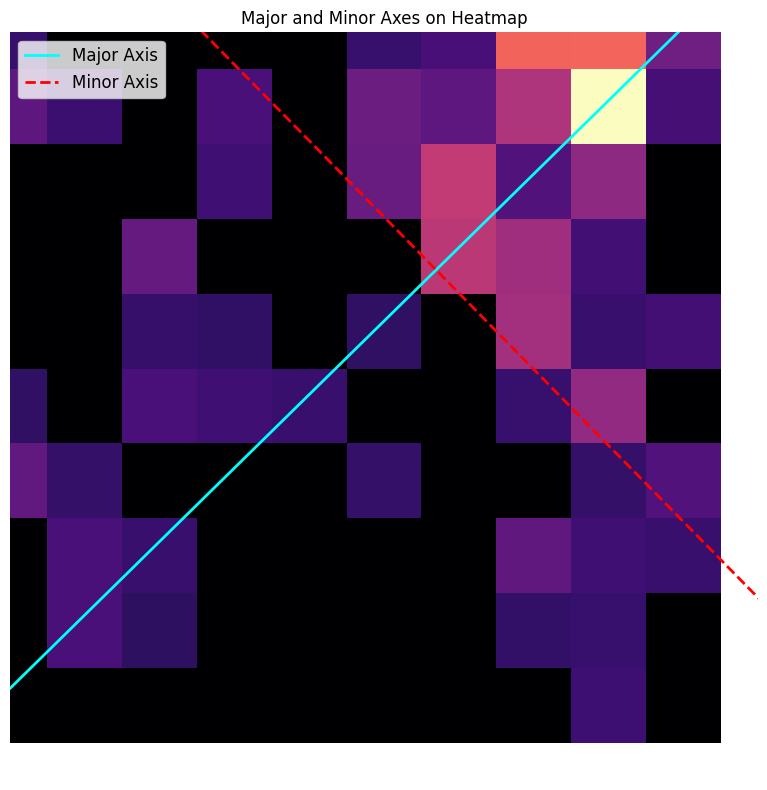

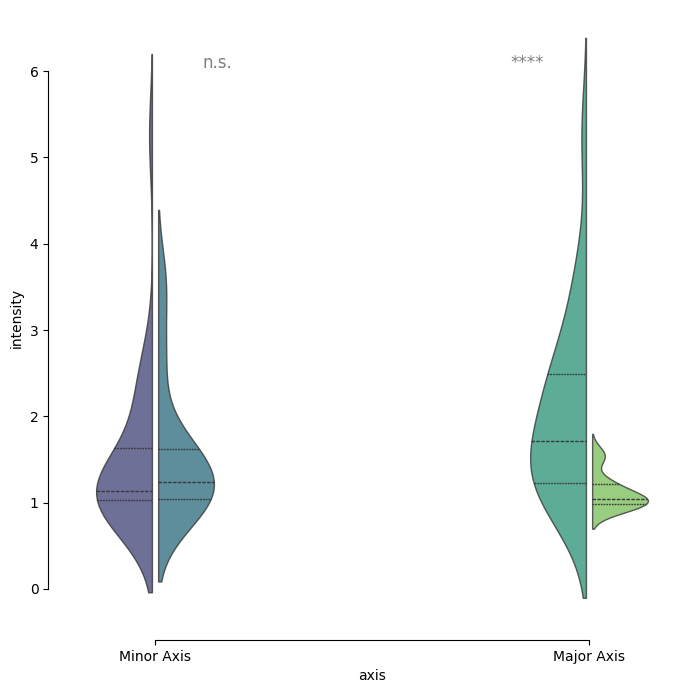

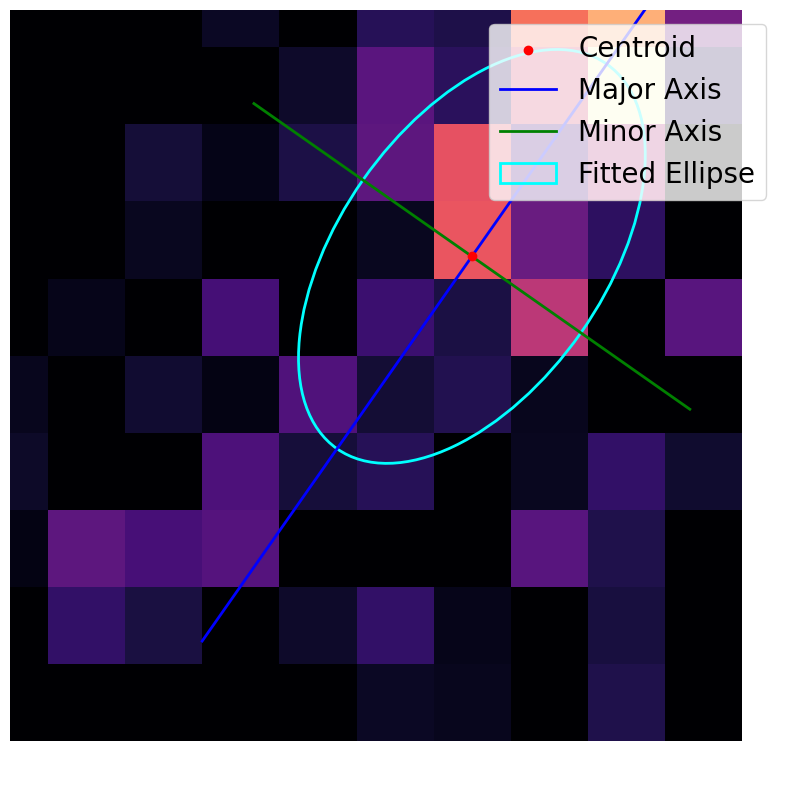

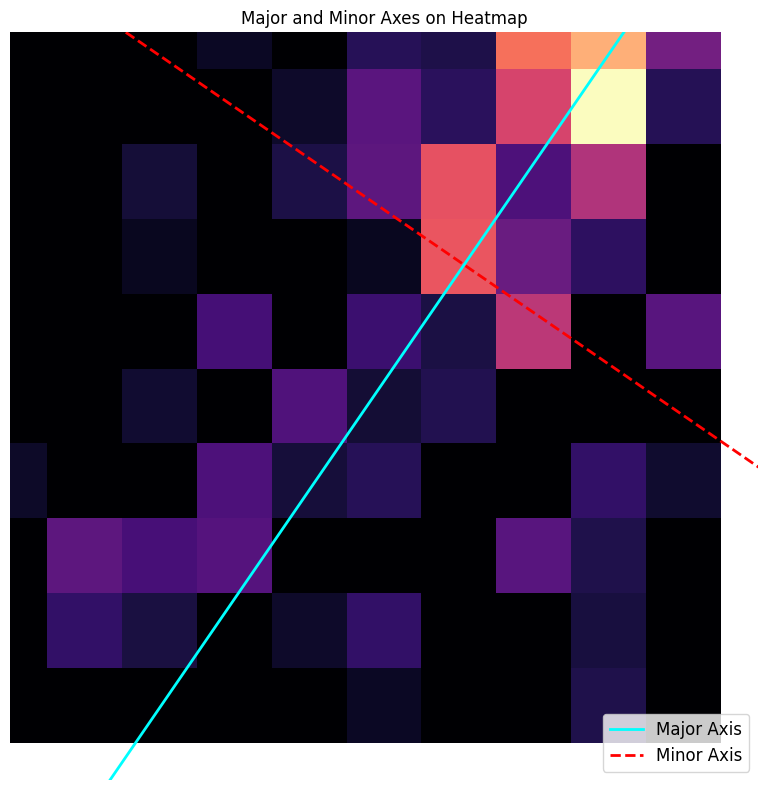

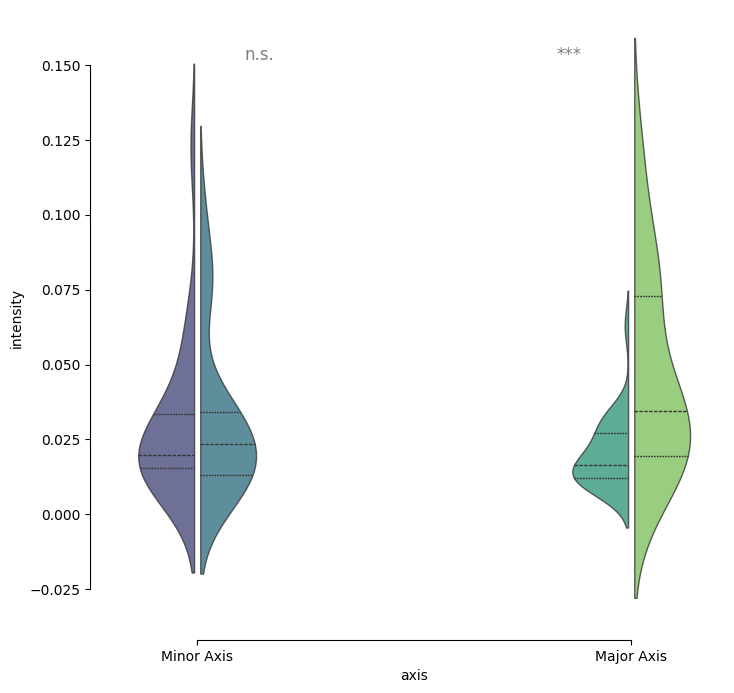

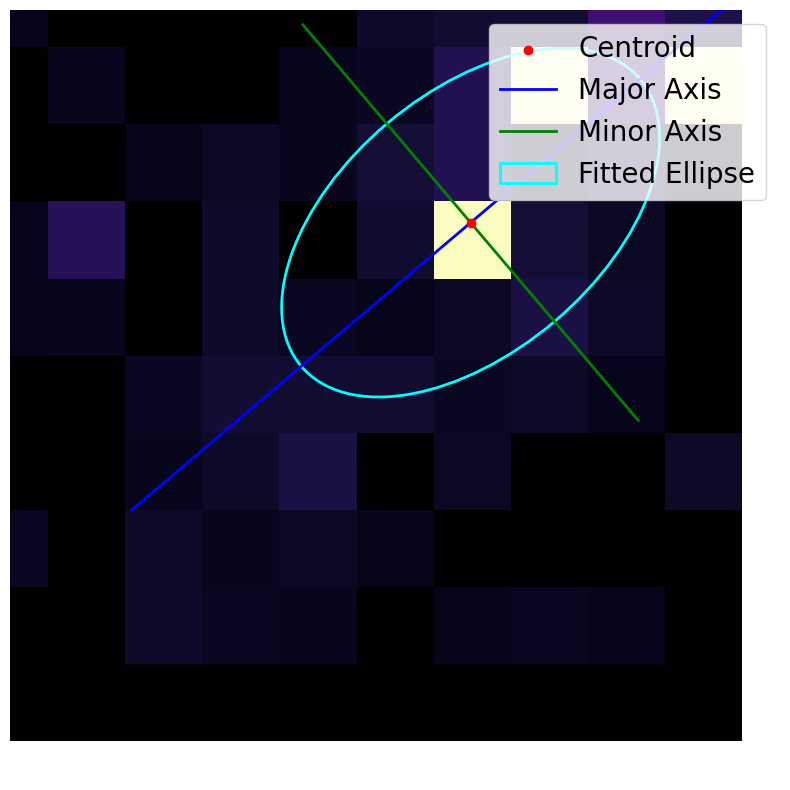

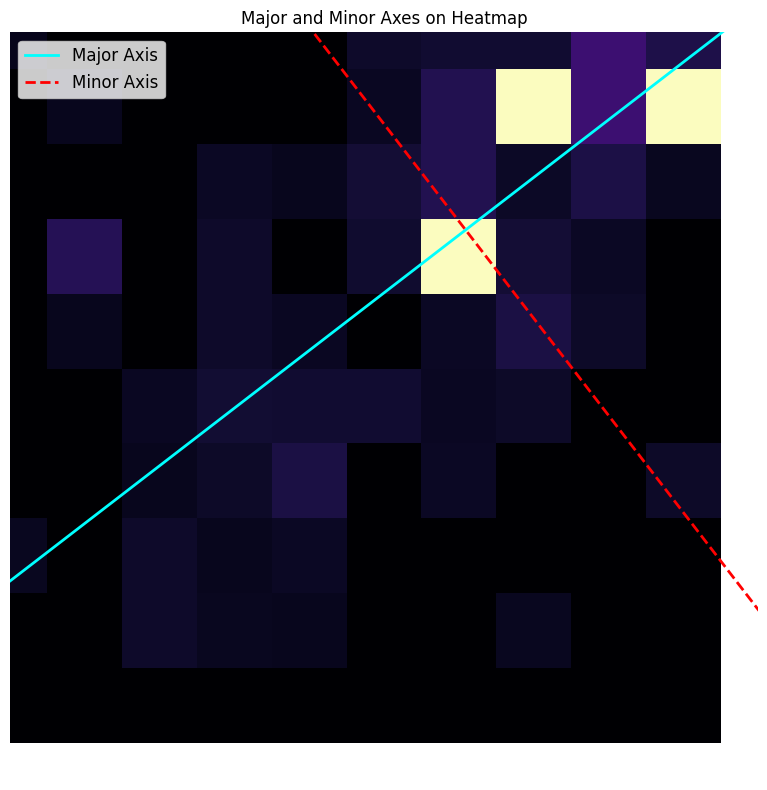

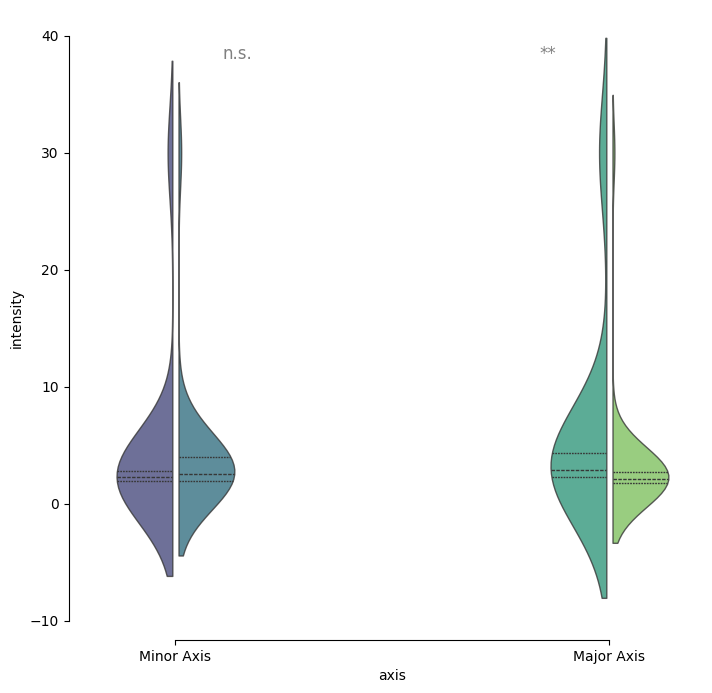

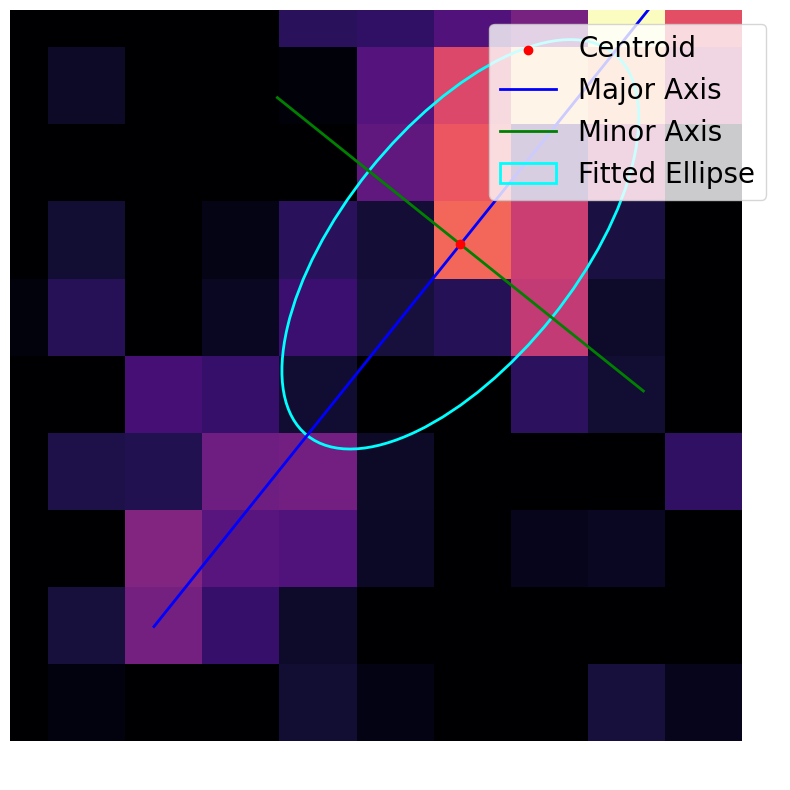

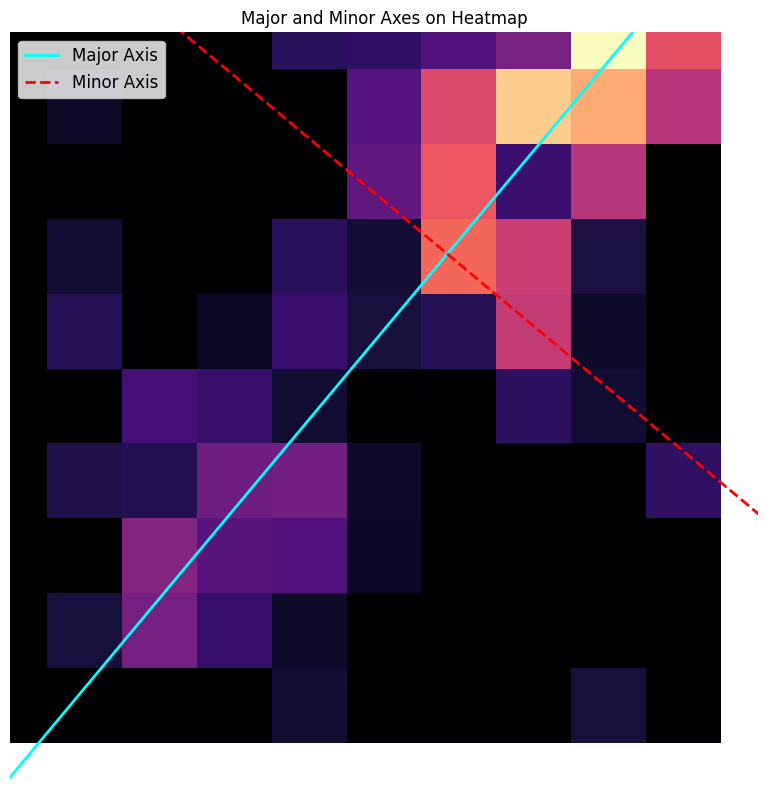

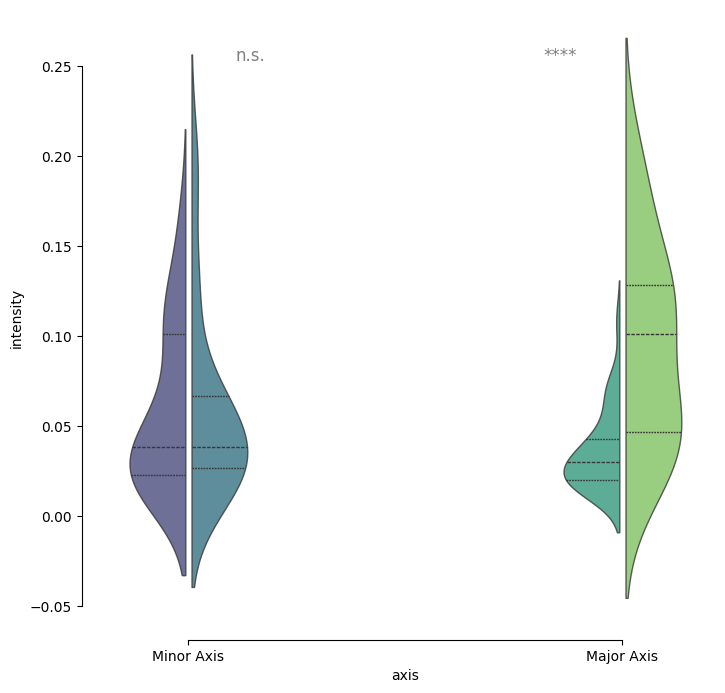

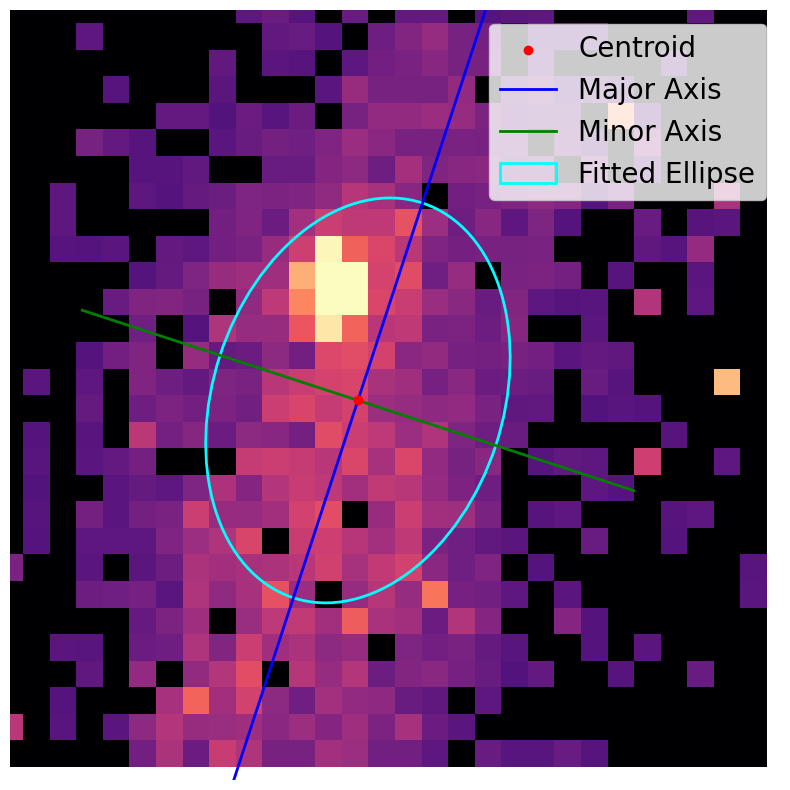

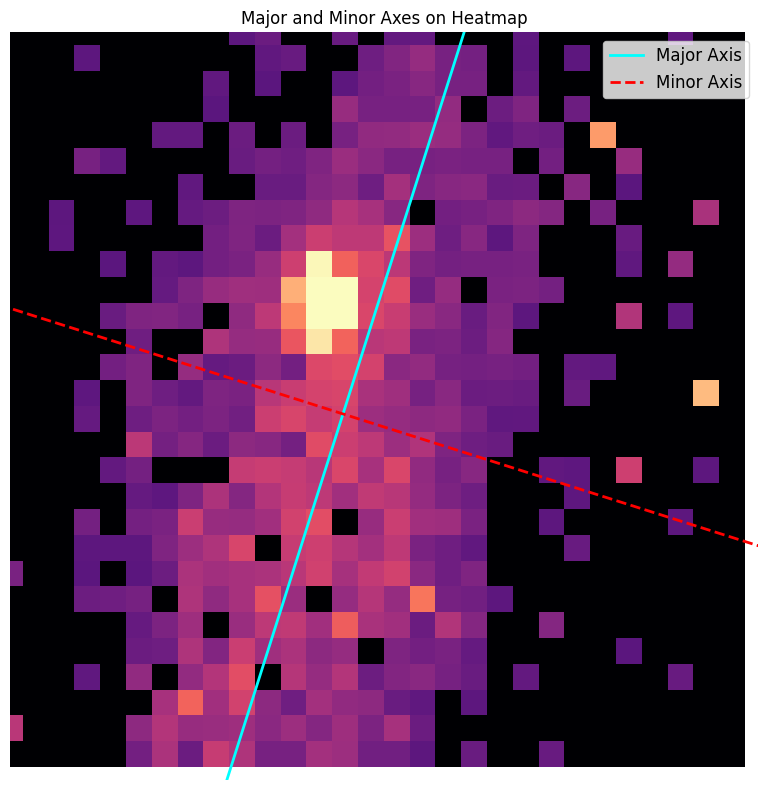

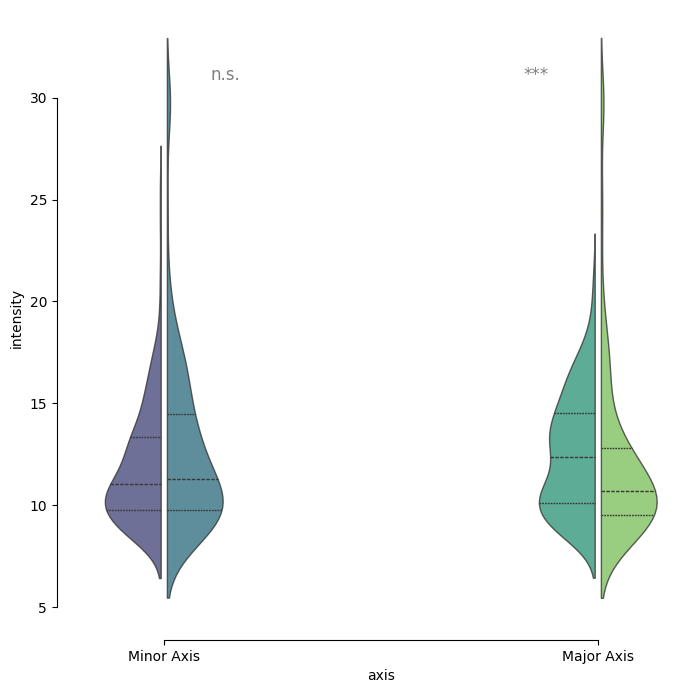

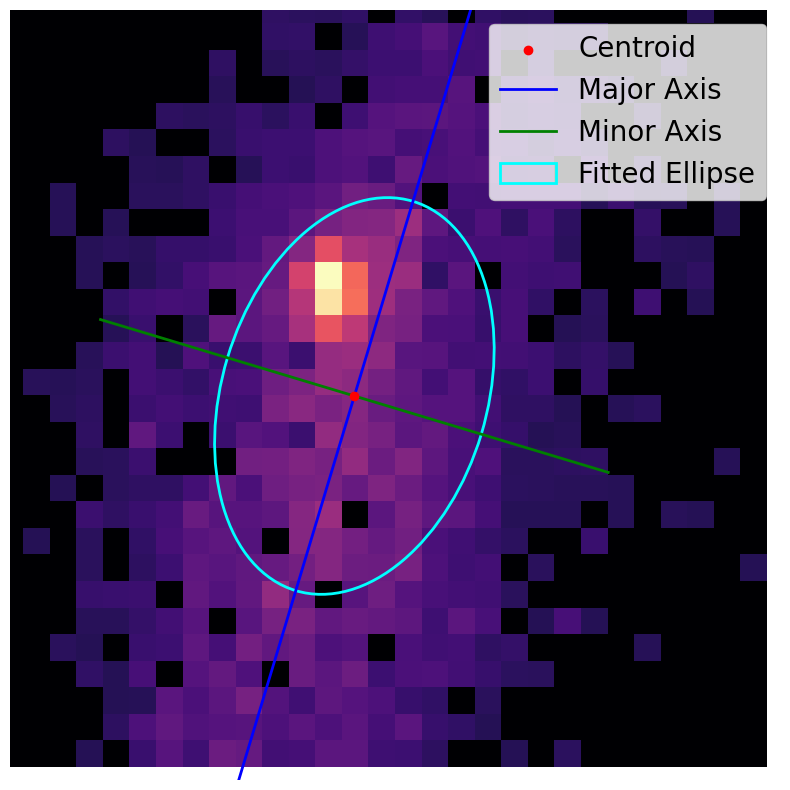

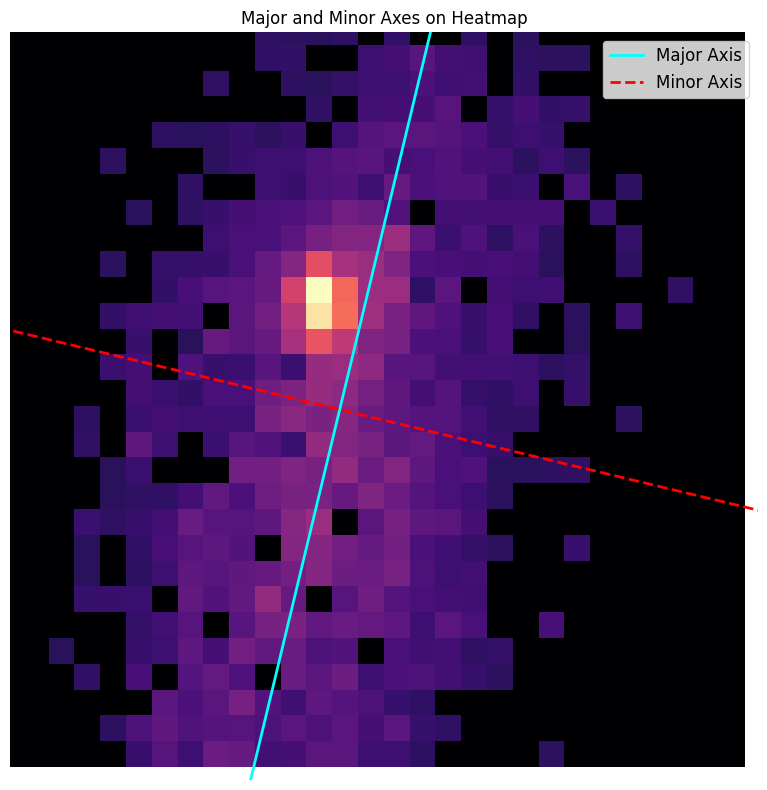

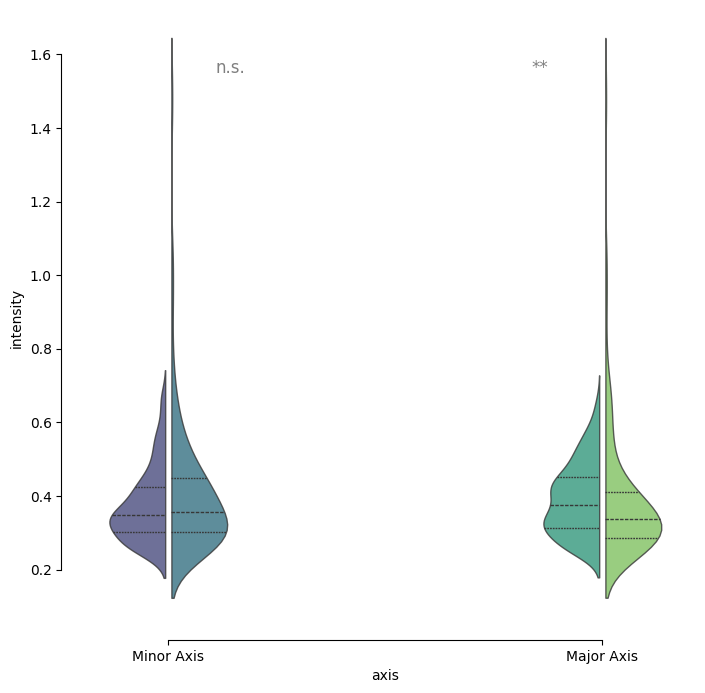

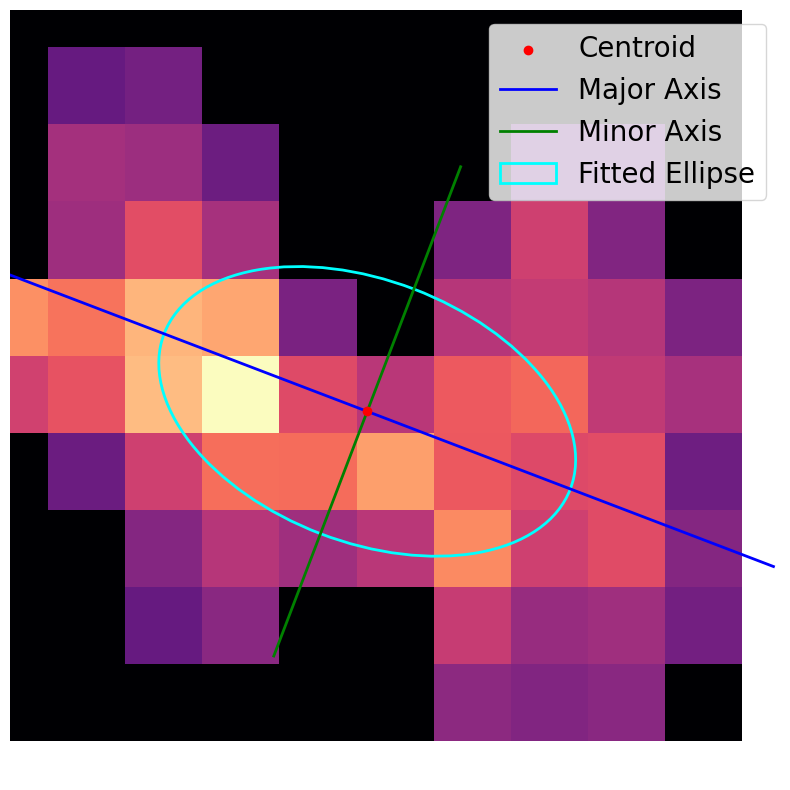

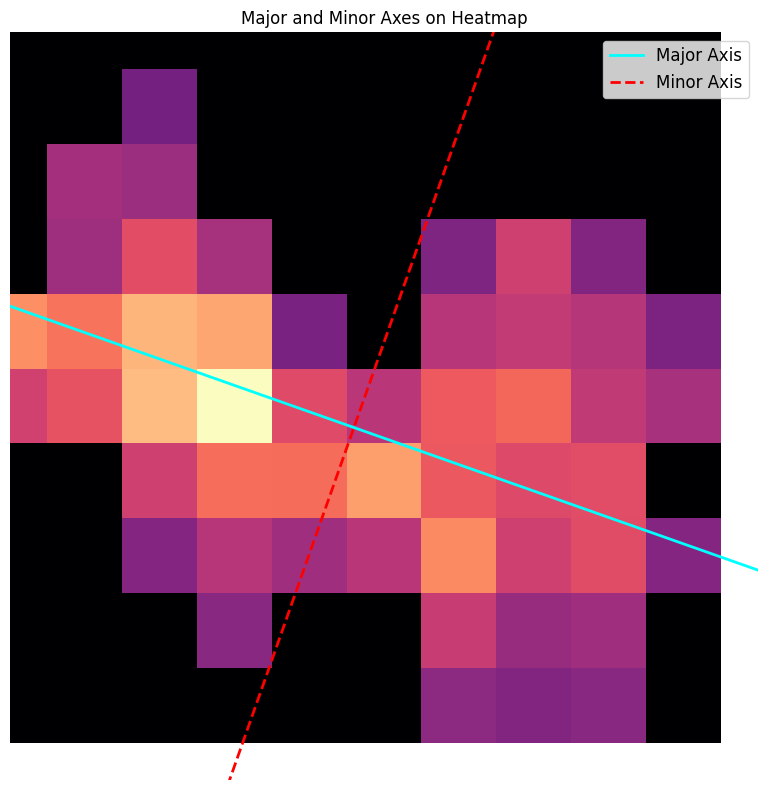

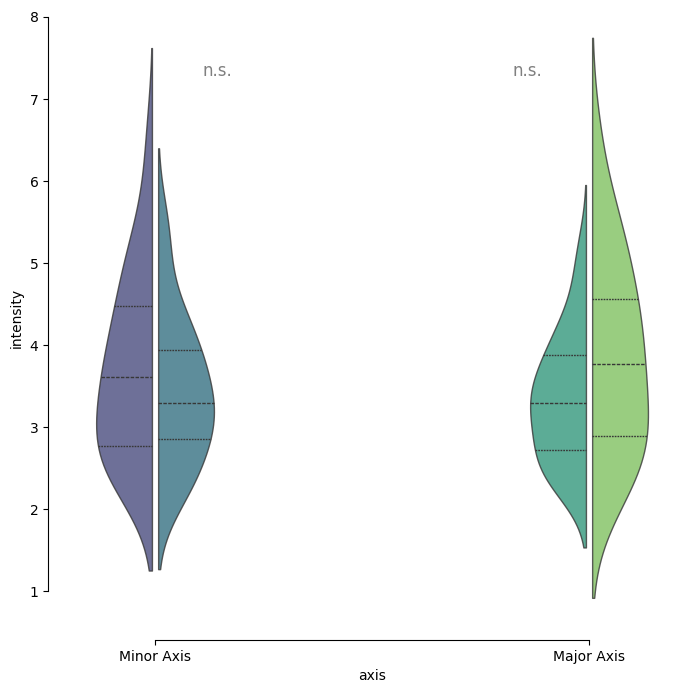

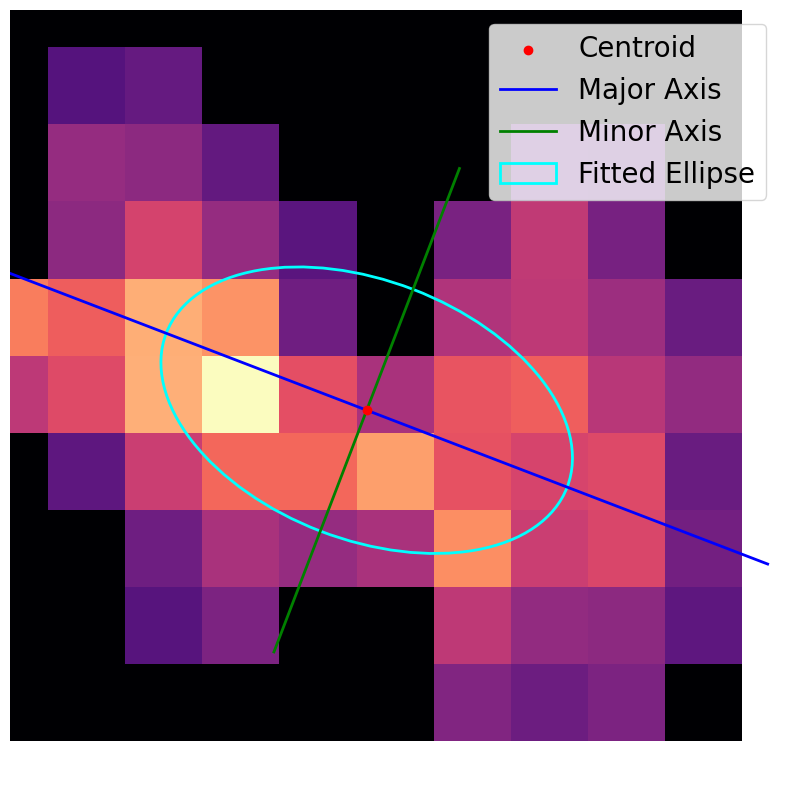

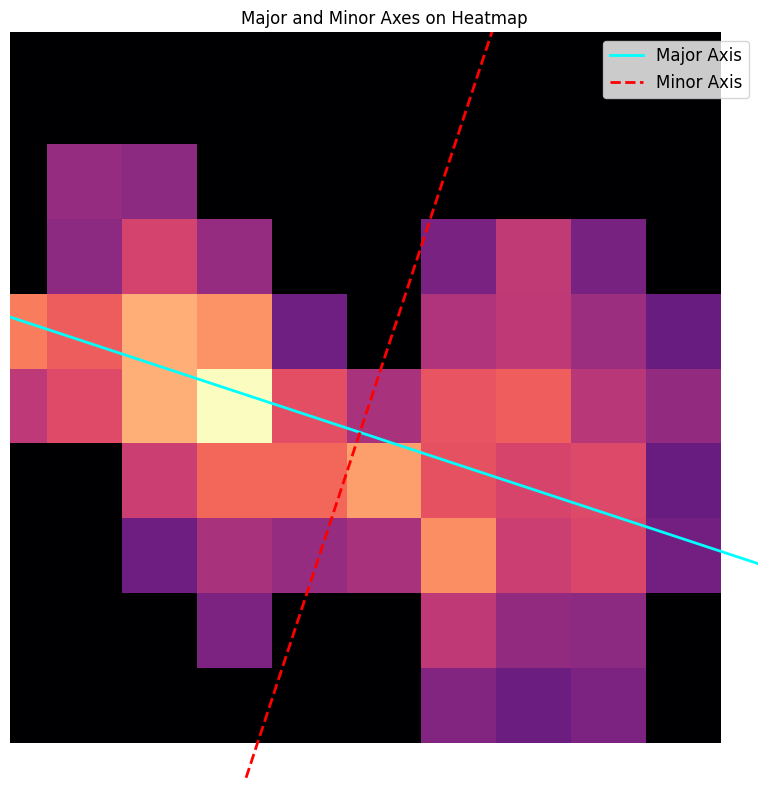

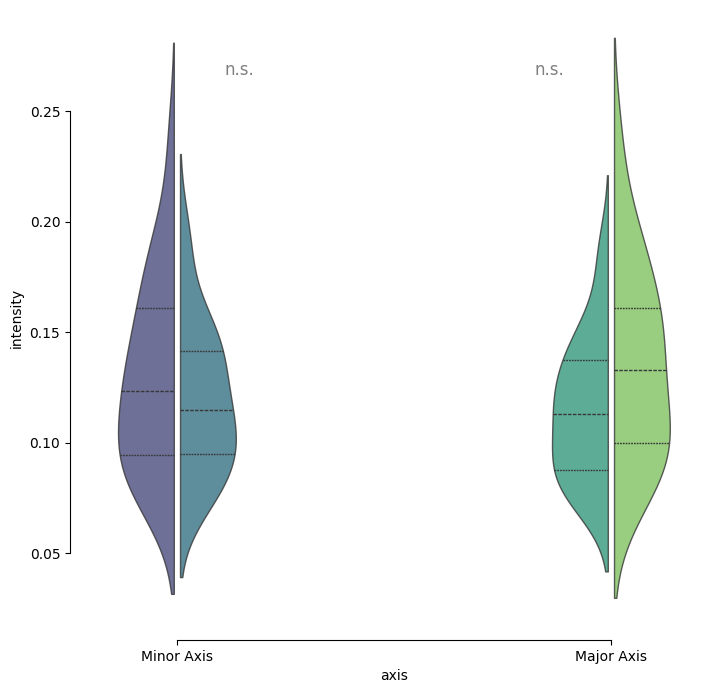

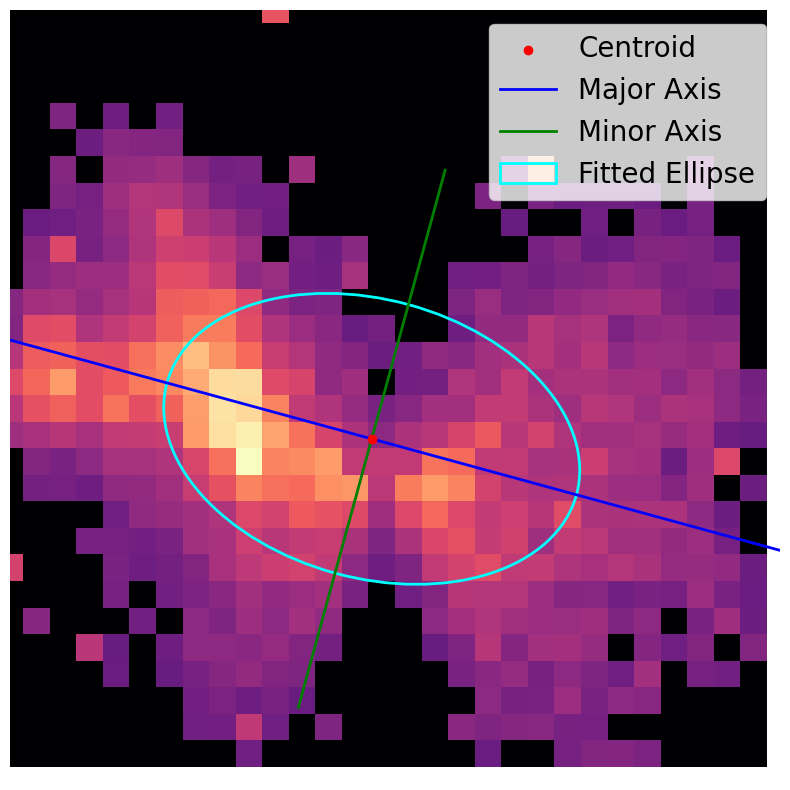

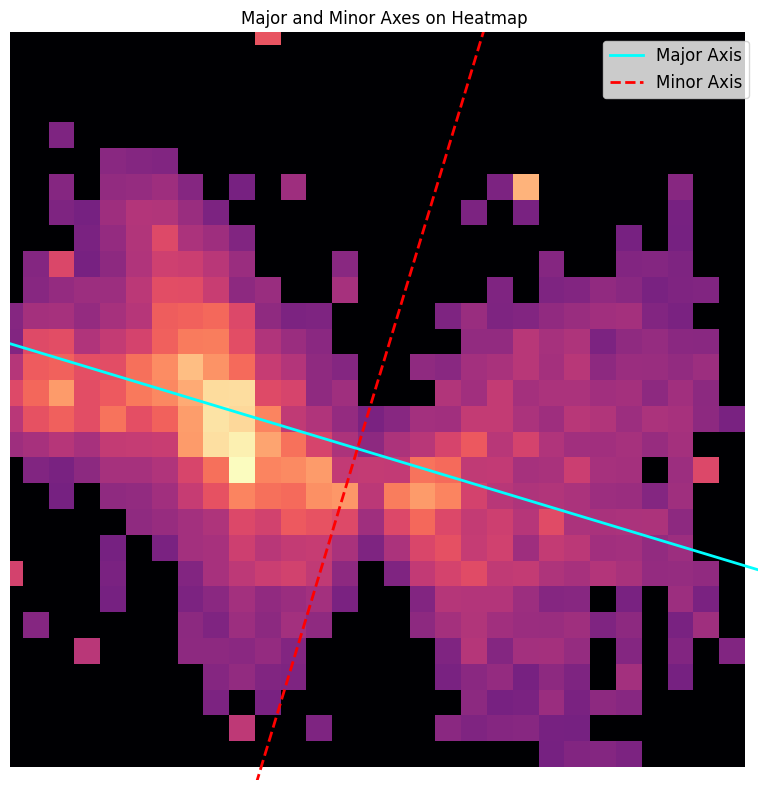

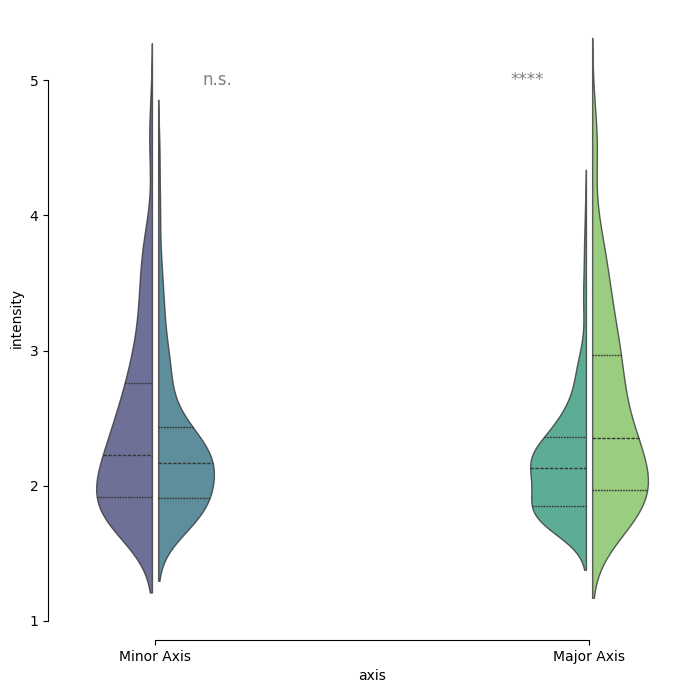

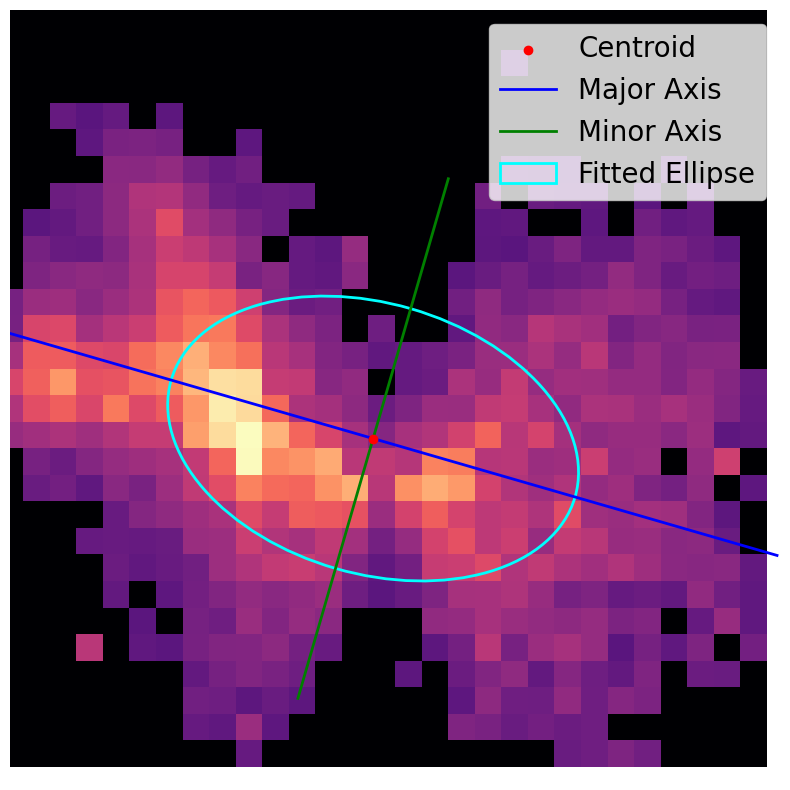

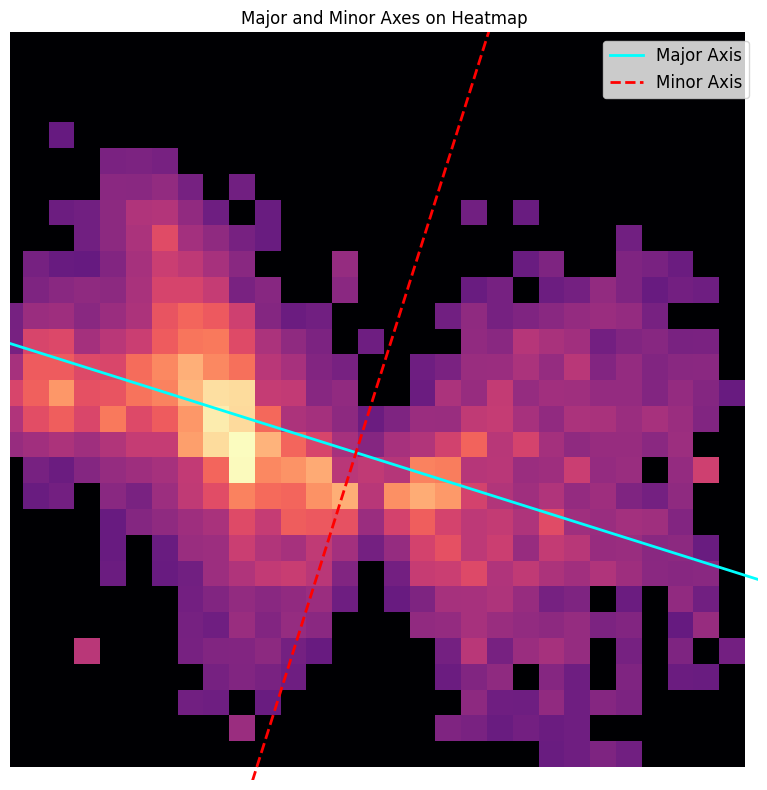

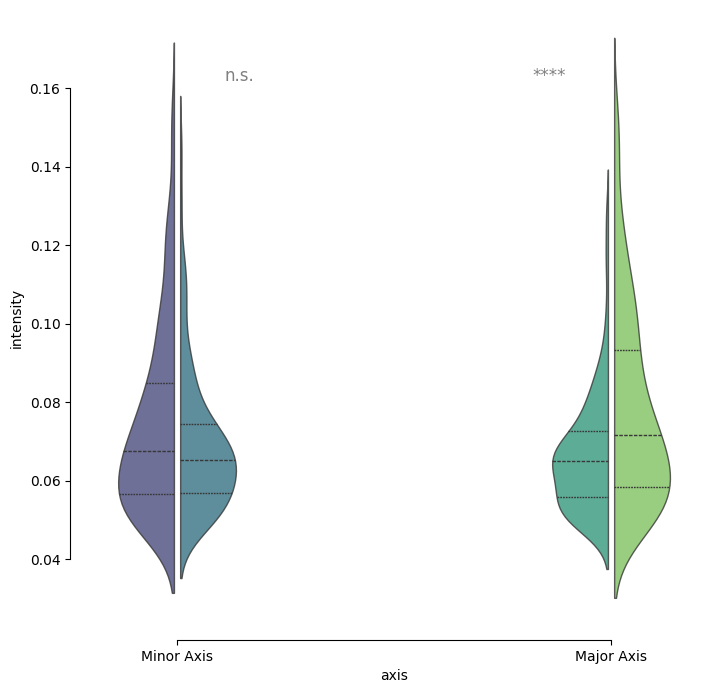

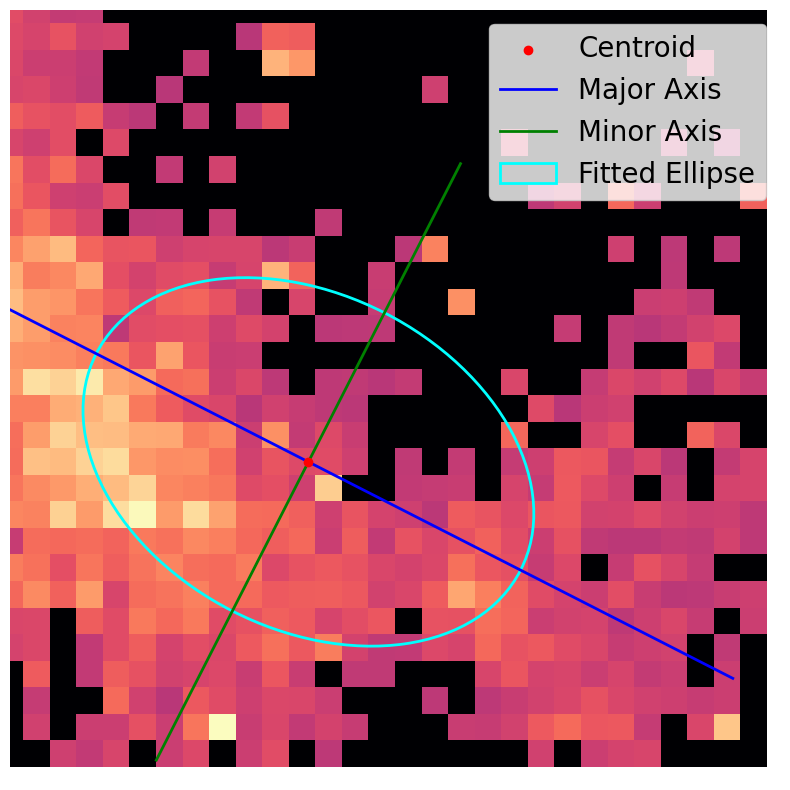

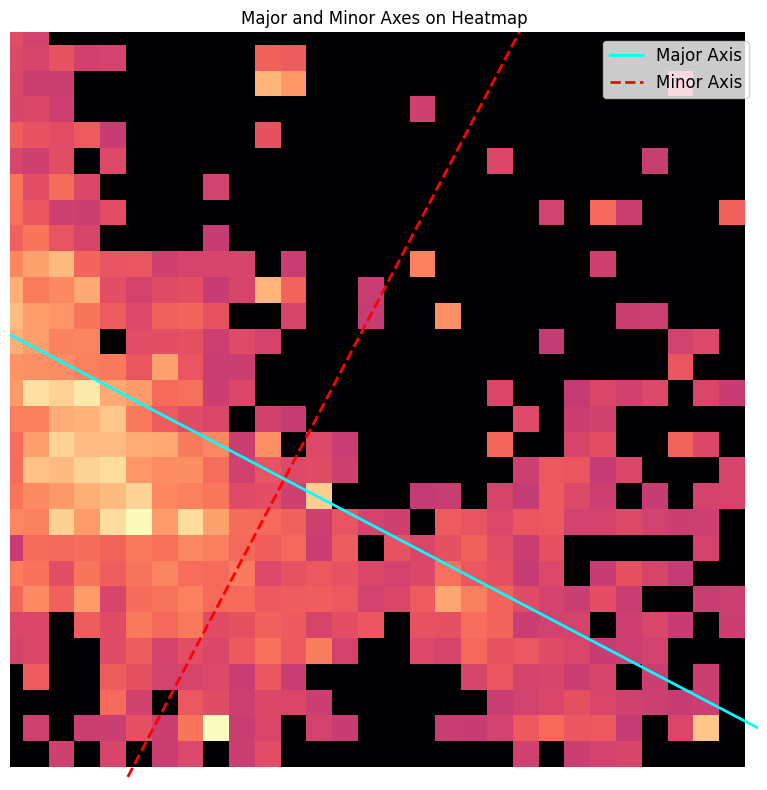

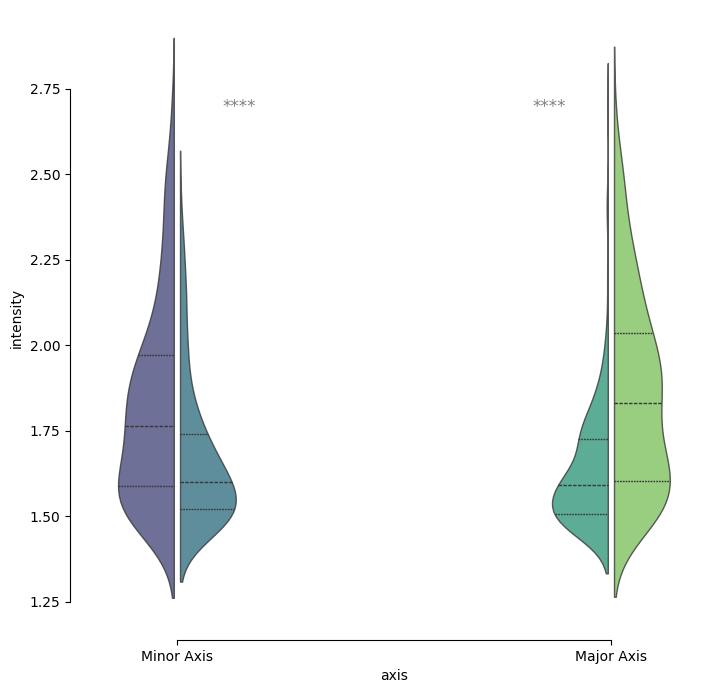

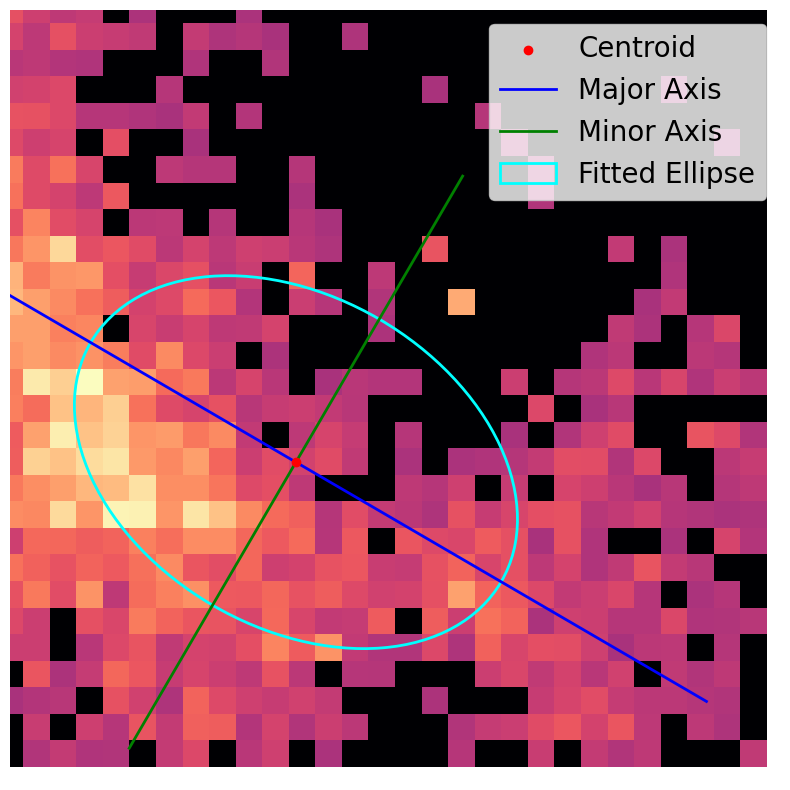

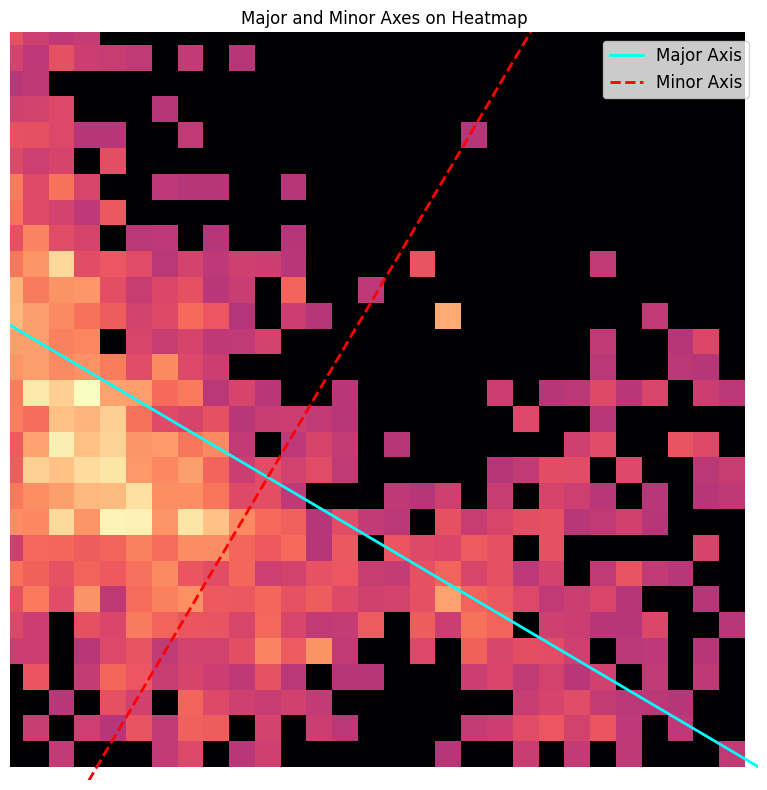

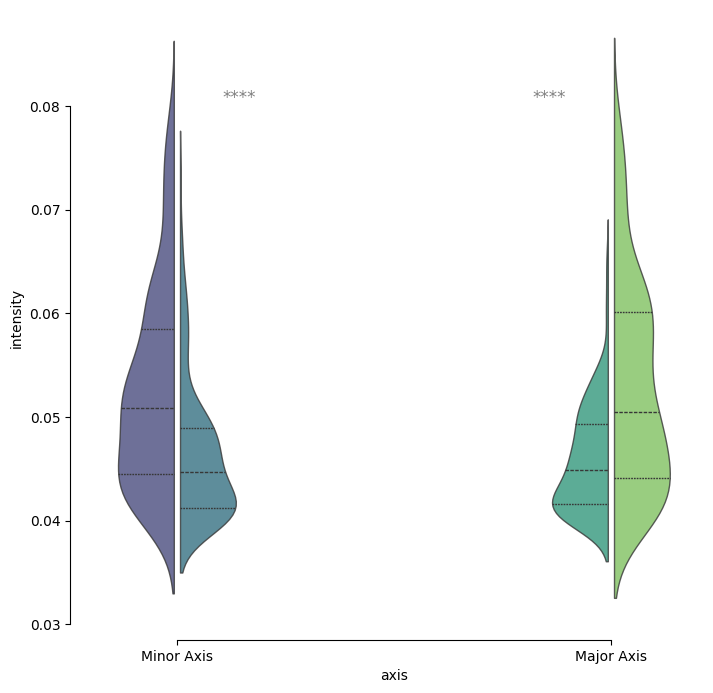

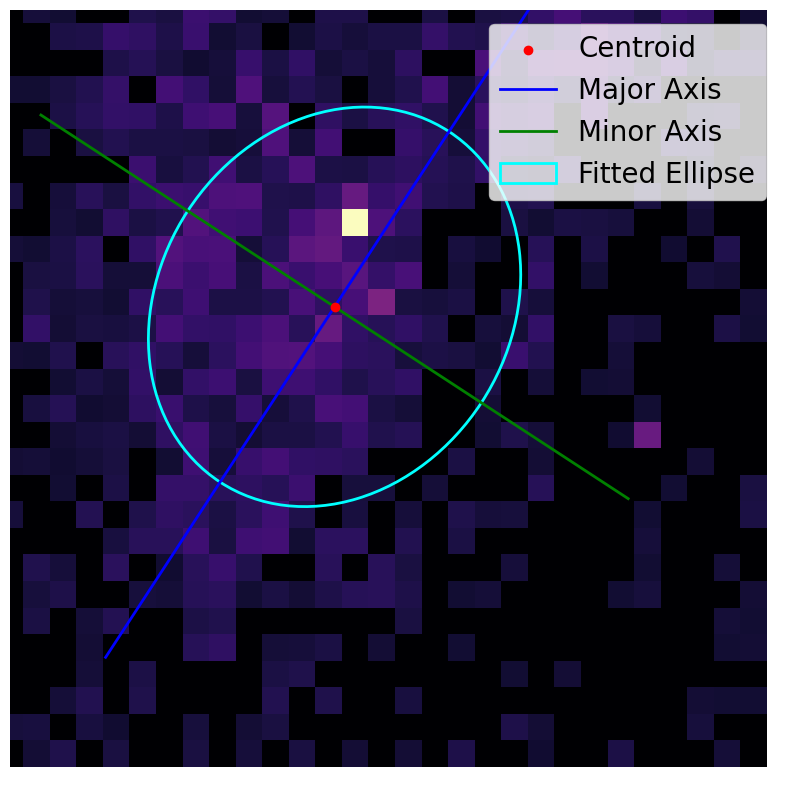

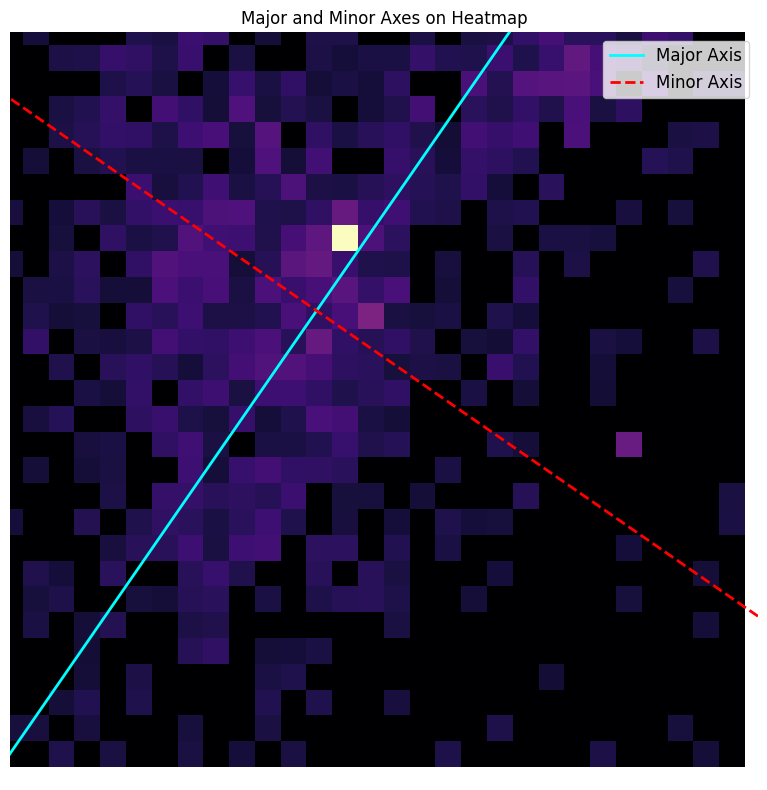

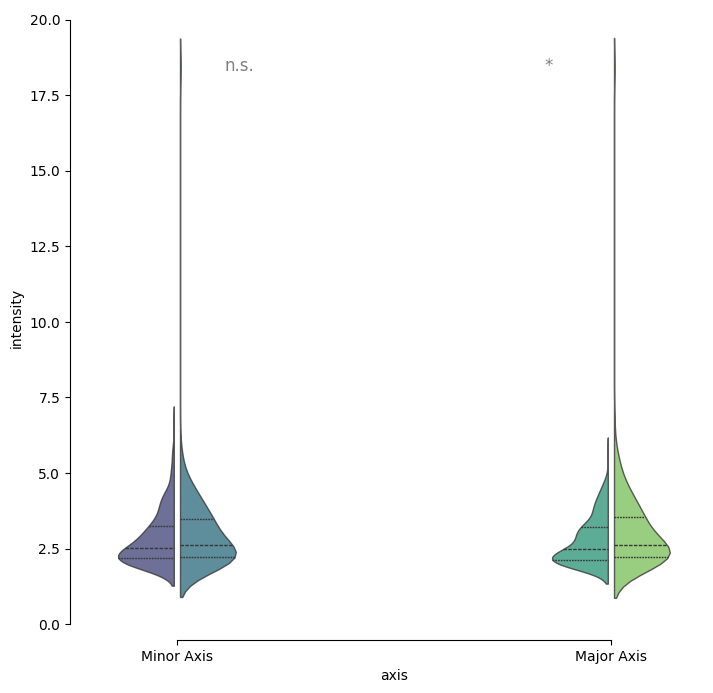

In [214]:
all_cells = []
for cell_name_suffix, cell_data in data.items():
    cell,expt,gridsize = cell_name_suffix.split('_')
    print(f'Processing {cell_name_suffix}')
    try:
        df = cell_data[2]
        angle, ecc = asymmetry_by_ellipse(df, cell_name_suffix, prop='peak', plot=False)
        asym_major, asym_minor = asymmetry_by_distribution(df, cell_name_suffix, prop='peak', plot=False)
        params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'peak', 'angle':angle, 'eccentricity':ecc, 'asymmetry_major_axis':asym_major,'asymmetry_minor_axis':asym_minor}
        all_cells.append(params)
    except Exception as e:
        print(f"Error in {cell_name_suffix}: {e}")

    try:   
        df = cell_data[3]
        angle, ecc = asymmetry_by_ellipse(df, cell_name_suffix, prop='auc', plot=False)
        asym_major, asym_minor = asymmetry_by_distribution(df, cell_name_suffix, prop='peak', plot=False)
        params = {'cell_name_suffix':cell_name_suffix, 'cell':cell, 'expt':expt, 'grid':gridsize, 'prop':'auc', 'angle':angle, 'eccentricity':ecc, 'asymmetry_major_axis':asym_major,'asymmetry_minor_axis':asym_minor}
        all_cells.append(params)
    except Exception as e:
        print(f"Error in {cell_name_suffix}: {e}")

asymmetry_by_ellipse_and_distribution = pd.DataFrame(all_cells)

In [219]:
asymmetry_by_ellipse_and_distribution.shape

(21, 9)

In [220]:
asymmetry_by_distance.shape

(23, 7)

In [221]:
asymmetry_by_pca.shape

(21, 6)

In [225]:
# concatenate all the dataframes
asymmetry_df = pd.merge(asymmetry_by_distance, asymmetry_by_pca, on=['cell_name_suffix', 'cell', 'expt', 'grid', 'prop'], how='outer')
asymmetry_df = pd.merge(asymmetry_df, asymmetry_by_ellipse_and_distribution, on=['cell_name_suffix', 'cell', 'expt', 'grid', 'prop'], how='outer')

In [226]:
asymmetry_df

cell_name_suffix      cell expt grid  prop  distance  \
0          cell1222  cell1222        29   auc  0.050000   
1       cell1_13_10     cell1   13   10   auc  0.397348   
2       cell1_13_10     cell1   13   10  peak  0.369182   
3       cell1_15_10     cell1   15   10   auc  0.388844   
4       cell1_15_10     cell1   15   10  peak  0.327211   
5       cell2_02_10     cell2   02   10   auc  0.164542   
6       cell2_02_10     cell2   02   10  peak  0.180916   
7      cell2_09a_10     cell2  09a   10   auc  0.107854   
8      cell2_09a_10     cell2  09a   10  peak  0.129472   
9       cell2_13_29     cell2   13   29   auc  0.156051   
10      cell2_13_29     cell2   13   29  peak  0.182220   
11      cell3_04_29     cell3   04   29   auc  0.022288   
12      cell3_04_29     cell3   04   29  peak  0.006862   
13      cell4_04_59     cell4   04   59   auc  0.060696   
14      cell4_04_59     cell4   04   59  peak  0.012954   
15      cell5_09_10     cell5   09   10   auc  0.094612   
16      cell5_09_10     cell5   09   10  peak  0.098335   
17      cell5_10_29     cell5   10   29   auc  0.111617   
18      cell5_10_29     cell5   10   29  peak  0.102099   
19      cell5_11_59     cell5   11   59   auc  0.115890   
20      cell5_11_59     cell5   11   59  peak  0.093316   
21      cell8_04_29     cell8   04   29   auc  0.015585   
22      cell8_04_29     cell8   04   29  peak  0.119688   

                                coms  explained_variance_ratio       angle  \
0                                 []                       NaN         NaN   
1       [[5.08, 4.29], [7.47, 1.11]]                  0.160950  -54.959270   
2       [[4.86, 3.92], [7.42, 1.26]]                  0.437892  -34.202955   
3       [[5.02, 4.24], [7.34, 1.12]]                  0.106850  -51.287007   
4        [[4.85, 3.8], [7.33, 1.67]]                  0.115148  -40.285070   
5         [[4.1, 3.1], [3.05, 1.84]]                  0.317266   25.839650   
6        [[4.0, 3.47], [3.09, 1.91]]                  0.258969   32.594664   
7       [[3.66, 3.22], [3.98, 2.19]]                  0.858786   21.395550   
8       [[3.66, 3.22], [4.37, 2.14]]                  0.710275  -44.571346   
9    [[11.88, 12.57], [11.89, 8.04]]                  0.486067 -100.448615   
10    [[11.9, 11.58], [13.43, 6.52]]                  0.630663  -97.381777   
11    [[12.6, 11.4], [11.97, 11.56]]                  0.365296  -44.534729   
12   [[12.72, 11.1], [12.62, 10.93]]                  0.355133  -44.288991   
13   [[13.2, 14.28], [12.34, 12.74]]                  0.350524  -73.243758   
14  [[13.26, 14.42], [12.96, 14.18]]                  0.432480  -71.892092   
15      [[4.83, 5.15], [3.88, 5.17]]                  0.291302   20.990277   
16      [[4.84, 5.19], [3.86, 5.13]]                  0.294296   20.902017   
17  [[14.33, 16.18], [11.11, 15.82]]                  0.343780   16.142605   
18  [[14.21, 16.28], [11.32, 15.61]]                  0.380655   15.278787   
19    [[11.52, 17.01], [8.17, 16.9]]                  0.462913   30.233072   
20   [[11.85, 17.04], [9.15, 16.89]]                  0.481608   27.022722   
21  [[13.95, 13.92], [13.91, 14.37]]                       NaN         NaN   
22   [[12.33, 11.85], [12.88, 8.43]]                  0.618625  -56.845134   

    eccentricity  asymmetry_major_axis  asymmetry_minor_axis  
0            NaN                   NaN                   NaN  
1       0.823995             20.884637             15.329281  
2       0.587193             18.310549              6.215090  
3       0.877966             22.553164              0.323245  
4       0.811871              5.077876              9.146733  
5       0.711138              8.338967             11.569415  
6       0.741499             11.427697             16.296484  
7       0.218225             11.218579              5.086873  
8       0.298005              0.674024              2.147805  
9       0.742215             21.165910              2.496577  
10      0.660551    

In [236]:
# make long form
asymmetry_df_long = pd.melt(asymmetry_df, id_vars=['cell_name_suffix', 'cell', 'expt', 'grid', 'prop'], value_vars=['distance', 'explained_variance_ratio', 'angle', 'eccentricity', 'asymmetry_major_axis', 'asymmetry_minor_axis'], var_name='metric', value_name='value')
# save the df
asymmetry_df_long.to_hdf(fig_folder / 'asymmetry_metrics_long.h5', key='data', mode='w')

C:\Users\adity\AppData\Local\Temp\ipykernel_39948\50586066.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['cell_name_suffix', 'cell', 'expt', 'grid', 'prop', 'metric'], dtype='object')]

  asymmetry_df_long.to_hdf(fig_folder / 'asymmetry_metrics_long.h5', key='data', mode='w')


In [245]:
asymmetry_df_long['grid'] = asymmetry_df_long['grid'].astype(int)

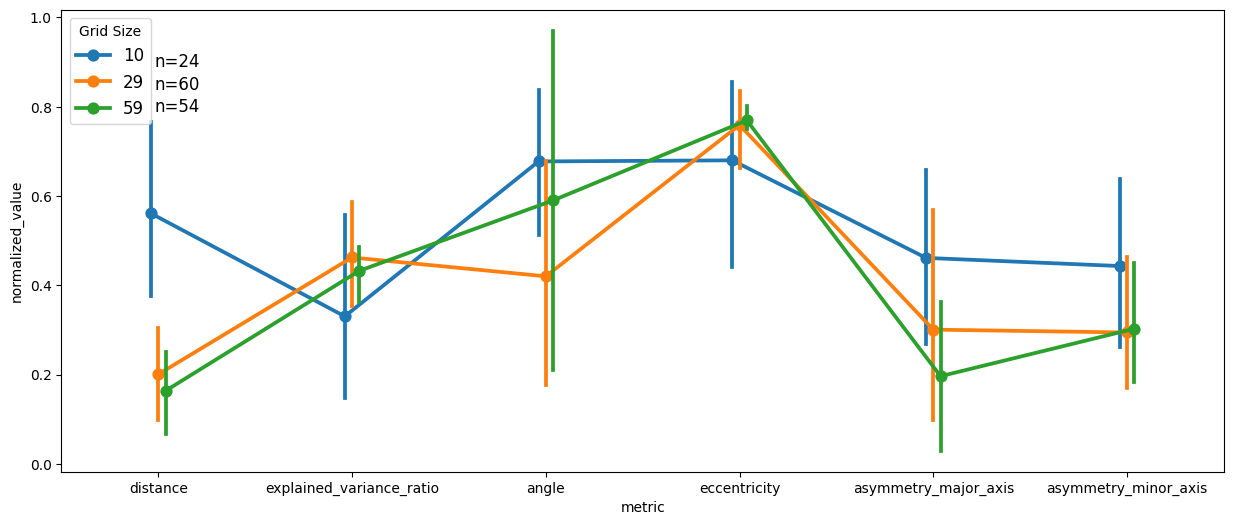

In [250]:
# consolidated plot of all the metrics together to compare how they change
fig, ax = plt.subplots(1,1, figsize=(15,6))

g = asymmetry_df_long.groupby('metric')['value']
asymmetry_df_long['normalized_value'] = (asymmetry_df_long['value'] - g.transform('min')) / (g.transform('max') - g.transform('min'))
    

sns.pointplot(x='metric', y='normalized_value', hue='grid', palette='tab10', data=asymmetry_df_long, ax=ax, alpha=1, dodge=True)
ax.legend(title='Grid Size', loc='upper left', fontsize=12)
# add numbers of cells in the corner
[ax.text(0.1, 0.8+0.05*j, f'n={asymmetry_df_long[asymmetry_df_long["grid"]==i].shape[0]}', fontsize=12, ha='center', va='center') for j,i in enumerate(asymmetry_df_long['grid'].unique())]
# save plot
fig.savefig(fig_folder / 'asymmetry_metrics_all_compared.png')
fig.savefig(fig_folder / 'asymmetry_metrics_all_compared.svg')

## Not correct: XXX kernel-based network activation XXX

In [72]:
kernel = 5*df_pivot_peak_29.to_numpy()
kernel = kernel[5:,:].T

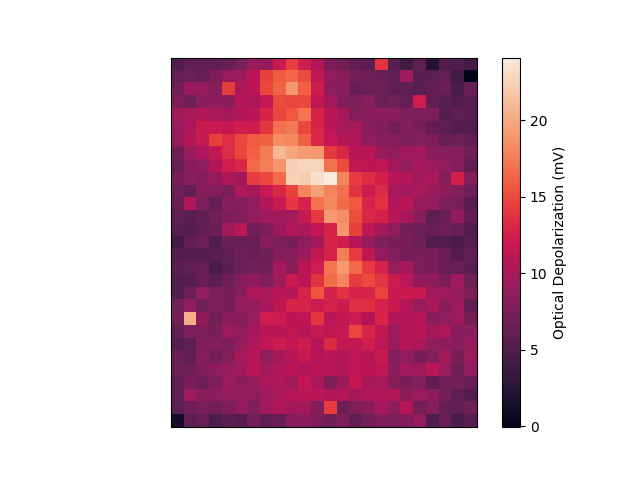

In [73]:
# plot matplotlib heatmap of the kernel
plt.figure()
# layout tight
plt.tight_layout()
plt.imshow(kernel, cmap='rocket', interpolation='nearest')
# remove ticks and labels
plt.xticks([])
plt.yticks([])
# add colourbar axis label
cbar = plt.colorbar()
cbar.set_label('Optical Depolarization (mV)')
# save as svg and png
plt.savefig(fig_folder / f'kernel_convolution_kernel.svg')
plt.savefig(fig_folder / f'kernel_convolution_kernel.png')

actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


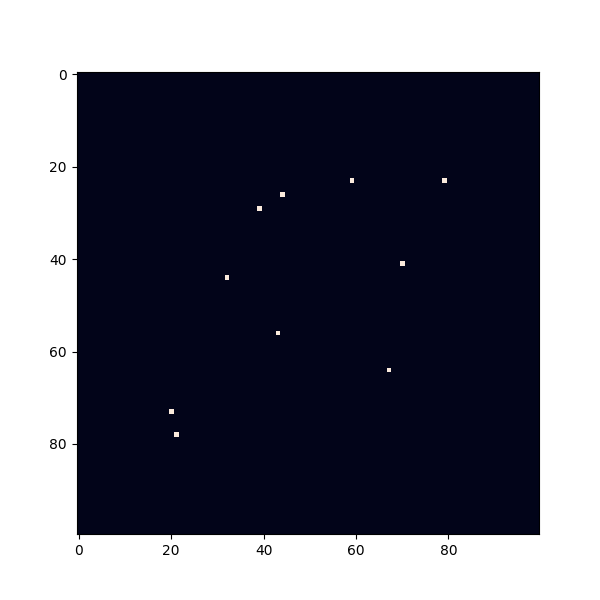

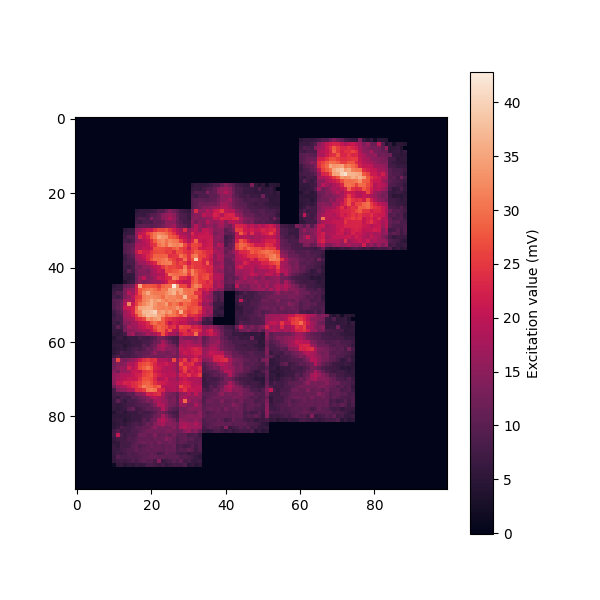

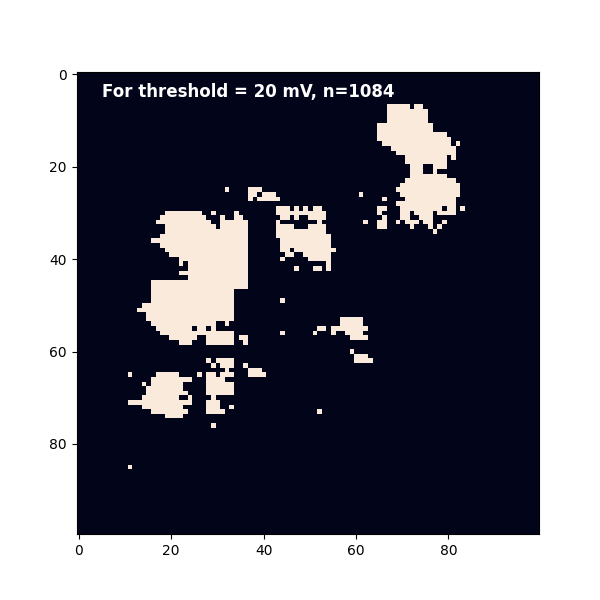

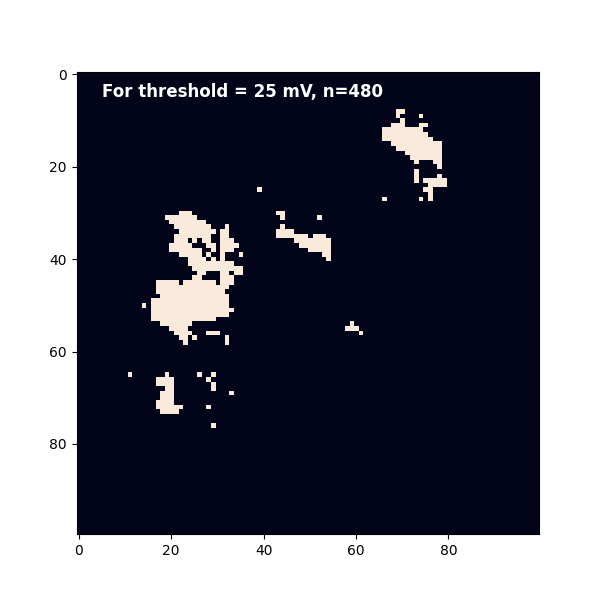

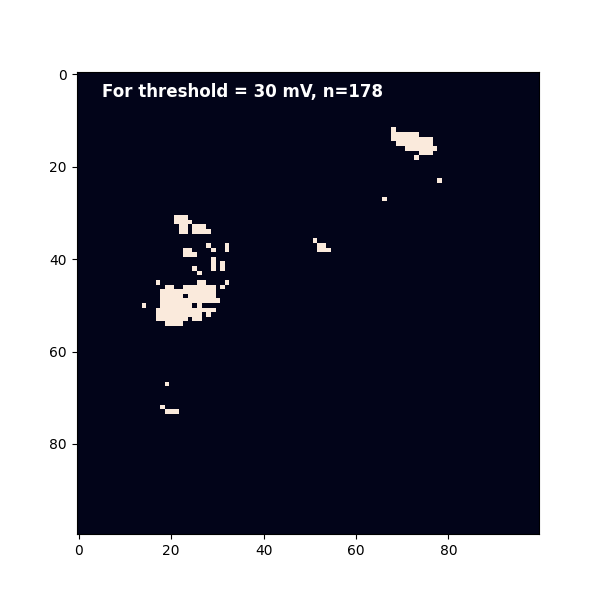

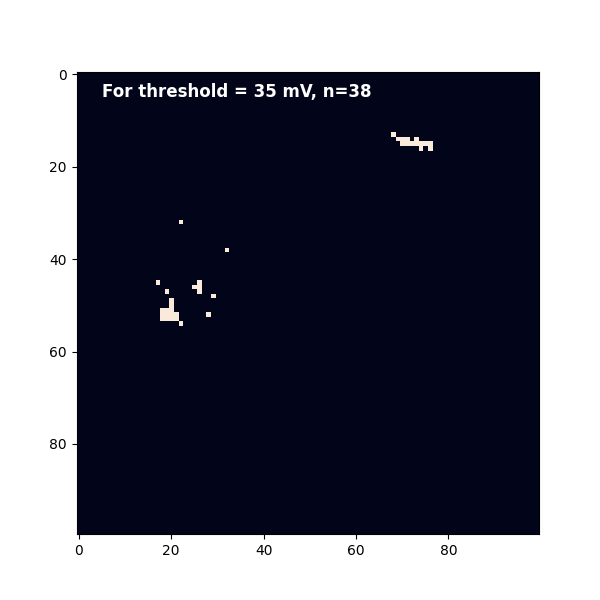

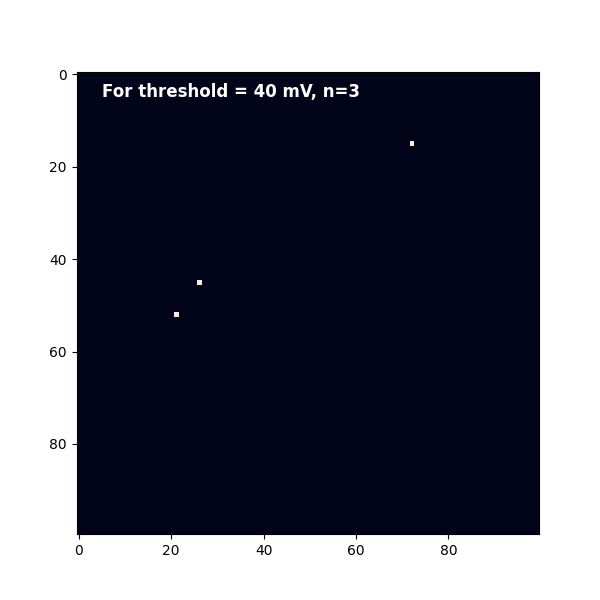

In [61]:
# create a cell layer as a numpy array of 100 x 100 neurons. Randomly select 10 neurons from the whole layer and apply the kernel to them
cell_layer = np.zeros((100,100))
# use a particular random seed state
np.random.seed(0)
neuron_locs = np.random.randint(20, 80,(10,2))
for loc in neuron_locs:
    cell_layer[loc[0],loc[1]] = 1

# apply the kernel to the cell layer for each neuron and add the kernel value for each location
output = np.zeros((100,100))

# import cv2

# output = cv2.filter2D(src=cell_layer, ddepth=-1, kernel=kernel)

# plt.figure()
# plt.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# plt.figure()
# plt.imshow(output, cmap='rocket', interpolation='nearest')
for loc in neuron_locs:
    x1 = loc[0]-13
    x2 = loc[0]+11
    y1 = loc[1]-14
    y2 = loc[1]+15
    # print(x1,x2,x2-x1, y1,y2, y2-y1, kernel.shape)
    output[y1:y2, x1:x2] += kernel
figin, axin = plt.subplots(figsize=(6,6))
axin.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# save fig
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.svg')
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.png')

figout, axout = plt.subplots(figsize=(6,6))
axout.imshow(output, cmap='rocket', interpolation='nearest')
# colourbar
cbar = plt.colorbar(axout.imshow(output, cmap='rocket', interpolation='nearest'))
cbar.set_label('Excitation value (mV)')
# save fig
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.svg')
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.png')

# create a new array by thresholding the output array
threshold = [20,25,30,35,40]
for th in threshold:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>th] = 1
    # plot in a new figure
    figout_thresh, axout_thresh = plt.subplots(figsize=(6,6))
    axout_thresh.imshow(output_thresholded, cmap='rocket', interpolation='nearest')
    # annotate the total number of neurons activated in the figure
    neurons_crossing_threshold = np.sum(output_thresholded)
    axout_thresh.text(5,5,f'For threshold = {th} mV, n={int(neurons_crossing_threshold)}', color='white', fontsize=12, fontweight='bold')
    # save fig
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.svg')
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.png')
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')

actual number of neurons activated: 1894.0
actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


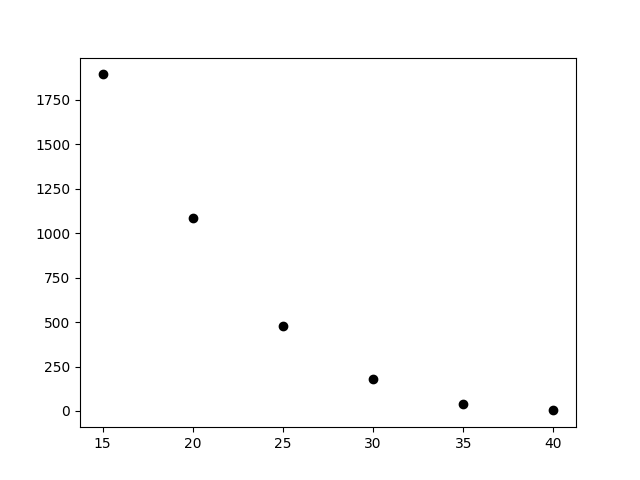

In [57]:
plt.figure()

for i in [15,20,25,30,35,40]:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>i] = 1
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')
    plt.scatter(i, np.sum(output_thresholded), color='black')
plt.show()
plt.xlabel('Threshold (a.u.)')
plt.ylabel('Number of activated neurons')
# remove top and right spines
sns.despine()
# save fig
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.svg')
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.png')
    

Loading ABF file
Datafile has 1 sweeps in 2 channels.


c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


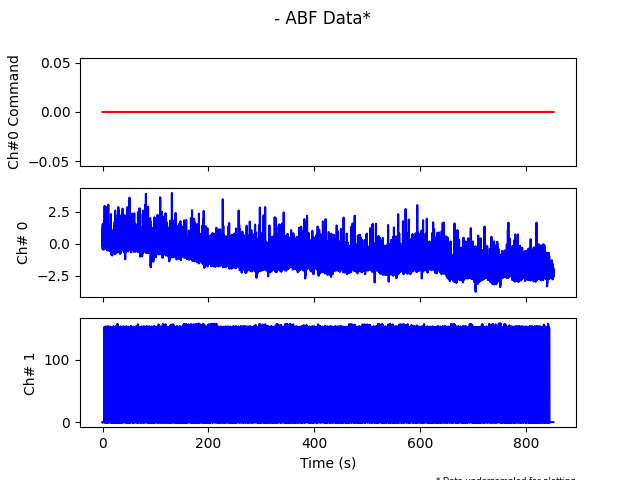

In [16]:
from asymmetry import abf_to_data as ad
from asymmetry import utils

data = ad.abf_to_data(file_path, baseline_subtraction=True,
        signal_scaling=1, sampling_freq=2e4, filter_type='', filter_cutoff=1000,
        data_order="channelwise", plot_data=True)[0][0]

data = data.ravel()

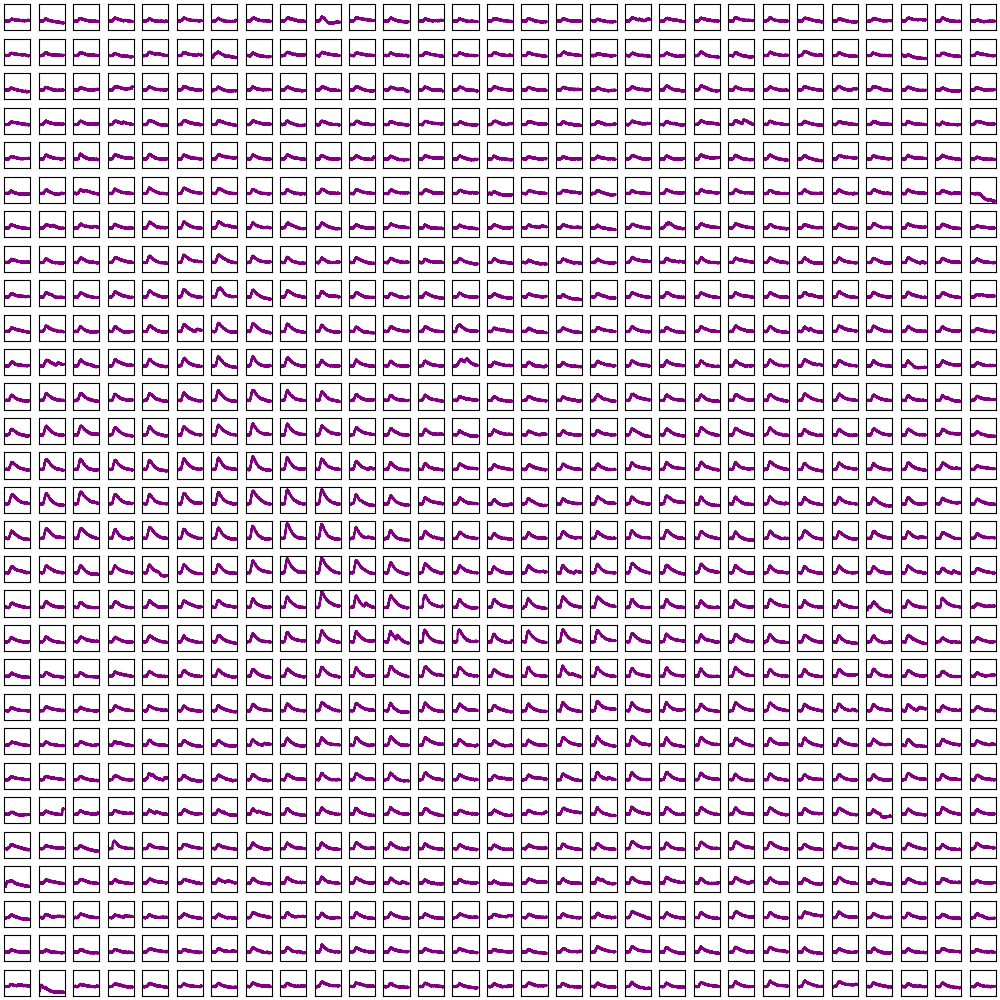

In [17]:
fig, ax = plt.subplots(29,29, figsize=(10,10), sharex=True, sharey=True, layout='constrained')

for k in range(841):
    T0 = -25
    T1 = 175
    x,y = peak_df['x'][k], peak_df['y'][k]
    t0 = int(stim_times[k] + T0*20)
    t1 = int(stim_times[k] + T1*20)
    cellslice = data[t0:t1]
    cellslice = cellslice - np.mean(cellslice[:500])
    ax[x,y].plot(np.linspace(T0, T1, len(cellslice)), cellslice, 'purple')
    # remove all ticks, ticklabels, but keep the bounding box
    ax[x,y].set_xticks([])
    ax[x,y].set_yticks([])
    # ax[x,y].spines['top'].set_visible(False
    # print(k,x,y)
# save fig
filename_prefix = f'CaMKII_27Apr18_expt10'
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.svg')
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.png')


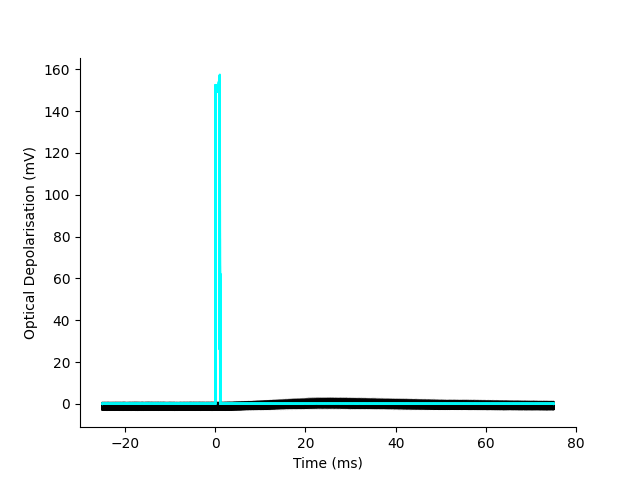

In [46]:
# plot
fig3, ax3 = plt.subplots()
T0,T1 = -25,75
Fs=20
for st in stim_times:
    # print(st)
    t0, t1 = int(st+T0*Fs), int(st+T1*Fs)
    stim_slice = stim[t0:t1]
    cell_slice = cell[t0:t1]
    cellmax = np.max(cell_slice)
    cellauc = np.trapz(cell_slice) / 20000
    time = np.linspace(T0, T1, len(cell_slice))
    if cellmax>12:
        ax3.plot(time, cell_slice, 'blue', alpha=0.1)
    else:
        ax3.plot(time, cell_slice, 'black', alpha=0.1)
    ax3.plot(time, stim_slice, 'cyan', alpha=0.1)

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Optical Depolarisation (mV)')
# remove spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# save fig
fig3.savefig(fig_folder / f'{filename_prefix}_raw_traces.svg')

In [28]:
# scipy to open matlab files
from scipy.io import loadmat
import h5py
import scipy.io as sio

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'OrderFileName', 'OrderFilePathName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'PolygonTracelet', 'TimeTrace', 'TraceFile', 'aucDuration', 'aucTime', 'gridAuc', 'None', 'gridOrder', 'gridPeak', 'gridSize', 'j', 'locs', 'orderFile', 'peaks', 'responseImageFile', '__function_workspace__'])


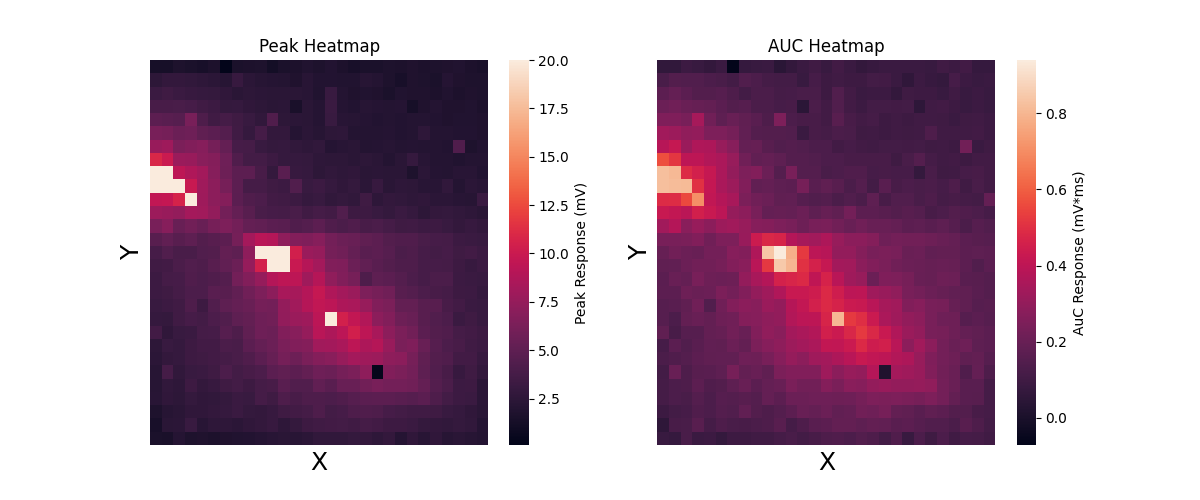

In [69]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\May17\30May17\Expt3_300517\Expt3_300517_Ordered_Grid_29.mat") # CaMK18 300517
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\59xgrid29roi_100perc10ms.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//59, (c-1)%59
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK18_300517_expt03'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'TimeTrace', 'TraceFile', 'ans', 'aucDuration', 'aucTime', 'coord', 'coordFileName', 'coordFilePathName', 'fid', 'gridAuc', 'None', 'gridPeak', 'gridSize', 'j', 'locs', 'peaks', '__function_workspace__'])


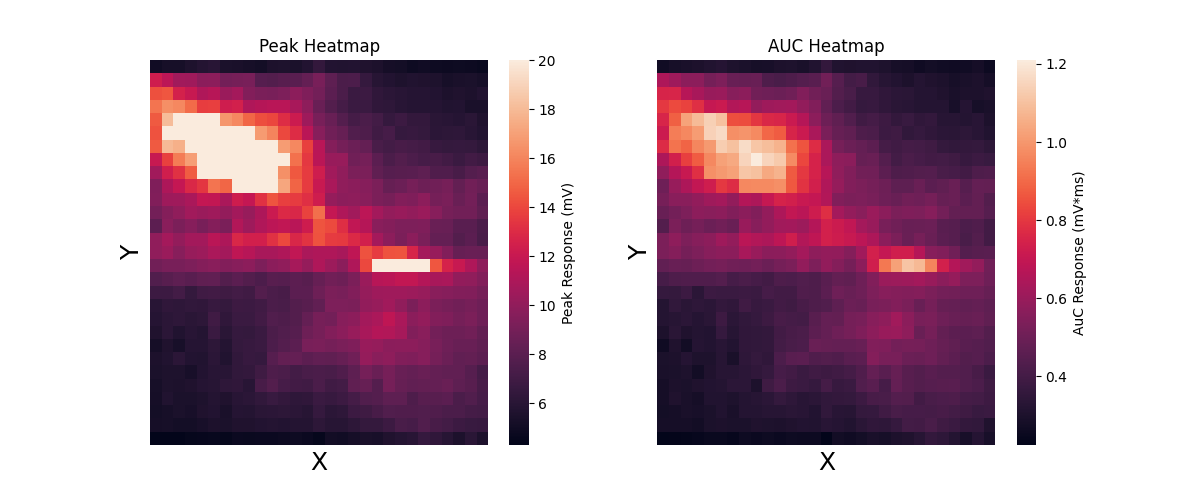

In [70]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_170817\Expt05_170817_Ordered_Grid_29.mat")
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_grid29_random.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//29, (c-1)%29
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK31_170817_expt05'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')

## Make a cell network grid

In [1]:
# steps:
# 1. make a 24x24 grid denoted by 2400x2400 pixels. each neuron has a soma and a dendritic arbour.
# 2. make a cell network of 256 neurons arranged in a coordinate system from x=(0,24) and y=(4,20). choose the locations randomly.
# 3. soma of each neuron is a 80x40 pixels and has an excitability value of 0.1
# 4. dendritic arbour is a collection of randomly chosen 2500 pixels in a box of 500x100 pixels. each pixel has an excitability value of 0.01
# thus each neuron has 1 location, 80x40 =3200 pixels of soma, and 2500 pixels of dendrites with their respective excitability values. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

In [148]:
np.int([2.5, 7.9]).astype(int)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [184]:
import cv2
from scipy.ndimage import gaussian_filter

def generate_template(raw_singlecell_response_heatmap, trim=[6,0,0,0], dendrite_to_soma_excitability_ratio=0.85, ):
    trimtop, trimbottom,trimleft,trimright = trim
    numrows, numcols = raw_singlecell_response_heatmap.shape
    template_raw = raw_singlecell_response_heatmap.to_numpy()[trimtop:numrows-trimbottom, trimleft:numcols-trimright]
    tempmax = np.max(template_raw)
    newrows, newcols = template_raw.shape
    template_raw = dendrite_to_soma_excitability_ratio*(template_raw / tempmax)
    centrerow, centrecol = np.array([newrows//2, newcols//2]).astype(int)
    template_raw[centrerow-2 : centrerow+2, centrecol] = 1
    template_raw[centrerow,centrecol-2:centrecol+2] = 1

    return template_raw

def optical_transfer_function(template_raw, added_noise_to_template=0, stretching_factor=5, neurons=100, polygon_pattern_numSq=15, illumination_intensity=50, illumination_noise_factor=0, diffraction_sigma=20, tissue_opacity_noise=0, plot=False, fig=None, ax=None):

    # Resize the image
    template = cv2.resize(template_raw, (stretching_factor*template_raw.shape[1], stretching_factor*template_raw.shape[0]), interpolation=cv2.INTER_NEAREST)
    th,tw    = template.shape
    template = template + added_noise_to_template * np.random.normal(0,1,template.shape)

    nh, nw =  stretching_factor* np.array([th,tw])
    pad = np.max([th//2, tw//2])+1
    
    # network
    celllocs = {}
    network = np.zeros((nh+2*pad,nw+2*pad,neurons))
    for i in range(neurons):
        # choose a random location for the neuron
        x,y = np.random.randint(pad, nw+pad),np.random.randint(pad, nh+pad)
        celllocs[i] = [x,y]
        # at this location, place the template
        network[y-tw//2 : y+1+tw//2, x-th//2 : x+1+th//2, i] = template.T
    
    # # trim the network to remove padding
    network = network[pad:nh+pad, pad:nw+pad] # because maxstrength of template is 1, all neurons will have a max strength of 1
    print(network.shape)

    polygon_frame_aspect = 1.78
    pw,ph = nw, int(nh // polygon_frame_aspect)
    padx = (nh-ph)//2
    pady = (nw-pw)//2
    polygon_pattern_numSq = 15
    polygon_spot_size = stretching_factor
    polygon_frame = np.zeros((nh,nw))
    # print(pw,ph,padx,pady)
    # at each location, place a square of 10x10 pixels
    for i in range(polygon_pattern_numSq):
        x,y = np.random.randint(padx,ph+padx), np.random.randint(pady, pw+pady)
        polygon_frame[x:x+polygon_spot_size, y:y+polygon_spot_size] = 1

    # apply gaussian blur on the polygon frame
    illumination_noise = illumination_noise_factor * np.random.normal(0,1,polygon_frame.shape)
    polygon_frame_blur = illumination_noise * polygon_frame + gaussian_filter(illumination_intensity*polygon_frame, sigma=diffraction_sigma)
    if plot:
        print('making a new fig')
        fig,ax = plt.subplots(2,3,  figsize=(10,10))
        [[ax0,ax1,ax2],[ax3,ax4,ax5]] = ax
        ax0.imshow(template, cmap='gray', vmin=0, vmax=np.max(template))
        ax1.imshow(network[:,:,33], cmap='gray', vmin=0, vmax=np.max(network[:,:,33]))
        ax2.imshow(polygon_frame, cmap='gray', vmin=0, vmax=1)
        ax3.imshow(polygon_frame_blur, cmap='gray', vmin=0, vmax=1)
        # flatten the network in Z and show
        zstack = np.sum(network, axis=2)
        ax4.imshow(zstack, cmap='gray', vmin=0, vmax=np.max(zstack))
        # lastly show a superimposed image of the zstack and the polygon frame blurred
        ax5.imshow(zstack, cmap='gray', vmin=0, vmax=np.max(zstack))
        ax5.imshow(polygon_frame_blur, cmap='Blues', alpha=0.5, vmin=0, vmax=np.max(polygon_frame_blur))
        plt.tight_layout()

    # now we need to take a sum of the product of individual pixels of the network with those of the polygon frame
    output = np.zeros_like(network)
    responsedict = []
    tissue_opacity_factor = tissue_opacity_noise * np.random.uniform(0,1.0)
    for i in range(neurons):
        output[:,:,i] = network[:,:,i] * polygon_frame_blur
        response = np.sum(tissue_opacity_factor * output[:,:,i])
        cellx, celly = celllocs[i]
        responsedict.append({'cellID':i, 'locx':cellx, 'locy':celly, 'response':response, 'spike':response>20})
    response_df = pd.DataFrame(responsedict)

    return network, response_df, fig, ax

(575, 725, 500)
making a new fig


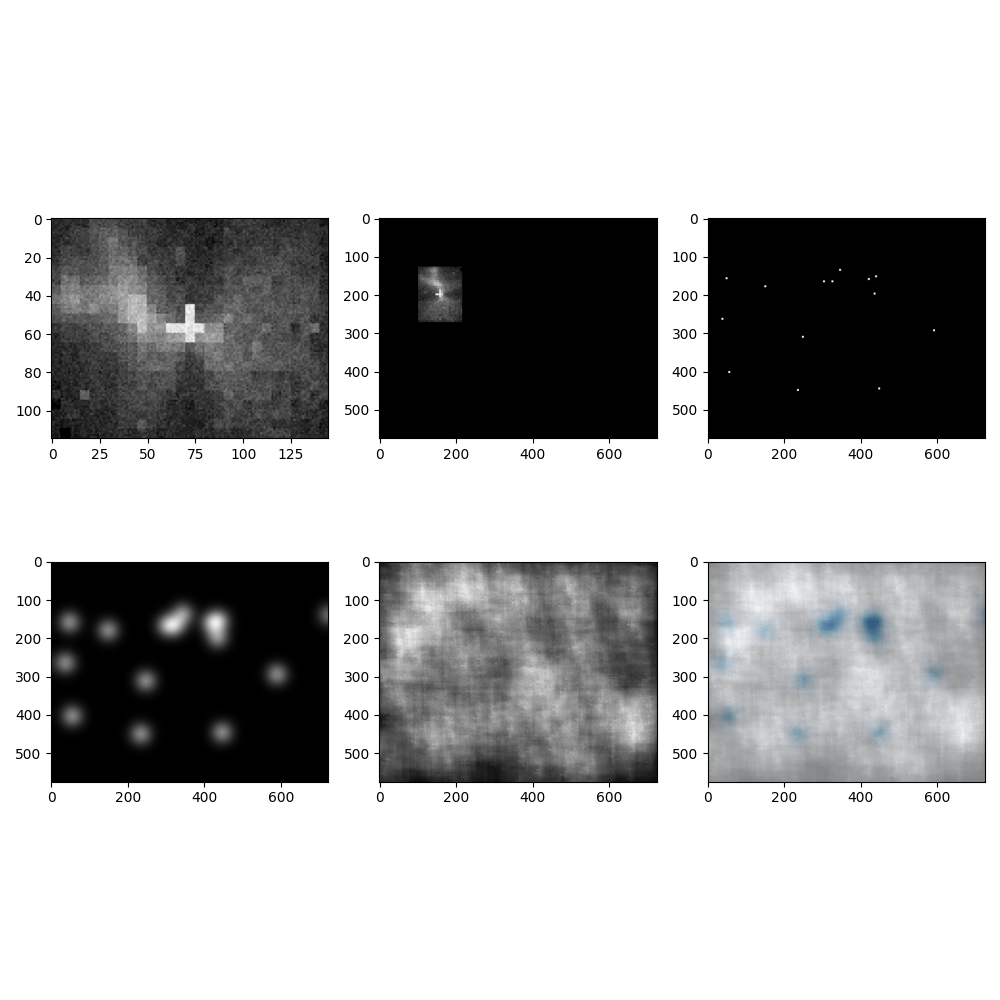

In [189]:
plt.close('all')
template_raw = generate_template(df_pivot_auc_29, trim=[6,0,0,0], dendrite_to_soma_excitability_ratio=0.85)
network, OTF, fig, axs = optical_transfer_function(template_raw, added_noise_to_template=0.05, stretching_factor=5, neurons=500, 
                                                        polygon_pattern_numSq=15, illumination_intensity=50, diffraction_sigma=20,
                                                        illumination_noise_factor=0.1, tissue_opacity_noise=0.1,
                                                        plot=True, fig=None, ax=None)
                                                        # save fig
fig.tight_layout()
fig.savefig(fig_folder / 'optical_transfer_function_500neuron_15sq.svg')
fig.savefig(fig_folder / 'optical_transfer_function_500neuron_15sq.png')

# save the response dataframe
OTF.to_csv(fig_folder / 'optical_transfer_function_500neuron_15sq_wnoise.csv', index=False)

<Axes: xlabel='response', ylabel='Count'>

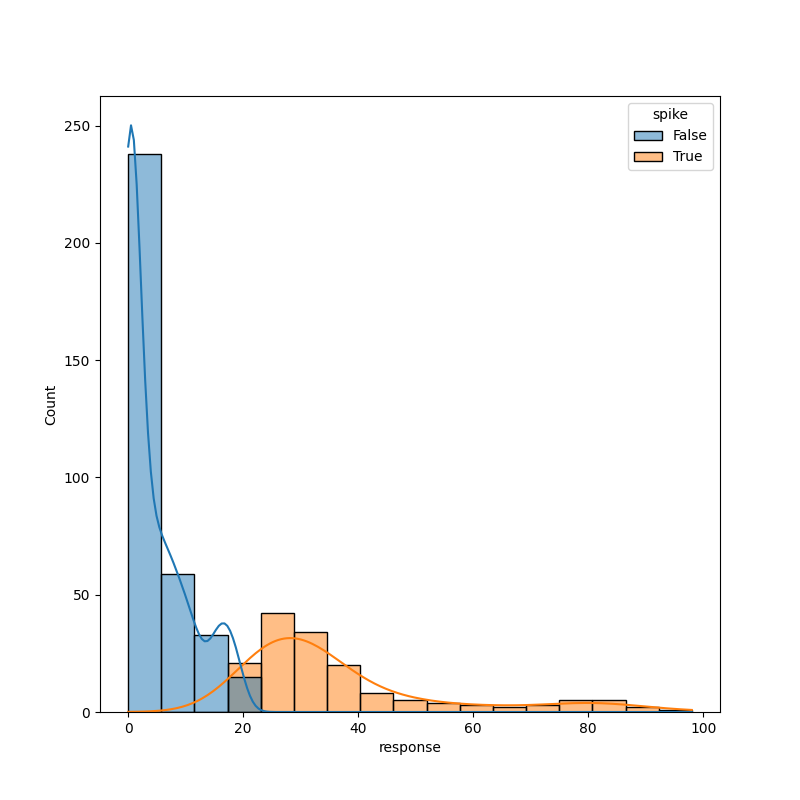

In [192]:
fig,ax = plt.subplots(1,1, figsize=(8,8))
sns.histplot(data=OTF, x='response', hue='spike', kde=True, ax=ax)

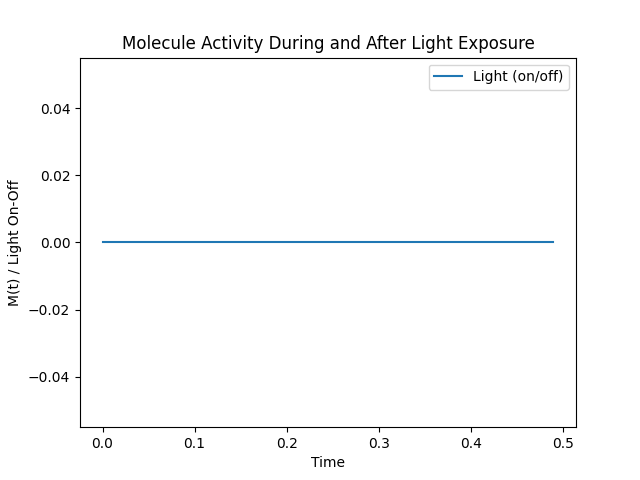

In [245]:
plt.figure()

# Parameters
alpha   = 20  # bleaching rate when light is on
beta    = 50  # recovery rate when light is off
M_init  = 10  # initial amount of active molecule
dt      = 0.01  # time step
t_final = 0.5  # total time for simulation, ms

# Define the light waveform as a function of time
# Let's assume light is on between t=20 and t=40
time = np.arange(0, t_final, dt)
# make a sinusoidal waveform
freq = 20 # Hz
light = np.sin(2*np.pi*freq*(time))
light = np.where(light>0, 1, 0)
light[0:50] = 0
light[300:] = 0

# Initialize molecule amount array
M = np.zeros(len(time))
M[0] = M_init  # Initial condition

# Euler's method loop
for n in range(1, len(time)):
    dM_dt = -alpha * light[n] * M[n-1] + beta * (M_init - M[n-1])
    M[n] = M[n-1] + dt * dM_dt

# Plot the results
# plt.plot(time, M, label='Active Molecule')
plt.plot(time, light, label='Light (on/off)', linestyle='-')
plt.xlabel('Time')
plt.ylabel('M(t) / Light On-Off')
plt.legend()
plt.title('Molecule Activity During and After Light Exposure')
plt.show()


(10066,) (10066,) (1000,)


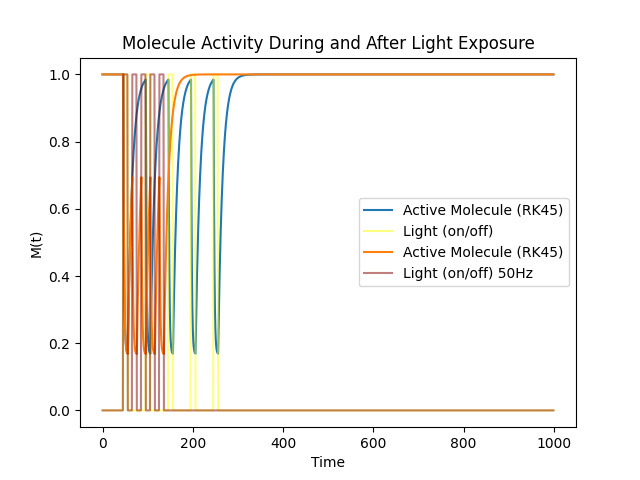

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45

# Parameters
alpha = 0.5  # bleaching rate when light20 is on
beta = 0.1  # recovery rate when light20 is off (low value =  slow recovery)
M_init = 1.0  # initial amount of active molecule
t0 = 0  # initial time
t_final = 999  # final time for the simulation

# Define the light20 waveform as a function of time

spike_times20hz = [50,100,150,200,250] # 20Hz
spike_times50hz = [50,70,90,110,130] # 50Hz
pulse = np.ones(10)  # 20 ms light pulse
light20 = np.linspace(0,0,1000)
light50 = np.linspace(0,0,1000)
light20[spike_times20hz] = 1  # Add spikes at the specified times
light50[spike_times50hz] = 1  # Add spikes at the specified times
light20 = np.convolve(light20, pulse, mode='same')
light50 = np.convolve(light50, pulse, mode='same')

def is_light_on(timepoint):
    return 1 if light20[int(timepoint)] > 0 else 0
def is_light_on50(timepoint):
    return 1 if light50[int(timepoint)] > 0 else 0

# Define the system of differential equations
def molecule_activity(t, M):
    L = is_light_on50(t)
    dM_dt = -alpha * L * M + beta * (M_init - M)
    return dM_dt

# Initialize RK45 solver
solver = RK45(
    fun=molecule_activity,  # the function representing the system
    t0=t0,                 # initial time
    y0=[M_init],           # initial molecule state (M0)
    t_bound=t_final,       # end of simulation time
    max_step=0.1,          # limit on step size (adjustable)
    rtol=1e-6,             # relative tolerance
    atol=1e-8              # absolute tolerance
)

# Time points to evaluate solution
times = []
M_values = []

# Solving the ODE system using RK45
while solver.status == 'running':
    solver.step()
    times.append(solver.t)
    M_values.append(solver.y[0])

# Convert the results to numpy arrays for easier manipulation
times = np.array(times)
M_values = np.array(M_values)

# Plot the results
print(times.shape, M_values.shape, light20.shape)
# plt.figure()
plt.plot(times, M_values, label='Active Molecule (RK45)')
plt.plot(light50, color='maroon', alpha=0.5, label='Light (on/off) 50Hz')
plt.xlabel('Time')
plt.ylabel('M(t)')
plt.legend()
plt.title('Molecule Activity During and After Light Exposure')
plt.show()


## Opsin kinetics graph

In [6]:
import pandas as pd
from pathlib import Path
import seaborn as sns

In [20]:
opsin_kinetics_jm = pd.read_csv(Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Thesis\opsins_review_Mattis2012.txt"), delimiter='\t') # Joanna Mattis et al 2012
opsin_kinetics_nk = pd.read_csv(Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Thesis\opsins_review_Klapoetke2014.txt"), delimiter='\t') # Klapoteke et al 2014

In [21]:
opsin_kinetics_nk.sample(10)

Molecule    Values  s.e.m.  wavelength       Column1  std
89     jaws     4.100     NaN         584   On Kinetics  yes
0     AgChR     0.000    0.00         660  Peak Current   no
19    VChR1    35.130   11.75         660  Peak Current  yes
74    TsChR     3.830    0.38         470  Off Kinetics   no
33    NsChR     3.380    1.69         530  Peak Current   no
39    VChR1   159.380   58.38         530  Peak Current  yes
85    ArchT   120.000     NaN         632  Peak Current  yes
10    CsChR     3.836    1.46         660  Peak Current   no
48    CoChR  3253.580  227.96         470  Peak Current   no
69    HdChR    21.980    2.03         470  Off Kinetics   no

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# broad form df by pivoting
opsin_kinetics_nk = opsin_kinetics_nk.pivot(index=['Molecule','wavelength'], columns=['Column1'], values='Values')
opsin_kinetics_nk.head(10)

Column1              Off Kinetics  On Kinetics  Peak Current
Molecule wavelength                                         
AgChR    470                  NaN          NaN         4.760
         530                  NaN          NaN         0.320
         660                  NaN          NaN         0.000
ArchT    632                  9.6      5.31000       120.000
BsChR2   470                126.4          NaN       683.240
         530                  NaN          NaN       108.410
         660                  NaN          NaN         0.000
C1V1TT   470                  NaN          NaN       259.560
         530                 37.0      6.76667       408.070
         660                  NaN          NaN        22.646

In [25]:
opsin_kinetics_jm

Opsin  Ipeak   Iss  tau des  tau peak  tau off
0      ChR2   1.10  0.30    31.92      8.87   11.110
1     ChR2R   1.20  0.60    24.04      9.09   23.460
2    ChETAA   0.40  0.25    25.43      9.22    7.051
3        TC   1.40  0.50    42.56      9.71   24.491
4   ChETATC   1.20  0.55    31.23     10.28   13.592
5     CatCh   1.25  1.00    50.63     17.33   60.954
6     ChIEF   1.10  0.77    48.42     19.26    9.610
7        FR   1.50  1.00    45.81     10.34   16.839
8        GR   0.80  0.70    94.80     14.96   16.839
9     C1V1T   1.50  0.88    55.71     16.00   59.831
10   C1V1TT   1.00  0.58    77.73     17.75   46.119

<Axes: xlabel='Ipeak', ylabel='tau off'>

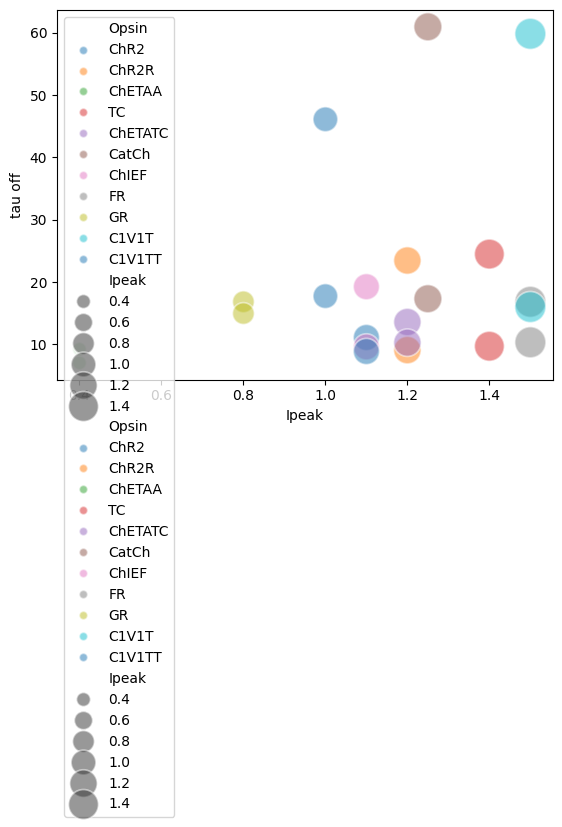

In [42]:
sns.scatterplot(data=opsin_kinetics_jm, x='Ipeak', y='tau off', hue='Opsin', size='Ipeak', sizes=(100,500), alpha=0.5, palette='tab10' )
sns.scatterplot(data=opsin_kinetics_jm, x='Ipeak', y='tau peak', hue='Opsin', size='Ipeak', sizes=(100,500), alpha=0.5, palette='tab10' )